# **Hindi Hatespeech Detection**

---
Hate speech detection is a critical task in natural language processing, particularly in the context of social media platforms where hateful content can have significant real-world consequences. In this notebook, we focus on the detection of hate speech in Hindi text using machine learning techniques.

We will classify the sentences on two labels Needs_moderation and Non-hostile.


In [1]:
!pip install emoji

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 433.8/433.8 kB 6.3 MB/s eta 0:00:00


In [2]:
!pip install scikit-learn

In [3]:
import pandas as pd
import emoji
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier # Works well
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Works well
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC # Works well
from sklearn.tree import DecisionTreeClassifier # Works well
from sklearn.neighbors import KNeighborsClassifier # Works well
from sklearn.naive_bayes import MultinomialNB # Meh
from sklearn.metrics import classification_report
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
data = pd.read_csv('/content/constraint_Hindi_Train - Sheet1.csv')
data.head()

Unique ID                                               Post  \
0          1  ‡§Æ‡•á‡§∞‡•á ‡§¶‡•á‡§∂ ‡§ï‡•á ‡§π‡§ø‡§®‡•ç‡§¶‡•Å ‡§¨‡§π‡•Å‡§§ ‡§®‡§ø‡§∞‡§æ‡§≤‡•á ‡§π‡•à‡•§ ‡§ï‡•Å‡§õ ‡§§‡•ã ‡§™‡§ï‡•ç‡§ï...   
1          2  ‡§∏‡§∞‡§ï‡§æ‡§∞ ‡§π‡§Æ‡•á‡§∂‡§æ ‡§∏‡•á ‡§ï‡§ø‡§∏‡§æ‡§®‡•ã‡§Ç ‡§ï‡•Ä ‡§ï‡§Æ‡§æ‡§à ‡§ï‡•ã ‡§¨‡§¢‡§º‡§æ‡§®‡•á ‡§ï‡•á ‡§≤‡§ø...   
2          3  ‡§∏‡•Å‡§∂‡§æ‡§Ç‡§§ ‡§®‡•á ‡§ú‡•ã ‡§¨‡§ø‡§ú‡§®‡•á‡§∏ ‡§°‡•Ä‡§≤ 9 ‡§ú‡•Ç‡§® ‡§ï‡•ã ‡§ï‡•Ä ‡§•‡•Ä, ‡§µ‡•ã ‡§°‡•Ä‡§≤...   
3          4  @prabhav218 ‡§∏‡§æ‡§≤‡•á ‡§ú‡•á‡§è‡§®‡§Ø‡•Ç ‡§õ‡§æ‡§™ ‡§ï‡§Æ‡§ø‡§®‡•á ‡§≤‡•ã‡§ó ‡§π‡§ø‡§®‡•ç‡§¶‡•Å‡§ì‡§Ç...   
4          5  #unlock4guidelines - ‡§Ö‡§®‡§≤‡•â‡§ï-4 ‡§ï‡•á ‡§≤‡§ø‡§è ‡§ó‡§æ‡§á‡§°‡§≤‡§æ‡§á‡§®‡•ç‡§∏...   

             Labels Set  
0        hate,offensive  
1           non-hostile  
2           non-hostile  
3  defamation,offensive  
4           non-hostile

In [5]:
data['Labels Set'] = data['Labels Set'].replace({'offensive': 'hate', 'defamation': 'hate'})

# Verify the changes
data['Labels Set'].value_counts()

Labels Set
non-hostile                       3050
hate                              1188
fake                              1009
hate,offensive                     163
defamation,offensive                81
defamation,hate                     74
defamation,fake                     34
defamation,hate,offensive           28
fake,offensive                      28
fake,hate                           27
defamation,fake,offensive           24
defamation,fake,hate                 9
defamation,fake,hate,offensive       9
fake,hate,offensive                  4
Name: count, dtype: int64

In [6]:
data['Labels Set'] = data['Labels Set'].replace({'offensive': 'hate', 'defamation': 'hate', 'hate,offensive': 'hate', 'defamation,offensive': 'hate', 'defamation,hate': 'hate', 'defamation,fake': 'hate', 'defamation,hate,offensive': 'hate', 'fake,offensive': 'hate', 'fake,hate': 'hate', 'defamation,fake,offensive': 'hate', 'defamation,fake,hate': 'hate', 'defamation,fake,hate,offensive': 'hate', 'fake,hate,offensive': 'hate'})
print(data['Labels Set'].value_counts())

Labels Set
non-hostile    3050
hate           1669
fake           1009
Name: count, dtype: int64


In [7]:
data['Labels Set'] = data['Labels Set'].replace({'hate': 'needs_moderation', 'fake': 'needs_moderation'})
print(data['Labels Set'].value_counts())

Labels Set
non-hostile         3050
needs_moderation    2678
Name: count, dtype: int64


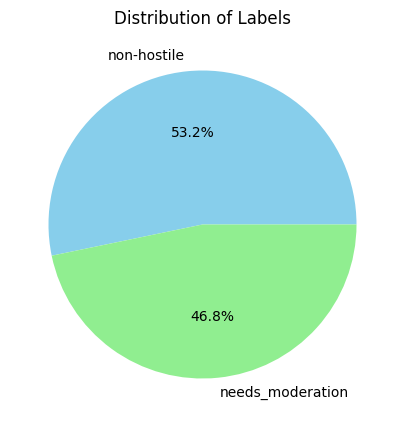

In [8]:
# Count the number of occurrences for each label
label_counts = data['Labels Set'].value_counts()

# Plot a pie chart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Distribution of Labels')
plt.show()

Stopwords are common words like "‡§á‡§∏‡§ï‡§æ", "‡§ï‡§∞‡§§‡•á", and "‡§Æ‡§ó‡§∞" that occur frequently in a language but often do not carry significant meaning in the context of text analysis. We remove them because they can add noise to our analysis and don't provide useful information for tasks like classification or sentiment analysis.

In [9]:
STOPWORDS = ["‡§Ö‡§Ç‡§¶‡§∞","‡§Ö‡§§","‡§Ö‡§¶‡§ø","‡§Ö‡§™","‡§Ö‡§™‡§®‡§æ","‡§Ö‡§™‡§®‡§ø","‡§Ö‡§™‡§®‡•Ä","‡§Ö‡§™‡§®‡•á","‡§Ö‡§≠‡§ø","‡§Ö‡§≠‡•Ä","‡§Ü‡§¶‡§ø","‡§Ü‡§™","‡§á‡§Ç‡§π‡§ø‡§Ç","‡§á‡§Ç‡§π‡•á‡§Ç","‡§á‡§Ç‡§π‡•ã‡§Ç","‡§á‡§§‡§Ø‡§æ‡§¶‡§ø","‡§á‡§§‡•ç‡§Ø‡§æ‡§¶‡§ø","‡§á‡§®","‡§á‡§®‡§ï‡§æ","‡§á‡§®‡•ç‡§π‡•Ä‡§Ç","‡§á‡§®‡•ç‡§π‡•á‡§Ç","‡§á‡§®‡•ç‡§π‡•ã‡§Ç","‡§á‡§∏","‡§á‡§∏‡§ï‡§æ","‡§á‡§∏‡§ï‡§ø","‡§á‡§∏‡§ï‡•Ä","‡§á‡§∏‡§ï‡•á","‡§á‡§∏‡§Æ‡•á‡§Ç","‡§á‡§∏‡§ø","‡§á‡§∏‡•Ä","‡§á‡§∏‡•á","‡§â‡§Ç‡§π‡§ø‡§Ç","‡§â‡§Ç‡§π‡•á‡§Ç","‡§â‡§Ç‡§π‡•ã‡§Ç","‡§â‡§®","‡§â‡§®‡§ï‡§æ","‡§â‡§®‡§ï‡§ø","‡§â‡§®‡§ï‡•Ä","‡§â‡§®‡§ï‡•á","‡§â‡§®‡§ï‡•ã","‡§â‡§®‡•ç‡§π‡•Ä‡§Ç","‡§â‡§®‡•ç‡§π‡•á‡§Ç","‡§â‡§®‡•ç‡§π‡•ã‡§Ç","‡§â‡§∏","‡§â‡§∏‡§ï‡•á",'‡§•‡•Ä,',"‡§â‡§∏‡§ø","‡§â‡§∏‡•Ä","‡§â‡§∏‡•á","‡§è‡§ï","‡§è‡§µ‡§Ç","‡§è‡§∏","‡§è‡§∏‡•á","‡§ê‡§∏‡•á","‡§ì‡§∞","‡§î‡§∞","‡§ï‡§á","‡§ï‡§à","‡§ï‡§∞","‡§ï‡§∞‡§§‡§æ","‡§ï‡§∞‡§§‡•á","‡§ï‡§∞‡§®‡§æ","‡§ï‡§∞‡§®‡•á","‡§ï‡§∞‡•á‡§Ç","‡§ï‡§π‡§§‡•á","‡§ï‡§π‡§æ",'‡§ï‡§π‡§æ‡§Å',"‡§ï‡§æ","‡§ï‡§æ‡§´‡§ø","‡§ï‡§æ‡•û‡•Ä","‡§ï‡§ø","‡§ï‡§ø‡§Ç‡§π‡•á‡§Ç","‡§ï‡§ø‡§Ç‡§π‡•ã‡§Ç","‡§ï‡§ø‡§§‡§®‡§æ","‡§ï‡§ø‡§®‡•ç‡§π‡•á‡§Ç","‡§ï‡§ø‡§®‡•ç‡§π‡•ã‡§Ç","‡§ï‡§ø‡§Ø‡§æ","‡§ï‡§ø‡§∞",'‡§π‡§Æ',"‡§ï‡§ø‡§∏","‡§ï‡§ø‡§∏‡§ø","‡§ï‡§ø‡§∏‡•Ä","‡§ï‡§ø‡§∏‡•á","‡§ï‡•Ä","‡§ï‡•Å‡§õ","‡§ï‡•Å‡§≤","‡§ï‡•á","‡§ï‡•ã","‡§ï‡•ã‡§á","‡§ï‡•ã‡§à","‡§ï‡•ã‡§®","‡§ï‡•ã‡§®‡§∏‡§æ","‡§ï‡•å‡§®","‡§ï‡•å‡§®‡§∏‡§æ","‡§ó‡§Ø‡§æ","‡§ò‡§∞","‡§ú‡§¨","‡§ú‡§π‡§æ‡§Å","‡§ú‡§π‡§æ‡§Ç","‡§ú‡§æ","‡§ú‡§ø‡§Ç‡§π‡•á‡§Ç","‡§ú‡§ø‡§Ç‡§π‡•ã‡§Ç","‡§ú‡§ø‡§§‡§®‡§æ","‡§ú‡§ø‡§ß‡§∞","‡§ú‡§ø‡§®","‡§ú‡§ø‡§®‡•ç‡§π‡•á‡§Ç","‡§ú‡§ø‡§®‡•ç‡§π‡•ã‡§Ç","‡§ú‡§ø‡§∏","‡§ú‡§ø‡§∏‡•á","‡§ú‡•Ä‡§ß‡§∞","‡§ú‡•á‡§∏‡§æ","‡§ú‡•á‡§∏‡•á","‡§ú‡•à‡§∏‡§æ","‡§ú‡•à‡§∏‡•á","‡§ú‡•ã","‡§§‡§ï","‡§§‡§¨","‡§§‡§∞‡§π","‡§§‡§ø‡§Ç‡§π‡•á‡§Ç","‡§§‡§ø‡§Ç‡§π‡•ã‡§Ç","‡§§‡§ø‡§®","‡§§‡§ø‡§®‡•ç‡§π‡•á‡§Ç","‡§§‡§ø‡§®‡•ç‡§π‡•ã‡§Ç","‡§§‡§ø‡§∏","‡§§‡§ø‡§∏‡•á","‡§§‡•ã","‡§•‡§æ","‡§•‡§ø","‡§•‡•Ä","‡§•‡•á","‡§¶‡§¨‡§æ‡§∞‡§æ","‡§¶‡§µ‡§æ‡§∞‡§æ","‡§¶‡§ø‡§Ø‡§æ","‡§¶‡•Å‡§∏‡§∞‡§æ","‡§¶‡•Å‡§∏‡§∞‡•á","‡§¶‡•Ç‡§∏‡§∞‡•á","‡§¶‡•ã","‡§¶‡•ç‡§µ‡§æ‡§∞‡§æ","‡§®","‡§®‡§π‡§ø‡§Ç","‡§®‡§π‡•Ä‡§Ç","‡§®‡§æ","‡§®‡§ø‡§ö‡•á","‡§®‡§ø‡§π‡§æ‡§Ø‡§§","‡§®‡•Ä‡§ö‡•á","‡§®‡•á","‡§™‡§∞","‡§™‡§π‡§≤‡•á","‡§™‡•Å‡§∞‡§æ","‡§™‡•Ç‡§∞‡§æ","‡§™‡•á","‡§´‡§ø‡§∞","‡§¨‡§®‡§ø","‡§¨‡§®‡•Ä","‡§¨‡§π‡§ø","‡§¨‡§π‡•Ä","‡§¨‡§π‡•Å‡§§","‡§¨‡§æ‡§¶","‡§¨‡§æ‡§≤‡§æ","‡§¨‡§ø‡§≤‡§ï‡•Å‡§≤","‡§≠‡§ø","‡§≠‡§ø‡§§‡§∞","‡§≠‡•Ä","‡§≠‡•Ä‡§§‡§∞","‡§Æ‡§ó‡§∞","‡§Æ‡§æ‡§®‡•ã","‡§Æ‡•á","‡§Æ‡•á‡§Ç","‡§Ø‡§¶‡§ø","‡§Ø‡§π","‡§Ø‡§π‡§æ‡§Å","‡§Ø‡§π‡§æ‡§Ç","‡§Ø‡§π‡§ø",'‡§∏‡•à‡§®‡•ç\u200d‡§Ø','‡§∏‡§Æ‡•ç\u200d‡§Æ‡§æ‡§®', '‡§®‡§à', '‡§¶‡§ø‡§≤‡•ç\u200d‡§≤‡•Ä', '‡§∏‡§Ç‡§∏‡•ç\u200d‡§ï‡§æ‡§∞‡•§',"‡§Ø‡§π‡•Ä","‡§Ø‡§æ","‡§Ø‡§ø‡§π","‡§Ø‡•á","‡§∞‡§ñ‡•á‡§Ç","‡§∞‡§µ‡§æ‡§∏‡§æ","‡§∞‡§π‡§æ","‡§∞‡§π‡•á","‡§±‡•ç‡§µ‡§æ‡§∏‡§æ","‡§≤‡§ø‡§è","‡§≤‡§ø‡§Ø‡•á","‡§≤‡•á‡§ï‡§ø‡§®","‡§µ","‡§µ‡§ó‡•á‡§∞‡§π","‡§µ‡§∞‡§ó","‡§µ‡§∞‡•ç‡§ó","‡§µ‡§π","‡§µ‡§π‡§æ‡§Å","‡§µ‡§π‡§æ‡§Ç","‡§µ‡§π‡§ø‡§Ç","‡§µ‡§π‡•Ä‡§Ç","‡§µ‡§æ‡§≤‡•á","‡§µ‡•Å‡§π","‡§µ‡•á","‡§µ‡•ö‡•à‡§∞‡§π","‡§∏‡§Ç‡§ó","‡§∏‡§ï‡§§‡§æ","‡§∏‡§ï‡§§‡•á","‡§∏‡§¨‡§∏‡•á","‡§∏‡§≠‡§ø",'‡§∂‡•ç‡§∞‡•Ä','‡§∏‡•ç\u200d‡§ü‡•Ä‡§´‡§®','‡§Æ‡§æ‡§ß‡•ç\u200d‡§Ø‡§Æ',"‡§∏‡§≠‡•Ä","‡§∏‡§æ‡§•","‡§∏‡§æ‡§¨‡•Å‡§§","‡§∏‡§æ‡§≠","‡§∏‡§æ‡§∞‡§æ","‡§∏‡•á","‡§∏‡•ã","‡§π‡§ø","‡§π‡•Ä","‡§π‡•Å‡§Ö","‡§π‡•Å‡§Ü","‡§π‡•Å‡§á","‡§π‡•Å‡§à","‡§π‡•Å‡§è","‡§π‡•á","‡§π‡•á‡§Ç","‡§π‡•à","‡§π‡•à‡§Ç","‡§π‡•ã","‡§π‡•ã‡§§‡§æ","‡§π‡•ã‡§§‡§ø","‡§π‡•ã‡§§‡•Ä","‡§π‡•ã‡§§‡•á","‡§π‡•ã‡§®‡§æ","‡§π‡•ã‡§®‡•á"'‡§•‡•Ä,', '‡§µ‡•ã','‡§Ü','‡§π‡•à‡§Ç.', '‡§®‡§è', '‡§π‡•à‡§Ç,','‡§ú‡§æ‡§è‡§ó‡•Ä', '‡§π‡•à‡•§','‡§π‡•à', '‡§ï‡•ç‡§Ø‡•ã‡§Ç','‡§π‡•à,']

In [10]:
# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in STOPWORDS]
    return ' '.join(filtered_tokens)

In [11]:
# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

In [12]:
# Function to remove emojis
def remove_emojis(text):
    return emoji.demojize(text)

In [13]:
def remove_hindi_punctuation(text):
    # Define a regular expression pattern to match Hindi punctuation characters
    hindi_punctuation_pattern = r'[^\w\s\d\u0900-\u097F]'
    # Substitute Hindi punctuation characters with an empty string
    clean_text = re.sub(hindi_punctuation_pattern, '', text)
    return clean_text

In [14]:
# Preprocess the text data
data['Post'] = data['Post'].apply(remove_urls)  # Remove URLs
data['Post'] = data['Post'].apply(remove_emojis)  # Remove emojis
data['Post'] = data['Post'].apply(remove_stopwords)  # Remove stopwords

data['Post'] = data['Post'].apply(remove_hindi_punctuation)

In [15]:
#Preprocss
'''
data['Post'] = data['Post'].apply(lambda x: x.lower())
data['Post'] = data['Post'].str.replace('[^a-zA-Z\s]', '', regex=True)
'''

"\ndata['Post'] = data['Post'].apply(lambda x: x.lower())\ndata['Post'] = data['Post'].str.replace('[^a-zA-Z\\s]', '', regex=True)\n"

**DO NOT READ ALL THESE YOU MIGHT LOSE YOUR SANITY**

In [16]:
bad_words = ['‡§Æ‡•É‡§§', '‡§¶‡•Å‡§∞‡•ç‡§≠‡§æ‡§ó‡•ç‡§Ø‡§∂‡§æ‡§≤‡•Ä', '‡§Ö‡§≠‡§æ‡§ó‡§æ', '‡§¨‡§¶‡§®‡§∏‡•Ä‡§¨', '‡§≠‡§æ‡§ó‡•ç‡§Ø‡§π‡•Ä‡§®', '‡§Æ‡§®‡§π‡•Ç‡§∏', '‡§¨‡§¶‡§ï‡§ø‡§∏‡•ç‡§Æ‡§§', '‡§Æ‡§Ç‡§¶‡§≠‡§æ‡§ó‡•ç‡§Ø', '‡§¨‡§¶‡§ï‡§º‡§ø‡§∏‡•ç‡§Æ‡§§', '‡§¶‡§à‡§Æ‡§æ‡§∞‡§æ', '‡§ï‡§Æ‡§¨‡§ñ‡•ç‡§§','‡§ï‡§Æ‡§¨‡§ñ‡§º‡•ç‡§§', '‡§Ö‡§ß‡§®‡•ç‡§Ø', '‡§Ö‡§≠‡§æ‡§ó‡•Ä', '‡§Ü‡§µ‡§æ‡§∏‡§π‡•Ä‡§®', '‡§Ü‡§∂‡•ç‡§∞‡§Ø‡§π‡•Ä‡§®', '‡§ó‡•É‡§π‡§π‡•Ä‡§®', '‡§ó‡•É‡§π‡§µ‡§ø‡§π‡•Ä‡§®', '‡§¨‡•á‡§ò‡§∞', '‡§¨‡•á‡§ò‡§∞‡§¨‡§æ‡§∞', '‡§Ö‡§ó‡§§‡§ø‡§ï', '‡§Ö‡§ó‡•á‡§π', '‡§Ö‡§®‡§ø‡§ï‡•á‡§§', '‡§¨‡§¶‡§¨‡•Ç‡§¶‡§æ‡§∞','‡§¶‡•Å‡§∞‡•ç‡§ó‡§Ç‡§ß‡§™‡•Ç‡§∞‡•ç‡§£', '‡§¶‡•Å‡§∞‡•ç‡§ó‡§Ç‡§ß‡§Ø‡•Å‡§ï‡•ç‡§§', '‡§¶‡•Å‡§∞‡•ç‡§ó‡§Ç‡§ß‡§ø‡§§', '‡§¢‡•Ä‡§≤‡§æ', '‡§Ö‡§∂‡•ç‡§≤‡§ø‡§∑‡•ç‡§ü', '‡§Ö‡§∏‡§Ç‡§Ø‡•Å‡§ï‡•ç‡§§', '‡§Ö‡§∏‡§Ç‡§Ø‡•ã‡§ú‡§ø‡§§', '‡§Ö‡§∏‡§Ç‡§¨‡§¶‡•ç‡§ß', '‡§Ö‡§≤‡§ó', '‡§Ö‡§ú‡•Å‡§°‡§º‡§æ', '‡§Ö‡§ú‡•ã‡§°‡§º', '‡§™‡•É‡§•‡§ï‡•ç', '‡§ú‡•Å‡§¶‡§æ', '‡§™‡•É‡§•‡§ï', '‡§Ö‡§™‡•É‡§ï‡•ç‡§§', '‡§™‡§∞‡§æ‡§ß‡•Ä‡§®', '‡§ó‡•Å‡§≤‡§æ‡§Æ', '‡§™‡§∞‡§§‡§Ç‡§§‡•ç‡§∞', '‡§Ö‡§®‡•ç‡§Ø‡§æ‡§ß‡•Ä‡§®', '‡§Ö‡§™‡§∞‡§µ‡§∂', '‡§™‡§∞‡§µ‡§∂', '‡§Ö‡§µ‡§∂', '‡§Ö‡§¨‡§∏', '‡§¢‡•Ä‡§≤‡§æ', '‡§ú‡§°‡§º', '‡§Ö‡§ö‡•à‡§§‡§®‡•ç‡§Ø', '‡§ú‡§°‡§º‡§§‡•ç‡§µ‡§Ø‡•Å‡§ï‡•ç‡§§', '‡§∏‡•ç‡§•‡•Ç‡§≤', '‡§Ö‡§ú‡•à‡§µ', '‡§≠‡•å‡§§‡§ø‡§ï', '‡§Ö‡§ö‡•á‡§§‡§®', '‡§ö‡•á‡§§‡§®‡§æ‡§∞‡§π‡§ø‡§§', '‡§Ö‡§ú‡•Ä‡§µ', '‡§Ö‡§®‡§æ‡§§‡•ç‡§Æ', '‡§Ü‡§§‡•ç‡§Æ‡§æ‡§∞‡§π‡§ø‡§§', '‡§Ö‡§´‡§≤', '‡§Ö‡§´‡§≤‡§ø‡§§', '‡§´‡§≤‡§π‡•Ä‡§®', '‡§´‡§≤‡§∞‡§π‡§ø‡§§', '‡§´‡§≤‡§µ‡§ø‡§π‡•Ä‡§®', '‡§®‡§ø‡§∏‡•ç‡§∏‡§Ç‡§§‡§æ‡§®', '‡§®‡§ø‡§É‡§∏‡§Ç‡§§‡§æ‡§®', '‡§¨‡•á‡§î‡§≤‡§æ‡§¶', '‡§∏‡§Ç‡§§‡§æ‡§®‡§π‡•Ä‡§®', '‡§∏‡§Ç‡§§‡§æ‡§®‡§∞‡§π‡§ø‡§§', '‡§Ö‡§ä‡§§', '‡§Ö‡§®‡§™‡§§‡•ç‡§Ø', '‡§≠‡§≤‡•Ä-‡§≠‡§æ‡§Å‡§§‡§ø', '‡§≠‡§≤‡•Ä_‡§≠‡§æ‡§Å‡§§‡§ø', '‡§≠‡§∞‡§™‡•Ç‡§∞', '‡§≠‡§≤‡•Ä‡§≠‡§æ‡§Å‡§§‡§ø', '‡§≠‡§≤‡•Ä-‡§≠‡§æ‡§Ç‡§§‡§ø', '‡§≠‡§≤‡•Ä_‡§≠‡§æ‡§Ç‡§§‡§ø', '‡§≠‡§≤‡•Ä‡§≠‡§æ‡§Ç‡§§‡§ø', '‡§™‡§Ç‡§ñ‡§π‡•Ä‡§®', '‡§™‡§ï‡•ç‡§∑‡§∞‡§π‡§ø‡§§', '‡§Ö‡§™‡§ï‡•ç‡§∑', '‡§Ö‡§™‡§ö‡•ç‡§õ‡•Ä', '‡§Ö‡§™‡§§‡•ç‡§∞', '‡§Ö‡§§‡§ï‡§®‡•Ä‡§ï‡•Ä', '‡§ó‡§º‡•à‡§∞‡§§‡§ï‡§®‡•Ä‡§ï‡•Ä', '‡§ó‡•à‡§∞‡§§‡§ï‡§®‡•Ä‡§ï‡•Ä', '‡§§‡§ï‡§®‡•Ä‡§ï‡§π‡•Ä‡§®', '‡§™‡•ç‡§∞‡§æ‡§µ‡§ø‡§ß‡§ø‡§π‡•Ä‡§®', '‡§¶‡•Å‡§∞‡•ç‡§ó‡•Å‡§£‡•Ä', '‡§Ö‡§ó‡•Å‡§£‡•Ä', '‡§Ö‡§™‡§ó‡•Å‡§£‡•Ä', '‡§ê‡§¨‡•Ä', '‡§ñ‡•ã‡§ü‡§æ', '‡§µ‡§ø‡§™‡§∞‡•Ä‡§§', '‡§™‡•ç‡§∞‡§§‡§ø‡§ï‡•Ç‡§≤', '‡§ñ‡§ø‡§≤‡§æ‡§´', '‡§ñ‡§º‡§ø‡§≤‡§æ‡§´‡§º', '‡§µ‡§ø‡§∞‡•Å‡§¶‡•ç‡§ß', '‡§™‡•ç‡§∞‡§§‡•Ä‡§™', '‡§ï‡•Å‡§∏‡•ç‡§µ‡§≠‡§æ‡§µ‡•Ä', '‡§ï‡•Å‡§¨‡•Å‡§¶‡•ç‡§ß‡§ø', '‡§¶‡•Å‡§∂‡•ç‡§∂‡•Ä‡§≤', '‡§¨‡§¶‡§Æ‡§ø‡§ú‡§º‡§æ‡§ú', '‡§¨‡§¶‡§Æ‡§ø‡§ú‡§æ‡§ú', '‡§®‡§ø‡§ï‡§Æ‡•ç‡§Æ‡§æ', '‡§®‡§ø‡§†‡§≤‡•ç‡§≤‡§æ', '‡§Ö‡§ï‡§∞‡•ç‡§Æ‡§£‡•ç‡§Ø', '‡§®‡§ø‡§ñ‡§ü‡•ç‡§ü‡•Ç', '‡§Ö‡§®‡•á‡§∞‡§æ', '‡§¨‡•á‡§ï‡§æ‡§∞', '‡§´‡§æ‡§≤‡§§‡•Ç', '‡§ó‡§æ‡§Ø‡§§‡§æ‡§≤', '‡§Ö‡§ï‡§∞‡•ç‡§Æ‡§æ', '‡§®‡§æ‡§≤‡§æ‡§Ø‡§ï', '‡§®‡§æ-‡§≤‡§æ‡§Ø‡§ï', '‡§Ö‡§®‡§≤‡§æ‡§Ø‡§ï', '‡§¨‡•á‡§ï‡§¶‡§∞', '‡§¨‡•á‡§ï‡§º‡§¶‡§∞', '‡§¨‡•á‡§ï‡§º‡§¶‡•ç‡§∞', '‡§¨‡•á‡§ï‡§¶‡•ç‡§∞', '‡§ï‡§†‡•ã‡§∞‡§π‡•É‡§¶‡§Ø', '‡§ï‡§†‡•ã‡§∞_‡§π‡•É‡§¶‡§Ø', '‡§™‡§§‡•ç‡§•‡§∞‡§¶‡§ø‡§≤', '‡§∏‡§Ç‡§ó‡§¶‡§ø‡§≤', '‡§™‡§æ‡§∑‡§æ‡§£_‡§π‡•É‡§¶‡§Ø', '‡§π‡§æ‡§®‡§ø‡§ï‡§æ‡§∞‡§ï', '‡§ï‡•ç‡§∑‡§§‡§ø‡§ï‡§æ‡§∞‡•Ä', '‡§π‡§æ‡§®‡§ø‡§ï‡§∞', '‡§®‡•Å‡§ï‡§º‡§∏‡§æ‡§®‡§¶‡•á‡§π', '‡§®‡•Å‡§ï‡§∏‡§æ‡§®‡§¶‡•á‡§π', '‡§π‡§æ‡§®‡§ø‡§™‡•ç‡§∞‡§¶', '‡§Ö‡§®‡§∞‡•ç‡§•‡§ï‡§æ‡§∞‡•Ä', '‡§ï‡•ç‡§∑‡§§‡§ø‡§ï‡§∞', '‡§Ö‡§™‡§Æ‡§æ‡§®‡§ú‡§®‡§ï', '‡§ó‡•Ç‡§¶‡•á‡§¶‡§æ‡§∞', '‡§Ö‡§™‡•ç‡§∞‡§∏‡§®‡•ç‡§®‡§§‡§æ‡§™‡•Ç‡§∞‡•ç‡§µ‡§ï', '‡§®‡§æ‡§∞‡§æ‡§ú‡§º‡§ó‡•Ä‡§™‡•Ç‡§∞‡•ç‡§µ‡§ï', '‡§®‡§æ‡§ñ‡§º‡•Å‡§∂‡•Ä_‡§∏‡•á', '‡§®‡§æ‡§∞‡§æ‡§ú‡§ó‡•Ä‡§™‡•Ç‡§∞‡•ç‡§µ‡§ï', '‡§®‡§æ‡§ñ‡•Å‡§∂‡•Ä_‡§∏‡•á', '‡§™‡§æ‡§∏_‡§Æ‡•á‡§Ç', '‡§®‡§ú‡§º‡§¶‡•Ä‡§ï', '‡§®‡§ú‡§¶‡•Ä‡§ï', '‡§®‡§ø‡§ï‡§ü_‡§Æ‡•á‡§Ç', '‡§ï‡§º‡§∞‡•Ä‡§¨_‡§Æ‡•á‡§Ç', '‡§∏‡§Æ‡•Ä‡§™', '‡§®‡§ø‡§ï‡§ü', '‡§™‡§æ‡§∏', '‡§ï‡§º‡§∞‡•Ä‡§¨', '‡§ï‡§∞‡•Ä‡§¨', '‡§∏‡§®‡•ç‡§®‡§ø‡§ï‡§ü', '‡§ñ‡§™‡§°‡§º‡§æ', '‡§ñ‡§™‡§∞‡§æ', '‡§ñ‡§™‡§°‡§º‡•à‡§≤', '‡§ñ‡§™‡§∞‡•à‡§≤', '‡§ñ‡§™‡•ç‡§™‡§∞', '‡§ñ‡§™‡•ç‡§™‡§°‡§º', '‡§ü‡§æ‡§á‡§≤', '‡§ü‡•â‡§á‡§≤', '‡§∏‡§Ç‡§ò‡§∞‡•ç‡§∑', '‡§ú‡§Ç‡§ó', '‡§≤‡§°‡§º‡§æ‡§à', '‡§¶‡•ç‡§µ‡§Ç‡§¶‡•ç‡§µ', '‡§¶‡•ç‡§µ‡§®‡•ç‡§¶‡•ç‡§µ', '‡§â‡§®‡•ç‡§Æ‡•Å‡§ï‡•ç‡§§', '‡§Ü‡§ú‡§º‡§æ‡§¶', '‡§Ü‡§ú‡§æ‡§¶', '‡§ñ‡•Å‡§≤‡§æ', '‡§¨‡§Ç‡§ß‡§®‡§Æ‡•Å‡§ï‡•ç‡§§', '‡§Æ‡•Å‡§ï‡•ç‡§§', '‡§Ö‡§ú‡§æ‡§¶', '‡§Ö‡§®‡§ø‡§¨‡§¶‡•ç‡§ß', '‡§Æ‡•Å‡§Ç‡§ö', '‡§¨‡§®‡•ç‡§ß‡§®‡§Æ‡•Å‡§ï‡•ç‡§§', '‡§Ö‡§¨‡§¶‡•ç‡§ß', '‡§µ‡•Ä‡§§', '‡§ñ‡•Ä‡§ú', '‡§ù‡•Å‡§Å‡§ù‡§≤‡§æ‡§π‡§ü', '‡§ï‡•Å‡§¢‡§º‡§®', '‡§≠‡§Å‡§°‡§º‡§æ‡§∏', '‡§ñ‡•Å‡§Ç‡§¶‡§ï', '‡§ñ‡•Ä‡§∏', '‡§Ö‡§®‡§ñ', '‡§≠‡§Ø', '‡§ñ‡•å‡§´', '‡§ñ‡§º‡•å‡§´‡§º', '‡§°‡§∞', '‡§§‡•ç‡§∞‡§æ‡§∏', '‡§≠‡•Ä‡§§‡§ø', '‡§∏‡§Ç‡§§‡•ç‡§∞‡§æ‡§∏', '‡§Ö‡§™‡§≠‡§Ø', '‡§¶‡§π‡§∂‡§§', '‡§ñ‡•Ä‡§ú‡§®‡§æ', '‡§ù‡•Å‡§Å‡§ù‡§≤‡§æ‡§®‡§æ', '‡§ñ‡§ø‡§ú‡§≤‡§æ‡§®‡§æ', '‡§ñ‡§ø‡§ú‡§®‡§æ', '‡§ï‡•Å‡§¢‡§º‡§®‡§æ', '‡§ñ‡§≤‡§®‡§æ', '‡§¨‡•Å‡§∞‡§æ_‡§≤‡§ó‡§®‡§æ', '‡§Ö‡§ñ‡§∞‡§®‡§æ', '‡§µ‡§ø‡§≤‡§æ‡§™_‡§ï‡§∞‡§®‡§æ', '‡§ï‡§≤‡§™‡§®‡§æ', '‡§¨‡§ø‡§≤‡§ñ‡§®‡§æ', '‡§∏‡•ã‡§ö‡§®‡§æ', '‡§¶‡•Å‡§ñ‡•Ä_‡§π‡•ã‡§®‡§æ', '‡§∏‡•ã‡§Ç‡§ö‡§®‡§æ', '‡§Ö‡§®‡§Æ‡§®‡§æ‡§®‡§æ', '‡§â‡§¶‡§æ‡§∏_‡§π‡•ã‡§®‡§æ', '‡§Ö‡§®‡§Æ‡§®‡§æ‡§®‡§æ', '‡§ö‡§ø‡§Ç‡§§‡§æ‡§ú‡§®‡§ï', '‡§ó‡§Ç‡§≠‡•Ä‡§∞', '‡§ö‡§ø‡§Ç‡§§‡§®‡•Ä‡§Ø', '‡§®‡§æ‡§ú‡•Å‡§ï', '‡§∂‡•ã‡§ö‡§®‡•Ä‡§Ø', '‡§∏‡•ã‡§ö‡§®‡•Ä‡§Ø', '‡§®‡§æ‡§ú‡§º‡•Å‡§ï', '‡§≤‡§Å‡§ó‡§°‡§º‡§æ‡§®‡§æ', '‡§≤‡§Å‡§ó‡§°‡§º‡§æ‡§π‡§ü', '‡§≤‡§Å‡§ó‡§°‡§º‡§æ‡§™‡§®', '‡§≠‡§ö‡§ï', '‡§∞‡•Å‡§Ç‡§°‡§ø‡§§', '‡§∞‡•Å‡§£‡•ç‡§°‡§ø‡§§', '‡§Ö‡§ï‡§æ‡§∞‡§£', '‡§¨‡•á‡§Æ‡§§‡§≤‡§¨', '‡§®‡§ø‡§∑‡•ç‡§ï‡§æ‡§∞‡§£', '‡§ï‡§æ‡§∞‡§£‡§π‡•Ä‡§®‡§§‡§É', '‡§Ö‡§®‡§ø‡§Æ‡§ø‡§§‡•ç‡§§', '‡§¨‡§ø‡§ó‡§æ‡§°‡§º‡§®‡§æ', '‡§ñ‡§∞‡§æ‡§¨_‡§ï‡§∞‡§®‡§æ', '‡§â‡§°‡§º‡§®‡§æ', '‡§ó‡§æ‡§Ø‡§¨_‡§π‡•ã‡§®‡§æ', '‡§õ‡•Ç-‡§Æ‡§Ç‡§§‡§∞_‡§π‡•ã‡§®‡§æ', '‡§â‡§°‡§º‡§®-‡§õ‡•Ç_‡§π‡•ã‡§®‡§æ', '‡§õ‡•Ç‡§Æ‡§Ç‡§§‡§∞_‡§π‡•ã‡§®‡§æ', '‡§â‡§°‡§º‡§®‡§õ‡•Ç_‡§π‡•ã‡§®‡§æ', '‡§∞‡•å‡§Ç‡§¶', '‡§∞‡•å‡§Ç‡§¶‡§æ‡§à', '‡§π‡§Å‡§∏‡•Ä-‡§Æ‡§ú‡§º‡§æ‡§ï‡§º', '‡§π‡§Å‡§∏‡•Ä-‡§Æ‡§ú‡§æ‡§ï', '‡§π‡§Å‡§∏‡•Ä_‡§Æ‡§ú‡§º‡§æ‡§ï‡§º', '‡§π‡§Å‡§∏‡•Ä_‡§Æ‡§ú‡§æ‡§ï', '‡§ñ‡§ø‡§≤‡§µ‡§æ‡§°‡§º', '‡§ñ‡•á‡§≤‡§µ‡§æ‡§°‡§º', '‡§¶‡§ø‡§≤‡•ç‡§≤‡§ó‡•Ä', '‡§†‡§ø‡§†‡•ã‡§≤‡•Ä', '‡§†‡§ü‡•ç‡§†‡§æ', '‡§π‡§æ‡§∏‡•ç‡§Ø-‡§™‡§∞‡§ø‡§π‡§æ‡§∏', '‡§π‡§æ‡§∏-‡§™‡§∞‡§ø‡§π‡§æ‡§∏', '‡§µ‡§ø‡§®‡•ã‡§¶', '‡§ï‡•å‡§§‡•Å‡§ï', '‡§π‡§Å‡§∏‡•Ä', '‡§™‡§∞‡§ø‡§π‡§æ‡§∏', '‡§ö‡•Å‡§π‡§≤', '‡§™‡•ç‡§∞‡§π‡§∏‡§®', '‡§Æ‡§ú‡§º‡§æ‡§ï', '‡§Æ‡§ú‡§æ‡§ï', '‡§π‡§æ‡§∏‡•ç‡§Ø', '‡§µ‡§ø‡§®‡•ã‡§¶‡•ã‡§ï‡•ç‡§§‡§ø', '‡§Ö‡§≠‡§ø‡§π‡§æ‡§∏', '‡§ß‡§Æ‡§æ-‡§ö‡•å‡§ï‡§°‡§º‡•Ä', '‡§ß‡§Æ‡§æ‡§ö‡•å‡§ï‡§°‡§º‡•Ä', '‡§â‡§õ‡§≤-‡§ï‡•Ç‡§¶', '‡§â‡§õ‡§≤‡§ï‡•Ç‡§¶', '‡§ï‡•Ç‡§¶-‡§´‡§æ‡§Å‡§¶', '‡§ï‡•Ç‡§¶‡§´‡§æ‡§Å‡§¶', '‡§´‡•Å‡§∏‡§´‡•Å‡§∏‡§æ‡§π‡§ü', '‡§´‡•Å‡§∏‡§´‡•Å‡§∏', '‡§´‡•Å‡§∏-‡§´‡•Å‡§∏', '‡§ñ‡•Å‡§∏‡•Å‡§´‡•Å‡§∏‡§æ‡§π‡§ü', '‡§ñ‡•Å‡§∏‡•Å‡§∞‡§´‡•Å‡§∏‡•Å‡§∞', '‡§ñ‡•Å‡§∏‡§´‡•Å‡§∏‡§æ‡§π‡§ü', '‡§ñ‡•Å‡§∏‡§∞‡§´‡•Å‡§∏‡§∞', '‡§ñ‡•Å‡§∏‡§∞-‡§´‡•Å‡§∏‡§∞', '‡§ñ‡•Å‡§∏‡•Å‡§∞-‡§´‡•Å‡§∏‡•Å‡§∞', '‡§ñ‡•Å‡§∏‡§ñ‡•Å‡§∏', '‡§ñ‡•Å‡§∏-‡§ñ‡•Å‡§∏', '‡§ñ‡•Å‡§∏‡§™‡•Å‡§∏', '‡§ñ‡•Å‡§∏_-‡§´‡•Å‡§∏', '‡§§‡•á‡§ú‡§æ‡§¨‡•Ä', '‡§§‡•á‡§ú‡§º‡§æ‡§¨‡•Ä', '‡§§‡§≤‡§õ‡§ü‡•Ä', '‡§Ö‡§µ‡§∏‡§æ‡§¶‡•Ä', '‡§§‡§≤‡•ã‡§Ç‡§õ‡•Ä', '‡§§‡§≤‡•å‡§õ‡•Ä', '‡§®‡§ï‡§≤‡§ö‡•Ä', '‡§®‡§ï‡§º‡§≤‡§ö‡•Ä', '‡§Ö‡§®‡•Å‡§ï‡§æ‡§∞‡•Ä', '‡§Ö‡§®‡•Å‡§π‡§æ‡§∞‡§ï', '‡§Ö‡§®‡•Å‡§π‡§æ‡§∞‡•Ä', '‡§®‡•Ä‡§ö‡§æ', '‡§®‡§ø‡§Æ‡•ç‡§®', '‡§Ö‡§§‡•Å‡§Ç‡§ó', '‡§®‡§ø‡§≠‡•É‡§§', '‡§Ö‡§®‡•Å‡§ö‡•ç‡§ö', '‡§Ö‡§®‡•Å‡§®‡•ç‡§®‡§§‡•ç‡§§', '‡§Ö‡§®‡•Å‡§®‡•ç‡§®‡§§', '‡§Ö‡§®‡•Ç‡§∞‡•ç‡§ß‡•ç‡§µ', '‡§Ö‡§∞‡§ï‡•ç‡§§‡§ï', '‡§Ö‡§®‡•Ä‡§Æ‡§ø‡§ï', '‡§Ö‡§≤‡•ç‡§™‡§∞‡§ï‡•ç‡§§‡§ï', '‡§Ö‡§∏‡•ç‡§•‡§ø‡§π‡•Ä‡§®', '‡§®‡§ø‡§∞‡§æ‡§∂‡§æ‡§ú‡§®‡§ï', '‡§ú‡§®‡§ø‡§§', '‡§ú‡§®‡•ç‡§Ø', '‡§¨‡•á‡§π‡§ø‡§∏‡§æ‡§¨', '‡§¨‡•á‡§π‡§ø‡§∏‡§æ‡§¨‡•Ä', '‡§Ö‡§®‡§≤‡•á‡§ñ‡§æ', '‡§¨‡•á‡§™‡§∞‡§µ‡§æ‡§π', '‡§¨‡•á‡§™‡§∞‡§µ‡§æ', '‡§¨‡§ø‡§®‡•ç‡§¶‡§æ‡§∏', '‡§¨‡•á‡§´‡§ø‡§ï‡•ç‡§∞', '‡§¨‡•á‡§´‡§º‡§ø‡§ï‡§º‡•ç‡§∞', '‡§Ö‡§≤‡§ó‡§∞‡§ú‡•Ä', '‡§Ö‡§≤‡•ç‡§π‡§°‡§º', '‡§Ö‡§ö‡§ø‡§Ç‡§§', '‡§Ö‡§ö‡§ø‡§®‡•ç‡§§', '‡§â‡§™‡•á‡§ï‡•ç‡§∑‡§ï', '‡§®‡§ø‡§∏‡•ç‡§™‡•É‡§π', '‡§®‡§ø‡§É‡§∏‡•ç‡§´‡•É‡§π', '‡§®‡§ø‡§∞‡•ç‡§≤‡•ã‡§≠', '‡§≤‡•ã‡§≠‡§π‡•Ä‡§®', '‡§≤‡§æ‡§≤‡§ö‡§π‡•Ä‡§®', '‡§Ö‡§≤‡•ã‡§≠‡•Ä', '‡§Ö‡§∏‡•ç‡§™‡•É‡§π', '‡§Ö‡§§‡•É‡§∑‡•ç‡§£', '‡§≤‡§æ‡§≤‡§∏‡§æ‡§∞‡§π‡§ø‡§§', '‡§§‡•É‡§∑‡•ç‡§£‡§æ‡§∞‡§π‡§ø‡§§', '‡§Ö‡§™‡§∞‡§ø‡§µ‡§∞‡•ç‡§§‡§ø‡§§', '‡§Ö‡§®‡§¨‡§¶‡§≤‡§æ', '‡§∏‡•á‡§µ‡§æ‡§®‡§ø‡§µ‡•É‡§§‡•ç‡§§', '‡§∞‡§ø‡§ü‡§æ‡§Ø‡§∞', '‡§Ö‡§µ‡§ï‡§æ‡§∂_‡§™‡•ç‡§∞‡§æ‡§™‡•ç‡§§', '‡§∞‡§ø‡§ü‡§æ‡§Ø‡§∞‡•ç‡§°', '‡§§‡•á‡§ú‡§π‡•Ä‡§®', '‡§®‡§ø‡§∏‡•ç‡§§‡•á‡§ú', '‡§¨‡•Å‡§ù‡§æ_‡§π‡•Å‡§Ü', '‡§Ü‡§≠‡§æ‡§π‡•Ä‡§®', '‡§ï‡§æ‡§Ç‡§§‡§ø‡§π‡•Ä‡§®', '‡§ì‡§ú‡§π‡•Ä‡§®', '‡§™‡•ç‡§∞‡§≠‡§æ‡§π‡•Ä‡§®', '‡§´‡•Ä‡§ï‡§æ', '‡§¨‡•á‡§∞‡•å‡§®‡§ï', '‡§Ö‡§™‡•ç‡§∞‡§≠', '‡§™‡•ç‡§∞‡§≠‡§æ‡§∞‡§π‡§ø‡§§', '‡§ß‡•Ç‡§≤‡§ø‡§ß‡•Ç‡§∏‡§∞', '‡§ß‡•Ç‡§≤‡§ø_‡§ß‡•Ç‡§∏‡§∞', '‡§ß‡•Ç‡§≤‡§ø‡§ß‡•Ç‡§∏‡§∞‡§ø‡§§', '‡§ß‡•Ç‡§≤‡§ø_‡§ß‡•Ç‡§∏‡§∞‡§ø‡§§', '‡§ß‡•Ç‡§∏‡§∞', '‡§ß‡•Ç‡§∏‡§∞‡§æ', '‡§ß‡•Ç‡§≤‡§ß‡•Ç‡§∏‡§∞‡§ø‡§§', '‡§§‡•à‡§≤‡•Ä‡§Ø', '‡§§‡•á‡§≤‡•Ä‡§Ø', '‡§∏‡•ç‡§®‡§ø‡§ó‡•ç‡§ß', '‡§§‡•á‡§≤‡§π‡§æ', '‡§ï‡•Ä‡§ö‡§°‡§º‡§¶‡§æ‡§∞', '‡§™‡§Ç‡§ï‡§ø‡§≤', '‡§ï‡•Ä‡§ö‡§¶‡§æ‡§∞', '‡§ï‡§æ‡§∞‡•ç‡§¶‡§Æ', '‡§ö‡§ø‡§≤‡§π‡§≤‡§æ', '‡§Ö‡§∏‡•ç‡§™‡•É‡§∂‡•ç‡§Ø', '‡§Ö‡§õ‡•Ç‡§§', '‡§õ‡•Å‡§§‡§ø‡§π‡§æ', '‡§Ö‡§™‡§∞‡§∏', '‡§≠‡•ç‡§∞‡§Æ‡§ø‡§§', '‡§≠‡•ç‡§∞‡§æ‡§Ç‡§§', '‡§≠‡•ç‡§∞‡§æ‡§®‡•ç‡§§', '‡§ï‡§º‡§∞‡•Ä‡§¨‡•Ä', '‡§®‡§ú‡§º‡§¶‡•Ä‡§ï‡•Ä', '‡§®‡§ú‡§¶‡•Ä‡§ï‡•Ä', '‡§®‡§ø‡§ï‡§ü‡§µ‡§∞‡•ç‡§§‡•Ä', '‡§∏‡§Æ‡•Ä‡§™‡•Ä', '‡§®‡§ø‡§ï‡§ü‡§∏‡•ç‡§•', '‡§∏‡§®‡•ç‡§®‡§ø‡§ï‡§ü', '‡§∏‡§Æ‡•Ä‡§™‡§µ‡§∞‡•ç‡§§‡•Ä', '‡§∏‡§Æ‡•Ä‡§™‡§∏‡•ç‡§•', '‡§Ö‡§™‡§¶‡§æ‡§Ç‡§§‡§∞', '‡§Ö‡§™‡§¶‡§æ‡§®‡•ç‡§§‡§∞', '‡§∂‡§§‡•ç‡§∞‡•Å‡§§‡§æ‡§™‡•Ç‡§∞‡•ç‡§£', '‡§¶‡•Å‡§∂‡•ç‡§Æ‡§®‡§æ‡§®‡§æ', '‡§µ‡•à‡§∞‡§™‡•Ç‡§∞‡•ç‡§£', '‡§¨‡•à‡§∞‡§™‡•Ç‡§∞‡•ç‡§£', '‡§ó‡§∞‡§Æ', '‡§ó‡§∞‡•ç‡§Æ', '‡§â‡§∑‡•ç‡§£', '‡§§‡§æ‡§¨‡§¶‡§æ‡§∞', '‡§∂‡•Ä‡§§‡§≤', '‡§†‡§Ç‡§°‡§æ', '‡§Ö‡§®‡•Å‡§∑‡•ç‡§£', '‡§Ö‡§§‡§™‡•ç‡§§', '‡§†‡§£‡•ç‡§°‡§æ', '‡§†‡§Ç‡§¢‡§æ', '‡§†‡§£‡•ç‡§¢‡§æ', '‡§Æ‡§ü‡§Æ‡•à‡§≤‡§æ', '‡§¢‡§¨‡•à‡§≤‡§æ', '‡§Ü‡§ó‡•ç‡§®‡•á‡§Ø', '‡§Ö‡§¶‡§π', '‡§Ö‡§¶‡§æ‡§π‡•ç‡§Ø', '‡§¨‡•á‡§Ü‡§∞‡§æ‡§Æ', '‡§ö‡§ø‡§∞‡§ï‡§æ‡§≤‡•Ä‡§®', '‡§ö‡§ø‡§∞‡§ï‡§æ‡§≤‡§ø‡§ï', '‡§¶‡•Ä‡§∞‡•ç‡§ò‡§ï‡§æ‡§≤‡•Ä‡§®', '‡§¶‡•Ä‡§∞‡•ç‡§ò‡§ï‡§æ‡§≤‡§ø‡§ï', '‡§¶‡•Ä‡§∞‡•ç‡§ò-‡§ï‡§æ‡§≤‡•Ä‡§®', '‡§¶‡•Ä‡§∞‡•ç‡§ò-‡§ï‡§æ‡§≤‡§ø‡§ï', '‡§ö‡§ø‡§∞-‡§ï‡§æ‡§≤‡•Ä‡§®', '‡§ö‡§ø‡§∞-‡§ï‡§æ‡§≤‡§ø‡§ï', '‡§¨‡§ø‡§ñ‡§∞‡§æ', '‡§õ‡§ø‡§§‡§∞‡§æ‡§Ø‡§æ', '‡§´‡•à‡§≤‡§æ', '‡§µ‡§ø‡§ï‡•Ä‡§∞‡•ç‡§£', '‡§¨‡§ø‡§ñ‡§∞‡§æ_‡§π‡•Å‡§Ü', '‡§Ö‡§´‡§º‡§∂‡§æ‡§Å', '‡§Ö‡§´‡§º‡§∂‡§æ‡§®', '‡§Ö‡§´‡§∂‡§æ‡§®', '‡§Ö‡§´‡§∂‡§æ‡§Å', '‡§Ö‡§ú‡•á‡§Ø', '‡§Ö‡§ú‡§Ø', '‡§Ö‡§ú‡§ø‡§§', '‡§Ö‡§™‡§∞‡§æ‡§ú‡•á‡§Ø', '‡§¶‡•Å‡§∞‡•ç‡§ú‡•á‡§Ø', '‡§Ö‡§ú‡•Ä‡§§', '‡§ö‡•á‡§§‡§®‡§æ‡§π‡•Ä‡§®‡§§‡§æ', '‡§ö‡•á‡§§‡§®‡§æ‡§∂‡•Ç‡§®‡•ç‡§Ø‡§§‡§æ', '‡§Ö‡§ö‡•á‡§§‡§®‡§§‡§æ', '‡§Ö‡§ö‡•á‡§§‡§®‡§æ', '‡§Ö‡§∏‡§Ç‡§ú‡•ç‡§û‡§§‡§æ', '‡§®‡§æ‡§∂‡§ï', '‡§®‡§æ‡§∂‡•Ä', '‡§µ‡§ø‡§®‡§æ‡§∂‡•Ä', '‡§µ‡§ø‡§®‡§æ‡§∂‡§ï', '‡§µ‡§ø‡§®‡§æ‡§Ø‡§ï', '‡§µ‡§ø‡§ß‡•ç‡§µ‡§Ç‡§∏‡§ï', '‡§Ö‡§™‡§ß‡•ç‡§µ‡§Ç‡§∏‡•Ä', '‡§Ö‡§™‡§π', '‡§Ö‡§™‡§æ‡§Ø', '‡§∏‡§Ç‡§§‡•ã‡§∑‡•Ä', '‡§∏‡§Ç‡§§‡•ã‡§∑‡§∂‡•Ä‡§≤', '‡§õ‡§ø‡§ü‡§™‡•Å‡§ü', '‡§õ‡•Å‡§ü‡§™‡•Å‡§ü', '‡§õ‡§ø‡§ü-‡§™‡•Å‡§ü', '‡§õ‡•Å‡§ü-‡§™‡•Å‡§ü', '‡§•‡•ã‡§°‡§º‡§æ-‡§¨‡§π‡•Å‡§§', '‡§π‡§≤‡•ç‡§ï‡§æ-‡§´‡•Å‡§≤‡•ç‡§ï‡§æ', '‡§Ö‡§µ‡§∂‡•ç‡§Ø', '‡§µ‡§∂_‡§∏‡•á_‡§™‡§∞‡•á', '‡§Ö‡§∞‡§æ‡§ú‡§ï', '‡§Ö‡§®‡§æ‡§•', '‡§®‡§æ‡§•‡§π‡•Ä‡§®', '‡§Ö‡§®‡•Ä‡§∂', '‡§Ö‡§®‡•Ä‡§∏', '‡§®‡§ø‡§∂‡•ç‡§∂‡§Ç‡§ï', '‡§Ö‡§®‡§æ‡§∂‡§Ç‡§ï‡§ø‡§§', '‡§Ü‡§∂‡§Ç‡§ï‡§æ‡§π‡•Ä‡§®', '‡§¨‡•á‡§ñ‡§ü‡§ï', '‡§¨‡•á‡§´‡§º‡§ø‡§ï‡•ç‡§∞', '‡§∏‡§Ç‡§∂‡§Ø‡§π‡•Ä‡§®', '‡§Ö‡§µ‡§ø‡§µ‡§æ‡§¶‡•ç‡§Ø', '‡§µ‡§æ‡§¶‡§æ‡§§‡•Ä‡§§', '‡§Ö‡§∏‡•Å‡§µ‡§ø‡§ß‡§æ‡§ú‡§®‡§ï', '‡§Ö‡§∏‡•Å‡§µ‡§ø‡§ß‡§æ‡§™‡•Ç‡§∞‡•ç‡§£', '‡§®‡§∞‡§≠‡§ï‡•ç‡§∑‡•Ä', '‡§Ü‡§¶‡§Æ‡§ñ‡•ã‡§∞', '‡§Ü‡§¶‡§Æ‡§ñ‡§º‡•ã‡§∞', '‡§Æ‡§®‡•Å‡§∑‡•ç‡§Ø‡§≠‡§ï‡•ç‡§∑‡•Ä', '‡§®‡•å‡§∏‡§ø‡§ñ‡§ø‡§Ø‡§æ', '‡§ï‡§ö‡•ç‡§ö‡§æ', '‡§®‡§µ_‡§™‡•ç‡§∞‡§∂‡§ø‡§ï‡•ç‡§∑‡§ø‡§§', '‡§®‡•å‡§∏‡§ø‡§ñ‡•Å‡§Ü', '‡§®‡§Ø‡§æ', '‡§®‡•å‡§∏‡§ø‡§ñ', '‡§Ö‡§∏‡§ø‡§¶‡•ç‡§ß', '‡§Ö‡§®‡§≠‡•ç‡§Ø‡§∏‡•ç‡§§', '‡§Ö‡§™‡§ï‡•ç‡§µ', '‡§≠‡•ç‡§∞‡§∑‡•ç‡§ü‡§æ‡§ö‡§æ‡§∞‡•Ä', '‡§Æ‡§ø‡§ü‡§®‡•á‡§µ‡§æ‡§≤‡§æ', '‡§Ö‡§∂‡§∞‡•Ä‡§∞‡•Ä', '‡§Ö‡§∂‡§æ‡§∞‡•Ä‡§∞‡§ø‡§ï', '‡§∞‡•Ç‡§π‡§æ‡§®‡•Ä', '‡§ú‡§°‡§º‡§ø‡§§', '‡§ú‡§°‡§º‡§æ‡§ä', '‡§ú‡§°‡§º‡§æ‡§µ‡§¶‡§æ‡§∞', '‡§Ö‡§≠‡§ø‡§®‡§ø‡§µ‡§ø‡§∑‡•ç‡§ü', '‡§ñ‡§º‡§∞‡§æ‡§¨', '‡§ñ‡§∞‡§æ‡§¨', '‡§¨‡§ø‡§ó‡§°‡§º‡§æ', '‡§µ‡§ø‡§ï‡•É‡§§', '‡§µ‡§ø‡§ï‡§æ‡§∞‡§ó‡•ç‡§∞‡§∏‡•ç‡§§', '‡§Ö‡§™‡§≠‡•ç‡§∞‡§Ç‡§∂', '‡§Ö‡§™‡§≠‡•ç‡§∞‡§Ç‡§∂‡§ø‡§§', '‡§Ö‡§¨‡§§‡§∞', '‡§µ‡§ø‡§¶‡•ç‡§∞‡•Ç‡§™', '‡§Ö‡§ò‡•ã‡§∑‡§ø‡§§', '‡§™‡§∞‡§æ‡§ú‡§ø‡§§', '‡§™‡§∞‡§æ‡§∏‡•ç‡§§', '‡§™‡§∏‡•ç‡§§', '‡§Ö‡§™‡§ß‡•ç‡§µ‡§∏‡•ç‡§§', '‡§Ö‡§µ‡§ú‡•ç‡§û‡§æ‡§§', '‡§Ö‡§≠‡§ø‡§≠‡§µ‡§®‡•Ä‡§Ø', '‡§Ö‡§≠‡§ø‡§≠‡•Ç‡§§', '‡§Ö‡§≠‡§ø‡§Æ‡•É‡§∑‡•ç‡§ü', '‡§Ö‡§≠‡§ø‡§∂‡§ï‡•ç‡§§', '‡§Ö‡§®‡§§', '‡§Ö‡§®‡§ù‡•Å‡§ï‡§æ', '‡§Ö‡§®‡§Æ‡§ø‡§§', '‡§Æ‡•å‡§≤‡§ø‡§ï', '‡§∏‡•ç‡§µ‡§ï‡•É‡§§', '‡§∏‡•ç‡§µ‡§∞‡§ö‡§ø‡§§', '‡§Æ‡•Ç‡§≤', '‡§Ö‡§®‡§®‡•Å‡§ï‡•É‡§§', '‡§´‡§≤‡§æ‡§®‡§æ', '‡§´‡§≤‡§æ‡§Å', '‡§Ö‡§Æ‡•Å‡§ï', '‡§´‡§≤‡§æ‡§Ç', '‡§´‡§≤‡§æ', '‡§´‡§º‡§≤‡§æ‡§Å', '‡§Ö‡§Æ‡§ï‡§æ-‡§ß‡§Æ‡§ï‡§æ', '‡§´‡§º‡§≤‡§æ‡§®‡§æ', '‡§Ö‡§Æ‡§ï‡§æ', '‡§Æ‡•ç‡§≤‡§æ‡§®', '‡§ï‡•Å‡§Æ‡•ç‡§π‡§≤‡§æ‡§Ø‡§æ', '‡§Æ‡•Å‡§∞‡§ù‡§æ‡§Ø‡§æ', '‡§∞‡•á‡§§‡•Ä‡§≤‡§æ', '‡§¨‡§æ‡§≤‡•Ç‡§¶‡§æ‡§∞', '‡§¨‡§≤‡•Å‡§Ü', '‡§∏‡•à‡§ï‡§§', '‡§¨‡§æ‡§≤‡•Å‡§à', '‡§¨‡§≤‡•Å‡§à', '‡§¨‡§≤‡§∏‡•Å‡§Æ', '‡§∏‡§ø‡§ï‡§§‡§ø‡§≤', '‡§Ö‡§ñ‡§Ç‡§°‡§®‡•Ä‡§Ø', '‡§Ö‡§ñ‡§£‡•ç‡§°‡§®‡•Ä‡§Ø', '‡§Ö‡§≠‡§Ç‡§ú‡§®‡•Ä‡§Ø', '‡§Ö‡§ñ‡§Ç‡§°‡•ç‡§Ø', '‡§Ö‡§ñ‡§£‡•ç‡§°‡•ç‡§Ø', '‡§Ö‡§§‡•ç‡§Ø‡§æ‡§µ‡§∂‡•ç‡§Ø‡§ï', '‡§Ö‡§§‡§ø_‡§Ü‡§µ‡§∂‡•ç‡§Ø‡§ï', '‡§Ö‡§™‡§∞‡§ø‡§π‡§æ‡§∞‡•ç‡§Ø', '‡§ó‡•å‡§£', '‡§∏‡•ç‡§µ‡§æ‡§ß‡•Ä‡§®‡§§‡§É', '‡§∏‡•ç‡§µ‡§§‡§Ç‡§§‡•ç‡§∞_‡§∞‡•Ç‡§™_‡§∏‡•á', '‡§Ö‡§®‡§ø‡§∞‡•ç‡§ß‡§æ‡§∞‡§ø‡§§', '‡§Ö‡§®‡§ø‡§∂‡•ç‡§ö‡§ø‡§§', '‡§µ‡•à‡§ï‡§≤‡•ç‡§™‡§ø‡§ï', '‡§Ö‡§™‡•ç‡§∞‡§§‡§ø‡§™‡§®‡•ç‡§®', '‡§Ö‡§™‡•ç‡§∞‡§§‡•Ä‡§Ø‡§Æ‡§æ‡§®', '‡§∏‡§π‡§ú', '‡§Ü‡§∏‡§æ‡§®', '‡§∏‡§∞‡§≤', '‡§∏‡•Å‡§ó‡§Æ', '‡§Ö‡§µ‡§ø‡§ï‡§ü', '‡§∏‡§π‡§≤', '‡§Ö‡§∏‡§æ‡§µ‡§ß‡§æ‡§®', '‡§≤‡§æ‡§™‡§∞‡§µ‡§æ‡§π', '‡§Ö‡§ö‡•á‡§§', '‡§Ö‡§∏‡§ú‡§ó', '‡§Ö‡§®‡§ö‡§ø‡§§', '‡§Ö‡§®‡§ö‡§ø‡§§‡•ç‡§§‡§æ', '‡§ó‡§º‡§´‡§º‡§≤‡§§‡•Ä', '‡§ó‡§´‡§≤‡§§‡•Ä', '‡§Ö‡§®‡§µ‡§π‡§ø‡§§', '‡§Ö‡§®‡§µ‡§ß‡§æ‡§®', '‡§Ö‡§®‡§æ‡§ö‡§ø‡§§', '‡§ó‡§æ‡§´‡§ø‡§≤', '‡§ó‡§º‡§æ‡§´‡§º‡§ø‡§≤', '‡§Ö‡§™‡•ç‡§∞‡§§‡•ç‡§Ø‡§ï‡•ç‡§∑', '‡§™‡§∞‡•ã‡§ï‡•ç‡§∑', '‡§Ö‡§∏‡•Ä‡§Æ‡§æ‡§Ç‡§ï‡§ø‡§§', '‡§Ö‡§ï‡•ç‡§∑‡•Å‡§£‡•ç‡§£', '‡§Ö‡§ï‡•ç‡§∑‡•Å‡§£', '‡§Ö‡§µ‡§ø‡§≠‡§æ‡§ú‡§ø‡§§', '‡§Ö‡§ñ‡§Ç‡§°', '‡§Ö‡§ñ‡§£‡•ç‡§°', '‡§Ö‡§≠‡§ó‡•ç‡§®', '‡§Ö‡§µ‡§ø‡§≠‡§ï‡•ç‡§§', '‡§Ö‡§ñ‡§Ç‡§°‡§ø‡§§', '‡§Ö‡§ñ‡§£‡•ç‡§°‡§ø‡§§', '‡§Ö‡§ü‡•Ç‡§ü', '‡§Ö‡§≠‡§ø‡§®‡•ç‡§®', '‡§Ö‡§ñ‡•Ç‡§ü', '‡§Ö‡§ú‡§∏‡•ç‡§∞', '‡§Ö‡§®‡§Ç‡§§‡§∞‡§ø‡§§', '‡§Ö‡§®‡§®‡•ç‡§§‡§∞‡§ø‡§§', '‡§Ö‡§®‡§Ç‡§§‡§∞‡•ç‡§π‡§ø‡§§', '‡§Ö‡§®‡§®‡•ç‡§§‡§∞‡•ç‡§π‡§ø‡§§', '‡§Ö‡§®‡§µ‡§ö‡•ç‡§õ‡§ø‡§®‡•ç‡§®', '‡§Ö‡§≠‡§Ç‡§ó', '‡§Ö‡§≠‡§ô‡•ç‡§ó', '‡§Ö‡§≠‡§Ç‡§ó‡•Ä', '‡§Ö‡§≠‡§ô‡•ç‡§ó‡•Ä', '‡§Ö‡§≠‡§Ç‡§ú‡§®', '‡§Ö‡§≠‡§û‡•ç‡§ú‡§®', '‡§Ö‡§≠‡•á‡§¶‡§®‡•Ä‡§Ø', '‡§Ö‡§™‡•É‡§•‡§ï‡•ç', '‡§Ö‡§™‡•É‡§•‡§ï', '‡§Ö‡§≠‡§ø‡§®‡•ç‡§®', '‡§Ö‡§≠‡•á‡§¶', '‡§Ö‡§≠‡•á‡§µ', '‡§Ö‡§≠‡•á‡§Ø', '‡§®‡•Ä‡§∞‡§∏‡§§‡§æ', '‡§∞‡•Å‡§ö‡§ø‡§π‡•Ä‡§®‡§§‡§æ', '‡§Ö‡§∞‡•ã‡§ö‡§ï‡§§‡§æ', '‡§ñ‡§º‡•Å‡§∂‡•ç‡§ï‡•Ä', '‡§ñ‡•Å‡§∂‡•ç‡§ï‡•Ä', '‡§Ö‡§®‡§∞‡§∏', '‡§´‡•Ä‡§ï‡§æ‡§™‡§®', '‡§∞‡§∏‡§π‡•Ä‡§®‡§§‡§æ', '‡§Ö‡§®‡§∞‡•ç‡§ú‡§ø‡§§', '‡§ã‡§£‡§æ‡§§‡•ç‡§Æ‡§ï', '‡§ã‡§£', '‡§Æ‡•É‡§§', '‡§ï‡§†‡§ø‡§®‡§æ‡§à', '‡§ï‡§†‡§ø‡§®‡§§‡§æ', '‡§Æ‡•Å‡§∂‡•ç‡§ï‡§ø‡§≤', '‡§¨‡§ñ‡•á‡§°‡§º‡§æ', '‡§¶‡•Å‡§∞‡•Å‡§π‡§§‡§æ', '‡§ï‡§ø‡§≤‡•ç‡§≤‡§§', '‡§ï‡§º‡§ø‡§≤‡•ç‡§≤‡§§', '‡§•‡§ï‡§æ‡§ä', '‡§∂‡•à‡§ï‡•ç‡§∑‡§ø‡§ï', '‡§§‡§æ‡§≤‡•Ä‡§Æ‡•Ä', '‡§á‡§≤‡•ç‡§Æ‡•Ä', '‡§∏‡§∂‡§Ç‡§ï‡§ø‡§§', '‡§∂‡§Ç‡§ï‡§ø‡§§', '‡§∏‡§∂‡§Ç‡§ï', '‡§Ü‡§∂‡§Ç‡§ï‡§ø‡§§', '‡§Ü‡§∂‡§Ç‡§ï‡§ø‡§§', '‡§Ü‡§∂‡§Ç‡§ï‡§æ‡§™‡•Ç‡§∞‡•ç‡§£', '‡§´‡§º‡§ø‡§ï‡•ç‡§∞‡§Æ‡§Ç‡§¶', '‡§Ü‡§§‡§Ç‡§ï‡§ø‡§§', '‡§§‡•ç‡§∞‡§∏‡•ç‡§§', '‡§≠‡§Ø‡§æ‡§ï‡•ç‡§∞‡§æ‡§Ç‡§§', '‡§∏‡§Ç‡§§‡•ç‡§∞‡§∏‡•ç‡§§', '‡§≠‡§Ø‡§æ‡§§‡•Å‡§∞', '‡§≠‡§Ø‡§æ‡§ï‡•Å‡§≤', '‡§∞‡•ã‡§Æ‡§æ‡§Ç‡§ö‡§ø‡§§', '‡§ó‡•ç‡§≤‡§æ‡§®‡§ø‡§∞‡§π‡§ø‡§§', '‡§Ö‡§ï‡§≤‡§Ç‡§ï', '‡§Ö‡§ï‡§≤‡§Ç‡§ï‡§ø‡§§', '‡§Ö‡§ï‡§≤‡§Ç‡§ï‡•Ä', '‡§Ö‡§∏‡§π‡§Æ‡§§', '‡§Ö‡§∏‡§Æ‡•ç‡§Æ‡§§', '‡§µ‡§∏‡§æ‡§π‡•Ä‡§®', '‡§µ‡§∏‡§æ‡§Æ‡•Å‡§ï‡•ç‡§§', '‡§Ö‡§Æ‡•á‡§¶‡§∏‡•ç‡§ï', '‡§Ö‡§®‡§ó‡§¢‡§º', '‡§Ö‡§®‡§ó‡§¢‡§º‡§æ', '‡§Ö‡§®‡§ò‡§¢‡§º', '‡§Ö‡§®‡§Ç‡§§', '‡§Ö‡§∏‡§Æ‡§æ‡§™‡•ç‡§Ø', '‡§Ö‡§Ç‡§§‡§π‡•Ä‡§®', '‡§Ö‡§®‡§®‡•ç‡§§', '‡§Ö‡§®‡•ç‡§§‡§π‡•Ä‡§®', '‡§Ö‡§®‡§µ‡§∏‡§æ‡§®', '‡§Ö‡§Ø‡•ã‡§ó‡•ç‡§Ø', '‡§Ö‡§®‡•Å‡§™‡§Ø‡•Å‡§ï‡•ç‡§§', '‡§®‡§æ‡§ï‡§º‡§æ‡§¨‡§ø‡§≤', '‡§®‡§æ‡§ï‡§æ‡§¨‡§ø‡§≤', '‡§Ö‡§®‡§∞‡•ç‡§π', '‡§®‡§æ‡§≤‡§æ‡§Ø‡§ï', '‡§®‡§æ-‡§≤‡§æ‡§Ø‡§ï', '‡§Ö‡§®‡§≤‡§æ‡§Ø‡§ï', '‡§Ö‡§™‡§æ‡§∞‡§ó', '‡§Ö‡§™‡•ç‡§∞‡§≠‡•Å', '‡§Ö‡§®‡§Æ‡•ç‡§Ø', '‡§Ö‡§®‡§Æ‡§®‡•Ä‡§Ø', '‡§ï‡§†‡•ã‡§∞', '‡§¶‡•É‡§¢‡§º', '‡§Ö‡§™‡§æ‡§∞‡§ø‡§µ‡§æ‡§∞‡§ø‡§ï', '‡§Ö‡§™‡§∞‡§ø‡§µ‡§æ‡§∞‡•Ä‡§Ø', '‡§Ö‡§ï‡•ç‡§∑‡§Æ‡§æ‡§∂‡•Ä‡§≤', '‡§Ö‡§ï‡•ç‡§∑‡§Æ‡§æ‡§µ‡§æ‡§®', '‡§™‡§∞‡§ø‡§§‡•ç‡§Ø‡§ï‡•ç‡§§', '‡§§‡•ç‡§Ø‡§ï‡•ç‡§§', '‡§Ö‡§™‡§∞‡§ø‡§ó‡•É‡§π‡•Ä‡§§', '‡§Ö‡§™‡§µ‡§∞‡•ç‡§ú‡§ø‡§§', '‡§Ö‡§™‡§µ‡§ø‡§¶‡•ç‡§ß', '‡§Ö‡§™‡§æ‡§∏‡•ç‡§§', '‡§Ö‡§≠‡§ø‡§®‡§ø‡§Ø‡•Å‡§ï‡•ç‡§§', '‡§µ‡§ø‡§ï‡§≤‡§æ‡§Ç‡§ó', '‡§Ö‡§™‡§æ‡§π‡§ø‡§ú', '‡§Ö‡§Ç‡§ó‡§π‡•Ä‡§®', '‡§Ö‡§™‡§Ç‡§ó', '‡§Ö‡§™‡§æ‡§π‡§ú', '‡§Ö‡§™‡§∞‡§æ‡§ß‡•Ä', '‡§Ö‡§™‡§∞‡§æ‡§ß‡§ï', '‡§Ö‡§™‡§∞‡§æ‡§ß_‡§ï‡§∞‡•ç‡§§‡§æ', '‡§ï‡§º‡§∏‡•Ç‡§∞‡§µ‡§æ‡§∞', '‡§ï‡§∏‡•Ç‡§∞‡§µ‡§æ‡§∞', '‡§ï‡§º‡•Å‡§∏‡•Ç‡§∞‡§µ‡§æ‡§∞', '‡§ï‡•Å‡§∏‡•Ç‡§∞‡§µ‡§æ‡§∞', '‡§ó‡•Å‡§®‡§π‡§ó‡§æ‡§∞', '‡§¶‡•ã‡§∑‡•Ä', '‡§Æ‡•Å‡§ú‡§∞‡§ø‡§Æ', '‡§ó‡•Å‡§®‡§æ‡§π‡§ó‡§æ‡§∞', '‡§¶‡§Ç‡§°‡§®‡•Ä‡§Ø', '‡§∏‡§π‡§®', '‡§¨‡§∞‡•ç‡§¶‡§æ‡§∂‡•ç‡§§', '‡§¨‡§∞‡§¶‡§æ‡§∂‡•ç‡§§', '‡§¶‡•Å‡§ñ', '‡§¶‡•Å‡§É‡§ñ', '‡§§‡§ï‡§º‡§≤‡•Ä‡§´‡§º', '‡§§‡§ï‡§≤‡•Ä‡§´', '‡§ï‡§∑‡•ç‡§ü', '‡§ï‡•ç‡§≤‡•á‡§∂', '‡§™‡§∞‡•á‡§∂‡§æ‡§®‡•Ä', '‡§ï‡•ã‡§´‡§º‡•ç‡§§', '‡§ï‡•ã‡§´‡•ç‡§§', '‡§Ö‡§ò', '‡§Ö‡§®‡§ø‡§∞‡•ç‡§µ‡•É‡§§‡•ç‡§§‡§ø', '‡§µ‡•ç‡§Ø‡§•‡§ø‡§§', '‡§¶‡•Å‡§É‡§ñ‡•Ä', '‡§¶‡•Å‡§ñ‡•Ä', '‡§Ü‡§∞‡•ç‡§§', '‡§∞‡§Ç‡§ú‡•Ä‡§¶‡§æ', '‡§Ö‡§®‡•Å‡§§‡§™‡§§', '‡§¶‡§ø‡§≤‡§ó‡•Ä‡§∞', '‡§Ü‡§®‡§Ç‡§¶‡§™‡•Ç‡§∞‡•ç‡§£', '‡§Ü‡§®‡§Ç‡§¶‡§Æ‡§Ø', '‡§â‡§≤‡•ç‡§≤‡§æ‡§∏‡§™‡•Ç‡§∞‡•ç‡§£', '‡§∏‡§æ‡§®‡§Ç‡§¶', '‡§Ö‡§®‡§¨‡•Ç‡§ù', '‡§Ö‡§µ‡§ø‡§ö‡§æ‡§∞‡§ø‡§§', '‡§Ö‡§ö‡§ø‡§Ç‡§§‡§ø‡§§', '‡§Ö‡§ö‡§ø‡§®‡•ç‡§§‡§ø‡§§', '‡§Ö‡§ö‡•Ä‡§§‡§æ', '‡§Ö‡§®‡§ö‡•Ä‡§§', '‡§Ö‡§®‡§ö‡•Ä‡§§‡§æ', '‡§Ö‡§®‡§¨‡•Ç‡§ù', '‡§Ö‡§®‡•Ç‡§π', '‡§î‡§∞‡§∏', '‡§¢‡•Ä‡§≤‡§æ', '‡§≤‡§æ‡§™‡§§‡§æ', '‡§ñ‡•ã‡§Ø‡§æ_‡§π‡•Å‡§Ü', '‡§ó‡•Å‡§Æ‡§∂‡•Å‡§¶‡§æ', '‡§ñ‡•ã‡§Ø‡§æ', '‡§ó‡•Å‡§Æ', '‡§Ö‡§ú‡•Ç‡§¨‡§æ', '‡§™‡•ç‡§∞‡§ø‡§Ø‡§≠‡§æ‡§∑‡•Ä', '‡§™‡•ç‡§∞‡§ø‡§Ø‡§Ç‡§µ‡§¶', '‡§™‡•ç‡§∞‡§ø‡§Ø‡§µ‡§æ‡§¶‡•Ä', '‡§µ‡§Ø‡§∏‡•ç‡§ï', '‡§¨‡§æ‡§≤‡§ø‡§ó', '‡§∏‡§Ø‡§æ‡§®‡§æ', '‡§∏‡•ç‡§Ø‡§æ‡§®‡§æ', '‡§Ö‡§™‡•ã‡§ó‡§Ç‡§°', '‡§¨‡§æ‡§≤‡§ø‡§ó‡§º', '‡§Ö‡§™‡•ç‡§∞‡§ß‡§æ‡§®', '‡§Ö‡§™‡•ç‡§∞‡§Æ‡•Å‡§ñ', '‡§Ü‡§®‡•Å‡§∑‡§Ç‡§ó‡§ø‡§ï', '‡§ó‡•å‡§£', '‡§Ö‡§µ‡§ø‡§µ‡§æ‡§π‡§ø‡§§', '‡§Ö‡§®‡§¨‡•ç‡§Ø‡§æ‡§π‡§æ', '‡§ï‡•Å‡§Å‡§Ü‡§∞‡§æ', '‡§ï‡•Å‡§Å‡§µ‡§æ‡§∞‡§æ', '‡§ï‡•ç‡§µ‡§æ‡§Å‡§∞‡§æ', '‡§ï‡•Å‡§Ç‡§µ‡§æ‡§∞', '‡§ï‡§Å‡§µ‡§æ‡§∞‡§æ', '‡§ï‡•ç‡§µ‡§æ‡§∞‡§æ', '‡§¨‡§ø‡§®‡§¨‡•ç‡§Ø‡§æ‡§π‡§æ', '‡§Ö‡§®‡•Ç‡§¢‡§º', '‡§Ö‡§™‡§∞‡§ø‡§£‡•Ä‡§§', '‡§ú‡§®‡§æ‡§®‡§æ', '‡§î‡§∞‡§§‡§æ‡§®‡§æ', '‡§∏‡•ç‡§§‡•ç‡§∞‡•Ä-‡§∏‡§Æ‡•ç‡§¨‡§®‡•ç‡§ß‡•Ä', '‡§¨‡§ö‡§ï‡§æ‡§®‡§æ', '‡§¨‡•á‡§Æ‡•å‡§∏‡§Æ', '‡§Ö‡§®‡§æ‡§∞‡•ç‡§§‡§µ', '‡§®‡§ø‡§∞‡§∞‡•ç‡§•‡§ï', '‡§Ö‡§∞‡•ç‡§•‡§π‡•Ä‡§®', '‡§µ‡•ç‡§Ø‡§∞‡•ç‡§•', '‡§´‡§ú‡•Ç‡§≤', '‡§´‡§º‡§ú‡§º‡•Ç‡§≤', '‡§µ‡§æ‡§π‡§ø‡§Ø‡§æ‡§§', '‡§¨‡•á‡§Æ‡§§‡§≤‡§¨_‡§ï‡§æ', '‡§∏‡§æ‡§∞‡§π‡•Ä‡§®', '‡§Ö‡§∞‡•ç‡§•‡§∂‡•Ç‡§®‡•ç‡§Ø', '‡§Ö‡§®‡§∞‡•ç‡§•‡§ï', '‡§Ö‡§®‡§æ‡§π', '‡§´‡§ø‡§ú‡•Ç‡§≤', '‡§´‡§º‡§ø‡§ú‡§º‡•Ç‡§≤', '‡§µ‡•É‡§•‡§æ', '‡§Ö‡§™‡§æ‡§∞‡•ç‡§•', '‡§®‡§ø‡§∞‡§æ‡§Æ‡§ø‡§∑', '‡§Ö‡§®‡§æ‡§Æ‡§ø‡§∑', '‡§Æ‡§æ‡§Ç‡§∏‡§∞‡§π‡§ø‡§§', '‡§∂‡§∏‡•ç‡§§‡•ç‡§∞‡§π‡•Ä‡§®', '‡§®‡§ø‡§π‡§§‡•ç‡§•‡§æ', '‡§®‡§ø‡§∞‡§∏‡•ç‡§§‡•ç‡§∞', '‡§®‡§ø‡§∂‡•ç‡§∂‡§∏‡•ç‡§§‡•ç‡§∞', '‡§Ö‡§¨‡§æ‡§®', '‡§®‡§ø‡§∞‡§≠‡§ø‡§Æ‡§æ‡§®‡•Ä', '‡§Ö‡§®‡§≠‡§ø‡§Æ‡§æ‡§®‡•Ä', '‡§Ö‡§≠‡§ø‡§Æ‡§æ‡§®‡§∞‡§π‡§ø‡§§', '‡§ó‡§∞‡•ç‡§µ‡§π‡•Ä‡§®', '‡§¶‡§∞‡•ç‡§™‡§π‡•Ä‡§®', '‡§Ö‡§¶‡§Ç‡§≠‡•Ä', '‡§Ö‡§¶‡§∞‡•ç‡§™‡•Ä', '‡§®‡§ø‡§∞‡§π‡§Ç‡§ï‡§æ‡§∞‡•Ä', '‡§Ö‡§π‡§Ç‡§ï‡§æ‡§∞‡§π‡•Ä‡§®', '‡§¶‡§Ç‡§≠‡§π‡•Ä‡§®', '‡§®‡§ø‡§∞‡§π‡§Ç‡§ï‡§∞', '‡§®‡§ø‡§∞‡§π‡§Ç‡§ï‡•É‡§§', '‡§∏‡•Ä‡§ß‡§æ', '‡§Ö‡§®‡§Æ‡§¶', '‡§Ö‡§π‡§Ç‡§ï‡§æ‡§∞‡§∞‡§π‡§ø‡§§', '‡§ó‡§∞‡•ç‡§µ‡§∞‡§π‡§ø‡§§', '‡§Æ‡§¶‡§∂‡•Ç‡§®‡•ç‡§Ø', '‡§Ö‡§™‡§∞‡•Å‡§∑', '‡§Ö‡§≠‡§ø‡§Æ‡§æ‡§®‡§∂‡•Ç‡§®‡•ç‡§Ø', '‡§Ö‡§®‡•à‡§§‡§ø‡§ï', '‡§®‡•à‡§§‡§ø‡§ï‡§§‡§æ‡§π‡•Ä‡§®', '‡§Ö‡§®‡•Ä‡§§‡§ø‡§™‡•Ç‡§∞‡•ç‡§£', '‡§Ö‡§®‡•Å‡§ö‡§ø‡§§', '‡§ó‡§º‡§≤‡§§', '‡§ó‡§≤‡§§', '‡§®‡•Ä‡§§‡§ø‡§µ‡§ø‡§∞‡•Å‡§¶‡•ç‡§ß', '‡§ï‡§Æ', '‡§•‡•ã‡§°‡§º‡§æ', '‡§ú‡§∞‡§æ', '‡§ú‡§º‡§∞‡§æ', '‡§Ö‡§≤‡•ç‡§™', '‡§®‡•ç‡§Ø‡•Ç‡§®', '‡§§‡§®‡§ø', '‡§§‡§®‡§ø‡§ï', '‡§ï‡•Å‡§õ', '‡§≤‡•á‡§∂', '‡§Ü‡§Ç‡§∂‡§ø‡§ï', '‡§Ö‡§®‡§§‡§ø', '‡§Ö‡§™‡•ç‡§∞‡§ö‡•Å‡§∞', '‡§Ö‡§¨‡§π‡•Å', '‡§ä‡§®', '‡§§‡•ã‡§∑', '‡§Ö‡§≠‡•Ç‡§Ø‡§ø‡§∑‡•ç‡§ü', '‡§Ö‡§≠‡•Ç‡§∞‡§ø', '‡§Ö‡§Æ‡§∞', '‡§Æ‡•É‡§§‡•ç‡§Ø‡•Å_‡§µ‡§ø‡§ú‡•á‡§§‡§æ', '‡§ï‡§æ‡§≤‡§ú‡§Ø‡•Ä', '‡§ï‡§æ‡§≤‡§ú‡•Ä‡§§', '‡§ï‡§æ‡§≤‡§æ‡§§‡•Ä‡§§', '‡§Æ‡•É‡§§‡•ç‡§Ø‡•Å‡§Ç‡§ú‡§Ø', '‡§Ö‡§Æ‡§∞‡•ç‡§§‡•ç‡§Ø', '‡§ö‡§ø‡§∞‡§Ç‡§ú‡•Ä‡§µ', '‡§ö‡§ø‡§∞‡§Ç‡§ú‡•Ä‡§µ‡•Ä', '‡§ö‡§ø‡§∞‡§ú‡•Ä‡§µ‡•Ä', '‡§ö‡§ø‡§∞‡§Ç‡§ú‡•Ä', '‡§Ö‡§Ç‡§§‡§∞‡•ç‡§∞‡§æ‡§∑‡•ç‡§ü‡•ç‡§∞‡•Ä‡§Ø', '‡§Ö‡§Ç‡§§‡§∞‡§∞‡§æ‡§∑‡•ç‡§ü‡•ç‡§∞‡•Ä‡§Ø', '‡§Ö‡§Ç‡§§‡§æ‡§∞‡§æ‡§∑‡•ç‡§ü‡•ç‡§∞‡•Ä‡§Ø', '‡§¨‡§π‡•Å‡§¶‡•á‡§∂‡•Ä‡§Ø', '‡§¨‡§π‡•Å‡§∞‡§æ‡§∑‡•ç‡§ü‡•ç‡§∞‡•Ä‡§Ø', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§ï‡•É‡§§‡§ø‡§ï', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§ï‡•É‡§§', '‡§¶‡§ø‡§ñ‡§æ‡§µ‡§ü‡•Ä', '‡§¨‡§®‡§æ‡§µ‡§ü‡•Ä', '‡§ä‡§™‡§∞‡•Ä', '‡§¨‡§®‡•å‡§µ‡§æ', '‡§∏‡•ç‡§µ‡§æ‡§≠‡§æ‡§µ‡§ø‡§ï', '‡§∏‡•ç‡§µ‡§æ‡§≠‡§æ‡§µ‡§ó‡§§', '‡§™‡§∞‡§ú‡•Ä‡§µ‡•Ä', '‡§≤‡§ú‡•ç‡§ú‡§ø‡§§', '‡§∂‡§∞‡•ç‡§Æ‡§ø‡§Ç‡§¶‡§æ', '‡§∂‡§∞‡•ç‡§Æ‡§ø‡§®‡•ç‡§¶‡§æ', '‡§∂‡§∞‡§Æ‡§ø‡§Ç‡§¶‡§æ', '‡§∂‡§∞‡§Æ‡§ø‡§®‡•ç‡§¶‡§æ', '‡§∂‡§∞‡•ç‡§Æ‡§∏‡§æ‡§∞', '‡§∂‡§∞‡§Æ‡§∏‡§æ‡§∞', '‡§∂‡§∞‡§Æ‡§æ‡§Ø‡§æ_‡§π‡•Å‡§Ü', '‡§∂‡§∞‡§Æ‡§æ‡§Ø‡§æ', '‡§Ö‡§ß‡§ø‡§ï‡§æ‡§∞‡•Ä', '‡§Ö‡§´‡§º‡§∏‡§∞', '‡§Ö‡§´‡§∏‡§∞', '‡§π‡§æ‡§ï‡§ø‡§Æ', '‡§®‡§ø‡§∞‡§∏‡•ç‡§§', '‡§∞‡§¶‡•ç‡§¶', '‡§®‡§ø‡§∞‡§∏‡§ø‡§§', '‡§Æ‡§Ç‡§∏‡•Ç‡§ñ', '‡§Æ‡•Ç‡§∏‡§≤‡§æ‡§ß‡§æ‡§∞', '‡§Æ‡•Ç‡§∏‡§≤‡§ß‡§æ‡§∞', '‡§®‡§ø‡§∞‡•ç‡§µ‡§ø‡§∞‡•ã‡§ß', '‡§π‡§∞‡§æ', '‡§†‡•Ä‡§ï-‡§†‡§æ‡§ï', '‡§†‡•Ä‡§ï_‡§∏‡•á', '‡§†‡•Ä‡§ï-‡§†‡§æ‡§ï_‡§∏‡•á', '‡§†‡•Ä‡§ï‡§†‡§æ‡§ï', '‡§¶‡•Å‡§µ‡§ø‡§ß‡§æ‡§ú‡§®‡§ï', '‡§¶‡•Å‡§¨‡§ø‡§ß‡§æ‡§ú‡§®‡§ï', '‡§Ö‡§®‡§ø‡§∂‡•ç‡§ö‡§Ø‡§æ‡§§‡•ç‡§Æ‡§ï', '‡§≠‡•ç‡§∞‡§æ‡§Æ‡§ï', '‡§∏‡§Ç‡§∂‡§Ø‡§æ‡§§‡•ç‡§Æ‡§ï', '‡§Ö‡§®‡•Å‡§ï‡•É‡§§', '‡§Ö‡§Æ‡•å‡§≤‡§ø‡§ï', '‡§Ö‡§µ‡•à‡§§‡§®‡§ø‡§ï', '‡§®‡§ø‡§∞‡•ç‡§µ‡•á‡§§‡§®', '‡§Ö‡§™‡•ç‡§∞‡§ø‡§Ø', '‡§Ö‡§™‡•ç‡§∞‡•Ä‡§§‡§ø‡§ï‡§∞', '‡§®‡§æ‡§ó‡§µ‡§æ‡§∞', '‡§ï‡§†‡§ø‡§®', '‡§¶‡•Å‡§∞‡•ç‡§ó‡§Æ', '‡§Ö‡§ó‡§Æ‡•ç‡§Ø', '‡§Ö‡§ó‡§Æ', '‡§¶‡•Å‡§∞‡•Ç‡§π', '‡§¶‡•Å‡§∞‡•ç‡§ó‡§Æ‡•ç‡§Ø', '‡§¨‡•Ä‡§π‡§°‡§º', '‡§Ö‡§ó‡§§', '‡§¨‡§Ç‡§ï', '‡§Ü‡§ó‡§Æ', '‡§Ö‡§®‡§æ‡§•', '‡§Ø‡§§‡•Ä‡§Æ', '‡§≤‡§æ‡§µ‡§æ‡§∞‡§ø‡§∏', '‡§¨‡•á‡§ï‡§∏', '‡§™‡§ø‡§§‡•É‡§π‡•Ä‡§®', '‡§™‡§ø‡§§‡•É‡§µ‡§ø‡§π‡•Ä‡§®', '‡§™‡§ø‡§§‡§æ‡§π‡•Ä‡§®', '‡§™‡§ø‡§§‡§µ‡§ø‡§π‡•Ä‡§®', '‡§§‡§æ‡§§‡§π‡•Ä‡§®', '‡§Ö‡§™‡§ø‡§§‡•É', '‡§Ö‡§™‡§ø‡§§‡•É‡§ï', '‡§Æ‡§æ‡§§‡•É‡§π‡•Ä‡§®', '‡§Æ‡§æ‡§§‡§æ‡§π‡•Ä‡§®', '‡§Æ‡§æ‡§§‡•É‡§µ‡§ø‡§π‡•Ä‡§®', '‡§Æ‡§æ‡§§‡§æ‡§µ‡§ø‡§π‡•Ä‡§®', '‡§Ö‡§Æ‡§æ‡§§‡•É‡§ï', '‡§â‡§™‡§¶‡•ç‡§∞‡§µ‡§ó‡•ç‡§∞‡§∏‡•ç‡§§', '‡§Ö‡§∂‡§æ‡§Ç‡§§‡§ø‡§™‡•Ç‡§∞‡•ç‡§£', '‡§Ö‡§®‡•Å‡§∂‡§Ø‡•Ä', '‡§™‡§∂‡•ç‡§ö‡§æ‡§§‡•ç‡§§‡§æ‡§™‡•Ä', '‡§Ö‡§®‡•Å‡§∂‡§æ‡§Ø‡•Ä', '‡§Ö‡§®‡•Å‡§∂‡•ã‡§ö‡§§', '‡§á‡§Ç‡§¶‡•ç‡§∞‡§ø‡§Ø‡§æ‡§§‡•Ä‡§§', '‡§Ö‡§§‡•Ä‡§Ç‡§¶‡•ç‡§∞‡§ø‡§Ø', '‡§Ö‡§ó‡•ã‡§ö‡§∞', '‡§ó‡•ã‡§§‡•Ä‡§§', '‡§Ö‡§§‡•Ä‡§®‡•ç‡§¶‡•ç‡§∞‡§ø‡§Ø', '‡§Ö‡§™‡•ç‡§∞‡§§‡•ç‡§Ø‡§ï‡•ç‡§∑', '‡§™‡§∞‡•ã‡§ï‡•ç‡§∑', '‡§Ö‡§≠‡•å‡§§‡§ø‡§ï', '‡§Ö‡§≠‡•ç‡§∞‡§Æ‡§ø‡§§', '‡§≠‡•ç‡§∞‡§Æ‡§∞‡§π‡§ø‡§§', '‡§Ö‡§≠‡•ç‡§∞‡§æ‡§Ç‡§§', '‡§Ö‡§≠‡•ç‡§∞‡§æ‡§®‡•ç‡§§', '‡§Ö‡§≠‡§∞‡§Æ', '‡§Ö‡§™‡•ç‡§∞‡§Æ‡§æ‡§¶', '‡§®‡§ø‡§∞‡•ç‡§≠‡•á‡§¶‡•ç‡§Ø', '‡§Ö‡§≠‡•á‡§¶‡•ç‡§Ø', '‡§Ö‡§™‡•ç‡§∞‡§µ‡•á‡§∂‡•ç‡§Ø', '‡§Ö‡§ó‡§Æ‡•ç‡§Ø', '‡§Ö‡§ó‡§§', '‡§Ö‡§ó‡§Æ', '‡§Ü‡§ó‡§Æ', '‡§Æ‡§®‡•ã‡§µ‡§ø‡§ú‡•ç‡§û‡§æ‡§®‡§ø‡§ï', '‡§Æ‡§®‡•ã‡§µ‡•à‡§ú‡•ç‡§û‡§æ‡§®‡§ø‡§ï', '‡§Æ‡§®‡•ã‡§µ‡§ø‡§ú‡•ç‡§û‡§æ‡§®‡•Ä', '‡§Ö‡§∞‡•ã‡§ö‡§ï', '‡§®‡•Ä‡§∞‡§∏', '‡§∞‡•Å‡§ö‡§ø‡§π‡•Ä‡§®', '‡§´‡•Ä‡§ï‡§æ', '‡§¨‡•á‡§Æ‡§ú‡§æ', '‡§¨‡•á‡§Æ‡§ú‡§º‡§æ', '‡§ñ‡§º‡•Å‡§∂‡•ç‡§ï', '‡§ñ‡•Å‡§∂‡•ç‡§ï', '‡§Ö‡§∞‡§∏', '‡§Ö‡§∏‡§æ‡§∞', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§∏‡§Ç‡§ó‡§ø‡§ï', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§∏‡§æ‡§ô‡•ç‡§ó‡§ø‡§ï', '‡§™‡•ç‡§∞‡§∏‡§Ç‡§ó‡§π‡•Ä‡§®', '‡§™‡•ç‡§∞‡§∏‡§ô‡•ç‡§ó‡§π‡•Ä‡§®', '‡§Ö‡§®‡•Å‡§™‡§Ø‡•Å‡§ï‡•ç‡§§', '‡§Ö‡§™‡•ç‡§∞‡§∏‡§Ç‡§ó‡§ø‡§ï', '‡§Ö‡§™‡•ç‡§∞‡§∏‡§ô‡•ç‡§ó‡§ø‡§ï', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§∏‡§æ‡§Ç‡§ó‡§ø‡§ï', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§∏‡§æ‡§Ç‡§ô‡•ç‡§ó‡§ø‡§ï', '‡§ã‡§£‡§æ‡§§‡•ç‡§Æ‡§ï', '‡§ã‡§£', '‡§Ö‡§ß‡•ç‡§Ø‡§æ‡§∞‡•ã‡§™‡§ø‡§§', '‡§Æ‡§ø‡§•‡•ç‡§Ø‡§æ‡§∞‡•ã‡§™‡§ø‡§§', '‡§Ö‡§∏‡§Ç‡§≠‡§µ', '‡§Ö‡§∏‡§Æ‡•ç‡§≠‡§µ', '‡§Ö‡§®‡§π‡•ã‡§®‡•Ä', '‡§Ö‡§∏‡§Ç‡§≠‡§æ‡§µ‡§ø‡§§', '‡§®‡§æ‡§Æ‡•Å‡§Æ‡§ï‡§ø‡§®', '‡§Ö‡§∏‡§Ç‡§≠‡§æ‡§µ‡•Ä', '‡§Ö‡§∏‡§Ç‡§≠‡§æ‡§µ‡•ç‡§Ø', '‡§Ö‡§∂‡§ï‡•ç‡§Ø', '‡§Ö‡§ò‡§ü‡§ø‡§§', '‡§Ö‡§ò‡§ü', '‡§Ö‡§®‡§π‡•ã‡§§‡§æ', '‡§®‡§æ‡§Æ‡§∞‡•ç‡§¶', '‡§®‡§™‡•Å‡§Ç‡§∏‡§ï', '‡§™‡•å‡§∞‡•Å‡§∑‡§π‡•Ä‡§®', '‡§™‡•Å‡§∞‡§∑‡§§‡•ç‡§µ‡§π‡•Ä‡§®', '‡§µ‡•Ä‡§∞‡•ç‡§Ø‡§π‡•Ä‡§®', '‡§Ö‡§™‡•å‡§∞‡•Å‡§∑', '‡§Ö‡§™‡•Å‡§∞‡•Å‡§∑', '‡§∂‡§Ç‡§°', '‡§µ‡§ø‡§µ‡§∂', '‡§¨‡§æ‡§ß‡•ç‡§Ø', '‡§¨‡•á‡§¨‡§∏', '‡§Æ‡§ú‡§¨‡•Ç‡§∞', '‡§≤‡§æ‡§ö‡§æ‡§∞', '‡§ú‡§ø‡§ö', '‡§ú‡§ø‡§ö‡•ç‡§ö', '‡§ú‡§º‡§ø‡§ö', '‡§ú‡§º‡§ø‡§ö‡•ç‡§ö', '‡§Ö‡§µ‡§∂', '‡§Ö‡§¨‡§∏', '‡§Ö‡§®‡•Å‡§™‡§∏‡•ç‡§•‡§ø‡§§', '‡§ó‡§º‡•à‡§∞‡§π‡§æ‡§ú‡§º‡§ø‡§∞', '‡§ó‡•à‡§∞‡§π‡§æ‡§ú‡§ø‡§∞', '‡§ó‡§º‡•à‡§∞‡§Æ‡•å‡§ú‡§º‡•Ç‡§¶', '‡§ó‡•à‡§∞‡§Æ‡•å‡§ú‡•Ç‡§¶', '‡§Ö‡§µ‡§ø‡§¶‡•ç‡§Ø‡§Æ‡§æ‡§®', '‡§Ö‡§™‡•ç‡§∞‡§∏‡•ç‡§§‡•Å‡§§', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§™‡•ç‡§§', '‡§µ‡§Ç‡§ö‡§ø‡§§', '‡§Æ‡§π‡§∞‡•Ç‡§Æ', '‡§´‡§≤', '‡§´‡§∞', '‡§™‡•ç‡§∞‡§∏‡•Ç‡§®', '‡§§‡§æ‡§≤', '‡§Ö‡§®‡•Å‡§ö‡§ø‡§§', '‡§Ö‡§∏‡§Ç‡§ó‡§§', '‡§µ‡§ø‡§∏‡§Ç‡§ó‡§§', '‡§ó‡§≤‡§§', '‡§ó‡§º‡§≤‡§§', '‡§®‡§æ‡§Æ‡•Å‡§®‡§æ‡§∏‡§ø‡§¨', '‡§Ö‡§®‡§ß‡§ø‡§ï‡§æ‡§∞‡•Ä', '‡§∏‡•ç‡§µ‡§§‡•ç‡§µ‡§π‡•Ä‡§®', '‡§¶‡§Ç‡§°‡§ø‡§§', '‡§¶‡§£‡•ç‡§°‡§ø‡§§', '‡§∏‡§ú‡§º‡§æ‡§Ø‡§æ‡§´‡§º‡§§‡§æ', '‡§∏‡§ú‡§æ‡§Ø‡§æ‡§´‡•ç‡§§‡§æ', '‡§Ö‡§™‡•ç‡§∞‡§∂‡§ø‡§ï‡•ç‡§∑‡§ø‡§§', '‡§Ö‡§®‡§∏‡§ø‡§ñ‡§æ', '‡§®‡§ø‡§∞‡•Å‡§¶‡•ç‡§µ‡§ø‡§ó‡•ç‡§®', '‡§Ö‡§µ‡§ø‡§ï‡§≤', '‡§Ö‡§µ‡•ç‡§Ø‡§æ‡§ï‡•Å‡§≤', '‡§™‡•ç‡§∞‡§∂‡§æ‡§Ç‡§§', '‡§∂‡§æ‡§Ç‡§§', '‡§®‡§ø‡§≠‡•É‡§§', '‡§Ö‡§®‡§æ‡§ï‡•Å‡§≤', '‡§Ö‡§µ‡•ç‡§Ø‡§ó‡•ç‡§∞', '‡§∂‡§æ‡§®‡•ç‡§§', '‡§™‡•ç‡§∞‡§∂‡§æ‡§®‡•ç‡§§', '‡§Æ‡•ã‡§™‡•á‡§°', '‡§®‡§ø‡§∞‡§™‡§µ‡§æ‡§¶', '‡§Ö‡§®‡•Å‡§™‡§ö‡§æ‡§∞‡§ø‡§§', '‡§Ö‡§ö‡§ø‡§ï‡§ø‡§§‡•ç‡§∏‡§ø‡§§', '‡§Ö‡§®‡•Å‡§™‡§≤‡§¨‡•ç‡§ß', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§™‡•ç‡§Ø', '‡§Ö‡§≤‡§≠‡•ç‡§Ø', '‡§Ö‡§®‡§ß‡§ø‡§ó‡§Æ‡•ç‡§Ø', '‡§Ö‡§®‡§Æ‡§ø‡§≤‡§§‡§æ', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§™‡•ç‡§§', '‡§Ö‡§®‡§ø‡§Ø‡§Æ‡§ø‡§§', '‡§®‡§ø‡§Ø‡§Æ‡§∞‡§π‡§ø‡§§', '‡§¨‡•á‡§ï‡§æ‡§Ø‡§¶‡§æ', '‡§¨‡•á‡§ï‡§º‡§æ‡§Ø‡§¶‡§æ', '‡§ú‡§≤‡§®‡§æ', '‡§Ö‡§ó‡•ç‡§∞‡§æ‡§π‡•ç‡§Ø', '‡§Ö‡§ó‡•ç‡§∞‡§π‡•ç‡§Ø', '‡§Ö‡§ó‡•ç‡§∞‡§π‡§£‡•Ä‡§Ø', '‡§Ö‡§∏‡§Ç‡§¨‡§Ç‡§ß‡§ø‡§§', '‡§Ö‡§∏‡§Ç‡§¨‡§¶‡•ç‡§ß', '‡§∏‡§Ç‡§¨‡§Ç‡§ß‡§∞‡§π‡§ø‡§§', '‡§Ö‡§ü‡§™‡§ü', '‡§Ö‡§ü‡§™‡§ü‡§æ', '‡§Ö‡§®‡§®‡•ç‡§µ‡§ø‡§§', '‡§Ö‡§™‡•ç‡§∞‡§∏‡§Ç‡§ó', '‡§Ö‡§∏‡§Æ‡•ç‡§¨‡§®‡•ç‡§ß‡§ø‡§§', '‡§Ö‡§∏‡§Æ‡•ç‡§¨‡§¶‡•ç‡§ß', '‡§∏‡§Æ‡•ç‡§¨‡§®‡•ç‡§ß‡§∞‡§π‡§ø‡§§', '‡§Ö‡§¨‡§¶‡•ç‡§ß', '‡§¶‡•Å‡§∞‡•ç‡§µ‡•ç‡§Ø‡§µ‡§π‡§æ‡§∞', '‡§¶‡•Å‡§∞‡§æ‡§ö‡§æ‡§∞', '‡§ï‡•Å‡§µ‡•ç‡§Ø‡§µ‡§π‡§æ‡§∞', '‡§¨‡§¶‡§∏‡§≤‡•Ç‡§ï‡•Ä', '‡§Ö‡§®‡§æ‡§ö‡§æ‡§∞', '‡§¶‡•Å‡§∞‡§æ‡§ö‡§∞‡§£', '‡§Ö‡§®‡§æ‡§ö‡§∞‡§£', '‡§ï‡§¶‡§æ‡§ö‡§æ‡§∞', '‡§ï‡•Å‡§ö‡§æ‡§≤', '‡§Ö‡§™‡§ö‡§æ‡§≤', '‡§¶‡•Å‡§∑‡•ç‡§ü‡§æ‡§ö‡§∞‡§£', '‡§Ö‡§™‡§ï‡§∞‡§£', '‡§Ö‡§™‡§ö‡§æ‡§∞', '‡§™‡§≤‡§æ‡§Ø‡§®‡§µ‡§æ‡§¶', '‡§π‡§µ‡§æ‡§à_‡§ö‡§™‡•ç‡§™‡§≤', '‡§∏‡•ç‡§≤‡•Ä‡§™‡§∞', '‡§Ö‡§®‡§æ‡§¶‡§∞‡§£‡•Ä‡§Ø', '‡§®‡§ø‡§∞‡§æ‡§¶‡§∞‡§£‡•Ä‡§Ø', '‡§Ö‡§∏‡§Æ‡•ç‡§Æ‡§æ‡§®‡§®‡•Ä‡§Ø', '‡§Ö‡§Æ‡§æ‡§®‡§®‡•Ä‡§Ø', '‡§Ö‡§™‡•Ç‡§ú‡§®‡•Ä‡§Ø', '‡§Ö‡§™‡•Ç‡§ú‡•ç‡§Ø', '‡§Ö‡§Æ‡§æ‡§®‡•ç‡§Ø', '‡§ñ‡•á‡§≤', '‡§§‡§Æ‡§æ‡§∂‡§æ', '‡§ñ‡•á‡§≤_‡§™‡•ç‡§∞‡§¶‡§∞‡•ç‡§∂‡§®', '‡§ù‡§æ‡§°‡§º‡§æ_‡§´‡§ø‡§∞‡§®‡§æ', '‡§™‡§æ‡§ñ‡§æ‡§®‡§æ_‡§ï‡§∞‡§®‡§æ', '‡§™‡§æ‡§ñ‡§º‡§æ‡§®‡§æ_‡§ï‡§∞‡§®‡§æ', '‡§ü‡§ü‡•ç‡§ü‡•Ä_‡§ï‡§∞‡§®‡§æ', '‡§¶‡§ø‡§∂‡§æ_‡§Æ‡•à‡§¶‡§æ‡§®_‡§ï‡§∞‡§®‡§æ', '‡§ï‡§∞‡§®‡§æ', '‡§™‡§∞‡§ø‡§µ‡§∞‡•ç‡§§‡§ø‡§§_‡§∞‡•Ç‡§™', '‡§∏‡§æ‡§ß‡§®‡§π‡•Ä‡§®', '‡§∏‡§æ‡§ß‡§®‡§µ‡§ø‡§π‡•Ä‡§®', '‡§Ö‡§ú‡•ç‡§û‡§æ‡§§', '‡§Ö‡§®‡§ú‡§æ‡§®', '‡§Ö‡§®‡§ú‡§æ‡§®‡§æ', '‡§Ö‡§µ‡§ø‡§¶‡§ø‡§§', '‡§Ö‡§®‡§µ‡§ó‡§§', '‡§Ö‡§™‡§∞‡§ø‡§ö‡§ø‡§§', '‡§Ö‡§™‡§∞‡§ø‡§ó‡§§', '‡§Ö‡§®‡§ß‡§ø‡§ó‡§§', '‡§Ö‡§®‡§≠‡§ø‡§ú‡•ç‡§û', '‡§Ö‡§ú‡•ç‡§û', '‡§ó‡•Å‡§Æ‡§®‡§æ‡§Æ', '‡§Ö‡§ú‡§®', '‡§Ö‡§ú‡§æ‡§®', '‡§Ö‡§ú‡§æ‡§®‡§æ', '‡§¨‡•á‡§ñ‡§º‡§¨‡§∞', '‡§¨‡•á‡§ñ‡§¨‡§∞', '‡§®‡§æ‡§µ‡§æ‡§ï‡§º‡§ø‡§´‡§º', '‡§Ö‡§®‡§æ‡§ó‡§§', '‡§Ö‡§™‡•ç‡§∞‡§™‡§®‡•ç‡§®', '‡§á‡§ö‡•ç‡§õ‡§æ‡§π‡•Ä‡§®‡§§‡§æ', '‡§Ö‡§®‡§æ‡§ï‡§æ‡§Ç‡§ï‡•ç‡§∑‡§æ', '‡§Ö‡§®‡§ø‡§ö‡•ç‡§õ‡§æ', '‡§Ö‡§∏‡•ç‡§™‡•É‡§π‡§æ', '‡§Ö‡§ï‡§æ‡§Æ‡§§‡§æ', '‡§Ö‡§®‡§≠‡§ø‡§≤‡§æ‡§∑‡§ø‡§§‡§æ', '‡§Ö‡§®‡•Ä‡§π‡§æ', '‡§®‡§ø‡§∏‡•ç‡§™‡•É‡§π‡§§‡§æ', '‡§∏‡•å‡§π‡§æ‡§∞‡•ç‡§¶‡•ç‡§∞', '‡§≤‡§æ‡§™‡§∞‡§µ‡§æ‡§π‡•Ä', '‡§Ö‡§∏‡§æ‡§µ‡§ß‡§æ‡§®‡•Ä', '‡§∏‡§æ‡§µ‡§ß‡§æ‡§®‡•Ä‡§π‡•Ä‡§®‡§§‡§æ', '‡§Ö‡§ö‡•á‡§§‡§™‡§®‡§æ', '‡§ö‡§ø‡§§‡•ç‡§§‡§µ‡§ø‡§ï‡•ç‡§∑‡•á‡§™', '‡§¨‡•á‡§™‡§∞‡§µ‡§æ‡§π‡•Ä', '‡§Ö‡§≤‡§ó‡§∞‡§ú‡•Ä', '‡§ó‡§º‡§´‡§º‡§≤‡§§', '‡§ó‡§´‡§≤‡§§', '‡§Ö‡§®‡§µ‡§ß‡§æ‡§®', '‡§Ö‡§®‡§µ‡§ß‡§æ‡§®‡§§‡§æ', '‡§Ö‡§®‡§æ‡§ö‡§ø‡§§‡•Ä', '‡§Ö‡§ö‡§ø‡§Ç‡§§‡§æ', '‡§Ö‡§ö‡§ø‡§®‡•ç‡§§‡§æ', '‡§®‡§ø‡§∂‡•ç‡§ö‡§ø‡§Ç‡§§‡§§‡§æ', '‡§®‡§ø‡§∂‡•ç‡§ö‡§ø‡§®‡•ç‡§§‡§§‡§æ', '‡§®‡§ø‡§∂‡•ç‡§ö‡§ø‡§Ç‡§§‡§à', '‡§¨‡•á‡§´‡§º‡§ø‡§ï‡•ç‡§∞‡•Ä', '‡§¨‡•á‡§´‡§º‡§ø‡§ï‡§º‡•ç‡§∞‡•Ä', '‡§¨‡•á‡§´‡§ø‡§ï‡•ç‡§∞‡•Ä', '‡§¨‡•á‡§´‡§ø‡§ï‡§∞‡•Ä', '‡§¶‡§ø‡§ñ‡§æ‡§®‡§æ', '‡§¶‡§ø‡§ñ‡§≤‡§æ‡§®‡§æ', '‡§ï‡•Å‡§∞‡•Ç‡§™‡§§‡§æ', '‡§¨‡§¶‡§∏‡•Ç‡§∞‡§§‡•Ä', '‡§Ö‡§™‡§æ‡§ü‡§µ', '‡§¶‡§ø‡§µ‡§æ‡§≤‡§ø‡§Ø‡§æ', '‡§¶‡•Ä‡§µ‡§æ‡§≤‡§ø‡§Ø‡§æ', '‡§¶‡§æ‡§Æ‡§æ‡§∏‡§æ‡§π', '‡§ß‡§∞‡•ç‡§Æ‡§®‡§ø‡§∞‡§™‡•á‡§ï‡•ç‡§∑', '‡§Ö‡§∏‡•ç‡§µ‡•Ä‡§ï‡•É‡§§', '‡§®‡§æ‡§Æ‡§Ç‡§ú‡•Ç‡§∞', '‡§®‡§æ‡§Æ‡§Ç‡§ú‡§º‡•Ç‡§∞', '‡§∏‡§π‡§Æ‡§§‡§ø‡§π‡•Ä‡§®', '‡§∏‡§π‡§Æ‡§§‡§ø_‡§Ö‡§™‡•ç‡§∞‡§æ‡§™‡•ç‡§§', '‡§î‡§∞', '‡§Ö‡§®‡•ç‡§Ø', '‡§Ö‡§µ‡•à‡§ú‡•ç‡§û‡§æ‡§®‡§ø‡§ï', '‡§µ‡§ø‡§ú‡•ç‡§û‡§æ‡§®_‡§µ‡§ø‡§∞‡•Ç‡§¶‡•ç‡§ß', '‡§Ö‡§∏‡§æ‡§Ç‡§™‡•ç‡§∞‡§¶‡§æ‡§Ø‡§ø‡§ï', '‡§∏‡§Ç‡§µ‡•á‡§¶‡§®‡§∂‡•Ä‡§≤', '‡§ï‡•ã‡§Æ‡§≤‡§Æ‡§®‡§∏‡•ç‡§ï', '‡§∏‡§Ç‡§ï‡•ç‡§∞‡§Æ‡§ø‡§§', '‡§Ö‡§®‡§æ‡§µ‡§æ‡§∏‡§ø‡§ï', '‡§™‡•ç‡§∞‡§§‡§ø‡§ó‡§æ‡§Æ‡•Ä', '‡§™‡§∂‡•ç‡§ö‡§ó‡§æ‡§Æ‡•Ä', '‡§™‡§∂‡•ç‡§ö‡§ó‡§Ç‡§§‡§æ', '‡§°‡§æ‡§Å‡§µ‡§æ‡§°‡•ã‡§≤', '‡§°‡§æ‡§Å‡§µ‡§æ‡§Å‡§°‡•ã‡§≤', '‡§ò‡•Å‡§Æ‡§ï‡•ç‡§ï‡§°‡§º', '‡§ò‡•Å‡§Æ‡§Ç‡§§‡•Ç', '‡§ò‡•Å‡§Æ‡§®‡•ç‡§§‡•Ç', '‡§™‡§∞‡•ç‡§Ø‡§ü‡§®‡§™‡•ç‡§∞‡§ø‡§Ø', '‡§Ø‡§æ‡§Ø‡§æ‡§µ‡§∞', '‡§ú‡§π‡§æ‡§Å‡§ó‡§∞‡•ç‡§¶', '‡§ò‡•Ç‡§Æ‡§®‡•á‡§µ‡§æ‡§≤‡§æ', '‡§∞‡§Æ‡§§‡§æ', '‡§≠‡•ç‡§∞‡§Æ‡§£‡§∂‡•Ä‡§≤', '‡§≠‡•ç‡§∞‡§Æ‡§£‡•Ä‡§Ø', '‡§Ö‡§§‡§ø‡§ö‡§æ‡§∞‡•Ä', '‡§Ö‡§ß‡•ç‡§µ‡§ó‡§æ‡§Æ‡•Ä', '‡§ó‡§º‡§∂‡•ç‡§§‡•Ä', '‡§ó‡§∂‡•ç‡§§‡•Ä', '‡§ò‡•Å‡§Æ‡§®‡§æ', '‡§Ö‡§Ç‡§ß‡§æ', '‡§Ö‡§®‡•ç‡§ß‡§æ', '‡§¶‡•É‡§∑‡•ç‡§ü‡§ø‡§π‡•Ä‡§®', '‡§®‡•á‡§§‡•ç‡§∞‡§π‡•Ä‡§®', '‡§Ö‡§Ç‡§ß', '‡§Ö‡§®‡•ç‡§ß', '‡§Ö‡§Å‡§ß‡§≤‡§æ', '‡§Ö‡§ï‡•ç‡§∑‡§π‡•Ä‡§®', '‡§Ö‡§ö‡§ï‡•ç‡§∑‡•Å', '‡§Ö‡§®‡§Ø‡§®', '‡§ö‡§ï‡•ç‡§∑‡•Å‡§π‡•Ä‡§®', '‡§∏‡•Ç‡§∞‡§¶‡§æ‡§∏', '‡§µ‡§∞‡•ç‡§£‡§æ‡§Ç‡§ß', '‡§µ‡§∞‡•ç‡§£‡§æ‡§Ç‡§ß‡§§‡§æ_‡§∏‡•á_‡§™‡•Ä‡§°‡§º‡§ø‡§§', '‡§ï‡§†‡§ø‡§®', '‡§¶‡•Å‡§∞‡•Å‡§π', '‡§¨‡§æ‡§∞‡•Ä‡§ï‡§º', '‡§¨‡§æ‡§∞‡•Ä‡§ï', '‡§∏‡•Ç‡§ï‡•ç‡§∑‡•ç‡§Æ', '‡§Ö‡§¨‡•ã‡§ß‡§ó‡§Æ‡•ç‡§Ø', '‡§Æ‡•Å‡§Å‡§π-‡§¶‡•á‡§ñ‡§æ', '‡§Æ‡•Å‡§Ç‡§°‡§æ', '‡§ï‡•á‡§∂‡§π‡•Ä‡§®', '‡§Ö‡§≤‡§ø‡§™‡§ø‡§¨‡§¶‡•ç‡§ß', '‡§Ö‡§≤‡§ø‡§ñ‡§ø‡§§', '‡§ú‡•Ä‡§µ‡§æ‡§£‡•Å‡§®‡§æ‡§∂‡§®', '‡§µ‡§ø‡§∏‡§Ç‡§ï‡•ç‡§∞‡§Æ‡§£', '‡§Ö‡§®‡§æ‡§°‡§º‡•Ä', '‡§Ö‡§™‡•ç‡§∞‡§µ‡•Ä‡§£', '‡§Ö‡§ï‡•Å‡§∂‡§≤', '‡§Ö‡§¶‡§ï‡•ç‡§∑', '‡§Ö‡§®‡§ø‡§™‡•Å‡§£', '‡§Ö‡§ß‡§ï‡§ö‡§∞‡§æ', '‡§Ö‡§®‡§æ‡§™‡•ç‡§§', '‡§Ö‡§®‡§æ‡§∞‡•Ä', '‡§Ö‡§®‡•à‡§™‡•Å‡§£', '‡§Ö‡§™‡§ü‡•Å', '‡§Ö‡§™‡§æ‡§ü‡§µ', '‡§Ö‡§™‡§æ‡§§‡•ç‡§∞', '‡§¢‡•Ä‡§≤‡§æ', '‡§ñ‡•Å‡§∞‡§¶‡•Å‡§∞‡§æ', '‡§ñ‡•Å‡§∞‡§¶‡§∞‡§æ', '‡§ñ‡•Å‡§∞‡§ñ‡•Å‡§∞‡§æ', '‡§ï‡§∞‡•ç‡§ï‡§∂', '‡§∞‡•Ç‡§ñ‡§æ', '‡§∞‡•Å‡§ï‡•ç‡§∑', '‡§∞‡•Ç‡§ñ', '‡§õ‡•Ç‡§ü', '‡§ö‡•Ç‡§ï', '‡§ó‡§º‡§´‡§º‡§≤‡§§', '‡§ó‡§´‡§≤‡§§', '‡§Ö‡§∏‡§æ‡§Æ‡§æ‡§ú‡§ø‡§ï', '‡§ó‡•à‡§∏‡•Ä‡§Ø', '‡§Ö‡§®‡•á‡§ï', '‡§ï‡§à', '‡§µ‡§ø‡§µ‡§ø‡§ß', '‡§®‡§æ‡§®‡§æ', '‡§è‡§ï‡§æ‡§ß‡§ø‡§ï', '‡§ï‡§§‡§ø‡§™‡§Ø', '‡§Ö‡§®‡•á‡§ï‡§æ‡§®‡•á‡§ï', '‡§§‡§Æ‡§æ‡§Æ', '‡§Ö‡§®‡•á‡§ó', '‡§∏‡§°‡§º‡§æ', '‡§∏‡•ç‡§µ‡§∞‡§ø‡§§', '‡§Ö‡§¨‡§æ‡§ß‡•ç‡§Ø', '‡§ï‡•Å‡§™‡•ã‡§∑‡§ø‡§§', '‡§ï‡•Å‡§ü‡§ø‡§≤', '‡§Ö‡§Ç‡§ü‡•Ä‡§¨‡§æ‡§ú‡§º', '‡§Ö‡§Ç‡§ü‡•Ä‡§¨‡§æ‡§ú', '‡§Ö‡§®‡§æ‡§∞‡•ç‡§ú‡§µ', '‡§Ö‡§°‡§º‡§ø‡§Ø‡§≤', '‡§Ö‡§°‡§º‡§¨‡§≤', '‡§Ö‡§°‡§º‡•Å‡§Ü', '‡§®‡§ø‡§∑‡•ç‡§´‡§≤', '‡§Ö‡§∏‡§´‡§≤', '‡§µ‡§ø‡§´‡§≤', '‡§µ‡•ç‡§Ø‡§∞‡•ç‡§•', '‡§®‡§ø‡§∞‡§∞‡•ç‡§•‡§ï', '‡§®‡§æ‡§ï‡§æ‡§Æ', '‡§Ö‡§ï‡•É‡§§‡§æ‡§∞‡•ç‡§•', '‡§Ö‡§™‡§∞‡§ø‡§£‡§æ‡§Æ‡•Ä', '‡§™‡§∞‡§ø‡§£‡§æ‡§Æ‡§∞‡§π‡§ø‡§§', '‡§´‡§≤‡§∞‡§π‡§ø‡§§', '‡§Ö‡§´‡§≤', '‡§Ö‡§´‡§≤‡§ø‡§§', '‡§â‡§®‡•ç‡§®‡•Ä‡§∏', '‡§â‡§®‡•Ä‡§∏', '‡§â‡§®‡•ç‡§®‡•Ä‡§∏', '‡§â‡§®‡•Ä‡§∏', '‡§Ö‡§®‡§ø‡§Ø‡§§', '‡§Ö‡§®‡§ø‡§∂‡•ç‡§ö‡§ø‡§§', '‡§Ö‡§®‡§ø‡§Ø‡§Æ‡§ø‡§§', '‡§Ö‡§®‡§ø‡§∞‡•ç‡§¶‡§ø‡§∑‡•ç‡§ü', '‡§Ö‡§ß‡•ç‡§∞‡•Å‡§µ', '‡§∏‡•Ç‡§§‡•ç‡§∞', '‡§∏‡•ç‡§∞‡•ã‡§§', '‡§Ö‡§∏‡§Ç‡§¶‡§ø‡§ó‡•ç‡§ß', '‡§∏‡§Ç‡§¶‡•á‡§π‡§π‡•Ä‡§®', '‡§Ö‡§∏‡§®‡•ç‡§¶‡§ø‡§ó‡•ç‡§ß', '‡§∏‡§®‡•ç‡§¶‡•á‡§π‡§π‡•Ä‡§®', '‡§§‡§∞‡•Ä‡§ï‡§º‡•á_‡§∏‡•á', '‡§§‡§∞‡•Ä‡§ï‡•á_‡§∏‡•á', '‡§§‡§∞‡§§‡•Ä‡§¨_‡§∏‡•á', '‡§ï‡§º‡§∞‡•Ä‡§®‡•á_‡§∏‡•á', '‡§ï‡§∞‡•Ä‡§®‡•á_‡§∏‡•á', '‡§µ‡•ç‡§Ø‡§µ‡§∏‡•ç‡§•‡§æ‡§™‡•Ç‡§∞‡•ç‡§µ‡§ï', '‡§µ‡•ç‡§Ø‡§µ‡§∏‡•ç‡§•‡§ø‡§§‡§§‡§É', '‡§ï‡§º‡§∞‡•Ä‡§®‡§æ‡§µ‡§æ‡§∞', '‡§ï‡§∞‡•Ä‡§®‡§æ‡§µ‡§æ‡§∞', '‡§†‡§ø‡§Ç‡§ó‡§®‡§æ', '‡§õ‡•ã‡§ü‡§æ', '‡§¨‡•å‡§®‡§æ', '‡§®‡§æ‡§ü‡§æ', '‡§†‡§ø‡§ó‡§®‡§æ', '‡§µ‡§æ‡§Æ‡§®', '‡§µ‡§®‡•ç‡§Ø', '‡§ú‡§Ç‡§ó‡§≤‡•Ä', '‡§¨‡§®‡•à‡§≤‡§æ', '‡§Ü‡§∞‡§£‡•ç‡§Ø', '‡§∏‡§æ‡§â‡§ú', '‡§â‡§≤‡§ü‡§æ-‡§™‡•Å‡§≤‡§ü‡§æ', '‡§â‡§≤‡§ü‡§æ_‡§™‡•Å‡§≤‡§ü‡§æ', '‡§â‡§≤‡§ü‡§æ-‡§™‡§≤‡§ü‡§æ', '‡§â‡§≤‡•ç‡§ü‡§æ-‡§™‡§≤‡•ç‡§ü‡§æ', '‡§â‡§≤‡•ç‡§ü‡§æ-‡§™‡•Å‡§≤‡•ç‡§ü‡§æ', '‡§â‡§≤‡•ç‡§ü‡§æ_‡§™‡•Å‡§≤‡•ç‡§ü‡§æ', '‡§ï‡§°‡§º‡•Å‡§Ü', '‡§ï‡§°‡§º‡•Å‡§µ‡§æ', '‡§ï‡§°‡§º‡§µ‡§æ', '‡§ï‡§ü‡•Å', '‡§ï‡§°‡§º‡•Ç', '‡§∏‡•Ç‡§§‡•ç‡§∞', '‡§∏‡•ç‡§∞‡•ã‡§§', '‡§∏‡§Ç‡§Ø‡§Æ‡§ø‡§§', '‡§ü‡•Ç‡§ü‡§®‡§æ', '‡§Ö‡§µ‡§ø‡§ö‡§æ‡§∞‡§£‡•Ä‡§Ø', '‡§Ö‡§ö‡§ø‡§Ç‡§§‡§®‡•Ä‡§Ø', '‡§Ö‡§µ‡§ø‡§ö‡§æ‡§∞‡•ç‡§Ø', '‡§Ö‡§∏‡§π‡•ç‡§Ø', '‡§Ö‡§∏‡§π', '‡§Ö‡§∏‡§π‡§®‡•Ä‡§Ø', '‡§®‡§æ‡§ó‡§µ‡§æ‡§∞', '‡§®‡§æ-‡§ó‡§µ‡§æ‡§∞', '‡§Ö‡§®‡§∏‡§π‡§§', '‡§Ö‡§™‡•ç‡§∞‡§∏‡§π‡•ç‡§Ø', '‡§¶‡•Å‡§∞‡•Å‡§™‡§Ø‡•ã‡§ó', '‡§Æ‡§π‡§æ_‡§Ø‡•Å‡§¶‡•ç‡§ß', '‡§µ‡•ç‡§Ø‡§æ‡§™‡§ï_‡§Ø‡•Å‡§¶‡•ç‡§ß', '‡§Æ‡§π‡§æ‡§≠‡§æ‡§∞‡§§', '‡§Æ‡§π‡§æ‡§Ø‡•Å‡§¶‡•ç‡§ß', '‡§Ö‡§õ‡•Ç‡§§‡§æ', '‡§Ö‡§∂‡•ç‡§∞‡•Å‡§™‡•Ç‡§∞‡•ç‡§£', '‡§°‡§¨‡§°‡§¨‡§æ', '‡§°‡§¨‡§ï‡•å‡§Ç‡§π‡§æ‡§Å', '‡§°‡§≠‡§ï‡•å‡§Ç‡§π‡§æ‡§Å', '‡§Ö‡§∂‡•ç‡§∞‡•Å‡§Ø‡•Å‡§ï‡•ç‡§§', '‡§∏‡§æ‡§∂‡•ç‡§∞‡•Å', '‡§Ö‡§∂‡•ç‡§∞‡•Å‡§™‡•Ç‡§∞‡§ø‡§§', '‡§Ö‡§ï‡§∞‡•ç‡§Æ‡§ï', '‡§Ö‡§®‡•Å‡§™‡§Ø‡•ã‡§ó‡•Ä', '‡§Ö‡§®‡§æ‡§µ‡§∂‡•ç‡§Ø‡§ï', '‡§â‡§™‡§Ø‡•ã‡§ó‡§π‡•Ä‡§®', '‡§®‡§ø‡§∞‡§∞‡•ç‡§•‡§ï', '‡§¨‡•á‡§ï‡§æ‡§∞', '‡§µ‡•ç‡§Ø‡§∞‡•ç‡§•', '‡§´‡§æ‡§≤‡§§‡•Ç', '‡§≤‡§Ç‡§¶-‡§´‡§Ç‡§¶', '‡§Ö‡§ï‡§æ‡§ú', '‡§Ö‡§ï‡§æ‡§∞‡§ú', '‡§Ö‡§ï‡§æ‡§∞‡§•', '‡§Ö‡§ï‡§æ‡§∞‡§§', '‡§Ö‡§®‡§∞‡•ç‡§•‡§ï', '‡§¨‡•á‡§´‡§º‡§æ‡§Ø‡§¶‡§æ', '‡§¨‡•á‡§´‡§æ‡§Ø‡§¶‡§æ', '‡§¨‡•á‡§ï‡§æ‡§Æ', '‡§Ö‡§ñ‡§Ç‡§°‡§®‡•Ä‡§Ø', '‡§Ö‡§ñ‡§£‡•ç‡§°‡§®‡•Ä‡§Ø', '‡§Ö‡§≠‡§Ç‡§ú‡§®‡•Ä‡§Ø', '‡§Ö‡§ñ‡§Ç‡§°‡•ç‡§Ø', '‡§Ö‡§ñ‡§£‡•ç‡§°‡•ç‡§Ø', '‡§¶‡•Å‡§∑‡•ç‡§ï‡§∞‡•ç‡§Æ‡•Ä', '‡§Ö‡§ï‡•É‡§§‡•ç‡§Ø‡§ï‡§æ‡§∞‡•Ä', '‡§Ö‡§™‡§ï‡§∞‡•ç‡§Æ‡•Ä', '‡§ñ‡§≤', '‡§Ö‡§ï‡§∞‡•ç‡§Æ‡•Ä', '‡§Ö‡§¶‡•É‡§∂‡•ç‡§Ø', '‡§Ö‡§¶‡•É‡§∑‡•ç‡§ü‡§ø‡§ó‡•ã‡§ö‡§∞', '‡§≤‡•ã‡§ö‡§®‡§æ‡§§‡•Ä‡§§', '‡§Ö‡§¶‡•É‡§∂‡•ç‡§Ø‡§Æ‡§æ‡§®', '‡§µ‡§ø‡§≤‡•Ä‡§®', '‡§Ö‡§°‡•Ä‡§†', '‡§Ö‡§¶‡§∞‡•ç‡§∂', '‡§Ö‡§®‡§¶‡•á‡§ñ‡§æ', '‡§Ö‡§¶‡§ø‡§∑‡•ç‡§ü', '‡§Ö‡§®‡§°‡•Ä‡§†', '‡§Ö‡§™‡•á‡§ñ', '‡§Ö‡§Ç‡§§‡§∞‡•ç‡§π‡§ø‡§§', '‡§Ö‡§®‡•ç‡§§‡§∞‡•ç‡§π‡§ø‡§§', '‡§§‡§ø‡§∞‡•ã‡§π‡§ø‡§§', '‡§Ö‡§®‡§ø‡§ö‡•ç‡§õ‡§ø‡§§', '‡§Ö‡§ö‡§æ‡§π‡§æ', '‡§Ö‡§®‡§ö‡§æ‡§π‡§æ', '‡§Ö‡§®‡§™‡•á‡§ï‡•ç‡§∑‡§ø‡§§', '‡§Ö‡§µ‡§æ‡§Ç‡§õ‡§ø‡§§', '‡§Ö‡§®‡§ö‡§æ‡§π‡§§', '‡§Ö‡§®‡§ö‡•Ä‡§§', '‡§Ö‡§®‡§ö‡•Ä‡§§‡§æ', '‡§Ö‡§®‡§ø‡§∑‡•ç‡§ü', '‡§Ö‡§®‡§≠‡§ø‡§≤‡§∑‡§ø‡§§', '‡§Ö‡§®‡•Ä‡§†', '‡§Ö‡§®‡•Ä‡§™‡•ç‡§∏‡§ø‡§§', '‡§Ö‡§ú‡§æ‡§§‡§ø', '‡§Ö‡§ú‡§æ‡§§', '‡§ú‡§æ‡§§‡§ø_‡§®‡§ø‡§∞‡•ç‡§µ‡§æ‡§∏‡§ø‡§§', '‡§ú‡§æ‡§§‡§ø‡§ö‡•ç‡§Ø‡•Å‡§§', '‡§ú‡§æ‡§§‡§ø_‡§¨‡§π‡§ø‡§∑‡•ç‡§ï‡•É‡§§', '‡§Ö‡§ú‡§æ‡§§‡•Ä', '‡§Ö‡§Ç‡§ß‡§æ‡§ß‡•Å‡§Ç‡§ß', '‡§¨‡•á‡§§‡§π‡§æ‡§∂‡§æ', '‡§Æ‡§ß‡•Å‡§Æ‡•á‡§π‡•Ä', '‡§Æ‡§ß‡•Å‡§Æ‡•á‡§π_‡§∞‡•ã‡§ó‡•Ä', '‡§ß‡§¨‡•ç‡§¨‡•á‡§¶‡§æ‡§∞', '‡§¶‡§æ‡§ó‡§º‡§¶‡§æ‡§∞', '‡§¶‡§æ‡§ó‡§¶‡§æ‡§∞', '‡§ï‡•Å‡§™‡§•‡•ç‡§Ø', '‡§Ö‡§™‡§•‡•ç‡§Ø', '‡§∏‡•ç‡§µ‡§æ‡§ß‡•Ä‡§®‡§§‡§É', '‡§∏‡•ç‡§µ‡§§‡§Ç‡§§‡•ç‡§∞_‡§∞‡•Ç‡§™_‡§∏‡•á', '‡§â‡§°‡§º‡§æ‡§®‡§π‡•Ä‡§®', '‡§â‡§°‡§º‡§®‡§π‡•Ä‡§®', '‡§ñ‡•Ç‡§®‡•Ä', '‡§ñ‡§º‡•Ç‡§®‡•Ä', '‡§Ö‡§ö‡•ç‡§õ‡§æ', '‡§¨‡§¢‡§º‡§ø‡§Ø‡§æ', '‡§ï‡§†‡§ø‡§®‡§æ‡§à_‡§∏‡•á', '‡§ú‡•à‡§∏‡•á_‡§§‡•à‡§∏‡•á', '‡§Æ‡•Å‡§∂‡•ç‡§ï‡§ø‡§≤_‡§∏‡•á', '‡§ï‡§†‡§ø‡§®‡§§‡§É', '‡§∏‡§°‡§º‡§æ', '‡§π‡§§', '‡§µ‡§ß‡§ø‡§§', '‡§Æ‡§ï‡§º‡§§‡•Ç‡§≤', '‡§¶‡•ã‡§∏‡•ç‡§§‡§æ‡§®‡§æ', '‡§Æ‡§ø‡§§‡•ç‡§∞‡§µ‡§§', '‡§Æ‡§ø‡§§‡•ç‡§∞‡§§‡§æ‡§™‡•Ç‡§∞‡•ç‡§£', '‡§Æ‡§ø‡§§‡•ç‡§∞‡•ã‡§ö‡§ø‡§§', '‡§Æ‡•à‡§§‡•ç‡§∞‡•Ä‡§™‡•Ç‡§∞‡•ç‡§£', '‡§Æ‡•É‡§§‡§ú‡§æ‡§§', '‡§Ö‡§∏‡§´‡§≤', '‡§®‡§æ‡§ï‡§æ‡§Æ‡§Ø‡§æ‡§¨', '‡§µ‡§ø‡§´‡§≤', '‡§®‡§æ‡§ï‡§æ‡§Æ', '‡§®‡§ø‡§∑‡•ç‡§´‡§≤', '‡§´‡•å‡§≤‡§æ‡§¶‡•Ä', '‡§á‡§∏‡•ç‡§™‡§æ‡§§‡•Ä', '‡§´‡§º‡•å‡§≤‡§æ‡§¶‡•Ä', '‡§á‡§∏‡§™‡§æ‡§§‡•Ä', '‡§Ö‡§≠‡•Ä_‡§≠‡•Ä', '‡§™‡•Ç‡§∞‡•ç‡§µ_‡§ï‡§æ‡§≤_‡§Æ‡•á‡§Ç', '‡§™‡§π‡§≤‡•á', '‡§ï‡§†‡§ø‡§®‡§æ‡§à_‡§∏‡•á', '‡§ú‡•à‡§∏‡•á_‡§§‡•à‡§∏‡•á', '‡§Æ‡•Å‡§∂‡•ç‡§ï‡§ø‡§≤_‡§∏‡•á', '‡§ï‡§†‡§ø‡§®‡§§‡§É', '‡§ü‡§ï‡§∞‡§æ‡§®‡§æ', '‡§≠‡§ø‡§°‡§º‡§æ‡§®‡§æ', '‡§ñ‡•ã‡§≤‡§®‡§æ', '‡§Ü‡§ö‡•ç‡§õ‡§æ‡§¶‡§ø‡§§', '‡§¢‡§Å‡§ï‡§æ', '‡§Ü‡§µ‡•É‡§§‡•ç‡§§', '‡§Ö‡§™‡§ø‡§¨‡§¶‡•ç‡§ß', '‡§Ö‡§™‡§ø‡§®‡§¶‡•ç‡§ß', '‡§Ö‡§™‡§ø‡§π‡§ø‡§§', '‡§Ü‡§ö‡•ç‡§õ‡§®‡•ç‡§®', '‡§â‡§≤‡§ü‡§®‡§æ', '‡§™‡§≤‡§ü‡§®‡§æ', '‡§Æ‡§æ‡§∏‡§ø‡§ï', '‡§Ö‡§µ‡§ø‡§≤‡§Ç‡§¨', '‡§Ö‡§µ‡§ø‡§≤‡§Æ‡•ç‡§¨', '‡§õ‡•Å‡§°‡§º‡§æ‡§®‡§æ', '‡§õ‡•ã‡§°‡§º‡§æ‡§®‡§æ', '‡§ï‡•É‡§§‡§ú‡•ç‡§û', '‡§è‡§π‡§∏‡§æ‡§®‡§Æ‡§Ç‡§¶', '‡§Ö‡§π‡§∏‡§æ‡§®‡§Æ‡§Ç‡§¶', '‡§Ü‡§≠‡§æ‡§∞‡•Ä', '‡§∂‡•Å‡§ï‡•ç‡§∞‡§ó‡•Å‡§ú‡§º‡§æ‡§∞', '‡§∂‡•Å‡§ï‡•ç‡§∞‡§ó‡•Å‡§ú‡§æ‡§∞', '‡§â‡§™‡§ï‡•É‡§§', '‡§Ö‡§®‡•Å‡§ó‡•É‡§π‡•Ä‡§§', '‡§õ‡•Å‡§°‡§º‡§æ‡§®‡§æ', '‡§õ‡•ã‡§°‡§º‡§æ‡§®‡§æ', '‡§â‡§ú‡§æ‡§°‡§º‡§®‡§æ', '‡§â‡§ú‡§æ‡§°‡§º_‡§¶‡•á‡§®‡§æ', '‡§®‡§∑‡•ç‡§ü_‡§ï‡§∞‡§®‡§æ', '‡§ñ‡§º‡§æ‡§ï_‡§ï‡§∞‡§®‡§æ', '‡§®‡§æ‡§∂_‡§ï‡§∞‡§®‡§æ', '‡§Æ‡§ø‡§ü‡§æ‡§®‡§æ', '‡§ö‡•å‡§™‡§ü_‡§ï‡§∞‡§®‡§æ', '‡§™‡•ç‡§∞‡§§‡§ø', '‡§ï‡§æ‡§™‡•Ä', '‡§ï‡•â‡§™‡•Ä', '‡§≠‡§Ø‡§≠‡•Ä‡§§', '‡§°‡§∞‡§æ_‡§π‡•Å‡§Ü', '‡§°‡§∞‡§æ', '‡§ï‡§æ‡§§‡§∞', '‡§Ü‡§§‡§Ç‡§ï‡§ø‡§§', '‡§ñ‡§º‡•å‡§´‡§º‡§ú‡§º‡§¶', '‡§≠‡§Ø‡§ó‡•ç‡§∞‡§∏‡•ç‡§§', '‡§≠‡§Ø‡§æ‡§®‡•ç‡§µ‡§ø‡§§', '‡§≠‡•Ä‡§§', '‡§Ö‡§™‡§§‡•ç‡§∞‡§∏‡•ç‡§§', '‡§¶‡§π‡§∂‡§§‡§ú‡§º‡§¶‡§æ', '‡§¶‡§π‡§∂‡§§‡§ú‡§¶‡§æ', '‡§∏‡§ï‡§™‡§ï‡§æ‡§®‡§æ', '‡§ö‡§ï‡§™‡§ï‡§æ‡§®‡§æ', '‡§≠‡•å‡§Ç‡§ö‡§ï‡•ç‡§ï‡§æ_‡§π‡•ã‡§®‡§æ', '‡§≠‡•å‡§ö‡§ï‡•ç‡§ï‡§æ_‡§π‡•ã‡§®‡§æ', '‡§ö‡•å‡§Ç‡§ï‡§®‡§æ', '‡§™‡§õ‡§§‡§æ‡§®‡§æ', '‡§™‡§∂‡•ç‡§ö‡§æ‡§§‡§æ‡§™_‡§ï‡§∞‡§®‡§æ', '‡§Ö‡§õ‡§§‡§æ‡§®‡§æ-‡§™‡§õ‡§§‡§æ‡§®‡§æ', '‡§Ö‡§´‡§º‡§∏‡•ã‡§∏_‡§ï‡§∞‡§®‡§æ', '‡§Ö‡§´‡§∏‡•ã‡§∏_‡§ï‡§∞‡§®‡§æ', '‡§Ö‡§™‡§∏‡•ã‡§∏‡§®‡§æ', '‡§ú‡§≤‡§®‡§æ', '‡§à‡§∞‡•ç‡§∑‡•ç‡§Ø‡§æ_‡§ï‡§∞‡§®‡§æ', '‡§¶‡•ç‡§µ‡•á‡§∑_‡§ï‡§∞‡§®‡§æ', '‡§°‡§æ‡§π_‡§ï‡§∞‡§®‡§æ', '‡§ï‡•Å‡§¢‡§º‡§®‡§æ', '‡§ü‡§π‡§≤‡§®‡§æ', '‡§ò‡•Ç‡§Æ‡§®‡§æ', '‡§µ‡§ø‡§ö‡§∞‡§®‡§æ', '‡§∏‡•à‡§∞_‡§ï‡§∞‡§®‡§æ', '‡§≠‡•Å‡§ú‡§æ', '‡§π‡§æ‡§•', '‡§¨‡§æ‡§ú‡§º‡•Ç', '‡§π‡§∏‡•ç‡§§', '‡§¨‡§æ‡§Å‡§π', '‡§ï‡§∞', '‡§¨‡§æ‡§π‡•Å', '‡§¨‡§æ‡§ú‡•Ç', '‡§ù‡•Å‡§≤‡§∏‡§®', '‡§ù‡•Å‡§∞‡§∏‡§®', '‡§ù‡•å‡§Ç‡§∏', '‡§ü‡•Ç‡§ü‡§®‡§æ', '‡§â‡§§‡§∞‡§®‡§æ', '‡§¶‡•Ç‡§≠‡§∞', '‡§¶‡•Å‡§∞‡•ç‡§≠‡§∞', '‡§≠‡•Ä‡§∑‡§£', '‡§≠‡§Ø‡§æ‡§®‡§ï', '‡§Ö‡§§‡•ç‡§Ø‡§ß‡§ø‡§ï', '‡§ò‡§®‡§ò‡•ã‡§∞', '‡§≠‡§æ‡§∞‡•Ä', '‡§´‡•Ç‡§Å‡§ï‡§®‡§æ', '‡§´‡•Ç‡§Ç‡§ï‡§®‡§æ', '‡§∏‡§Å‡§µ‡§∞‡§®‡§æ', '‡§∏‡§ú‡§®‡§æ', '‡§¨‡§®‡§®‡§æ-‡§†‡§®‡§®‡§æ', '‡§∂‡•É‡§Ç‡§ó‡§æ‡§∞_‡§ï‡§∞‡§®‡§æ', '‡§∏‡§ú‡§®‡§æ-‡§ß‡§ú‡§®‡§æ', '‡§ú‡§≤‡§æ‡§®‡§æ', '‡§™‡•ç‡§∞‡§ú‡•ç‡§µ‡§≤‡§ø‡§§_‡§ï‡§∞‡§®‡§æ', '‡§ú‡§æ‡§®‡§®‡§æ', '‡§∏‡§Æ‡§ù‡§®‡§æ', '‡§¨‡•Ç‡§ù‡§®‡§æ', '‡§ò‡§æ‡§Ø‡§≤', '‡§ú‡§ñ‡•ç‡§Æ‡•Ä', '‡§ú‡§º‡§ñ‡§º‡•ç‡§Æ‡•Ä', '‡§Ü‡§π‡§§', '‡§ï‡•ç‡§∑‡§§', '‡§Ö‡§™‡§ö‡§æ‡§Ø‡§ø‡§§', '‡§ö‡•ã‡§ü‡§ø‡§≤', '‡§Ö‡§≠‡§ø‡§™‡•ç‡§∞‡§π‡§§', '‡§∏‡§ø‡§∏‡§ï‡§®‡§æ', '‡§∏‡§ø‡§∏‡§ï‡•Ä_‡§≠‡§∞‡§®‡§æ', '‡§∏‡§ø‡§∏‡§ï‡•Ä_‡§≤‡•á‡§®‡§æ', '‡§∏‡•Å‡§¨‡§ï‡§®‡§æ', '‡§∏‡•Å‡§¨‡§ï‡•Ä_‡§≤‡•á‡§®‡§æ', '‡§´‡•Ç‡§Å‡§ï‡§®‡§æ', '‡§´‡•Ç‡§Ç‡§ï‡§®‡§æ', '‡§ú‡§Å‡§≠‡§æ‡§à', '‡§â‡§¨‡§æ‡§∏‡•Ä', '‡§ú‡§Æ‡•ç‡§π‡§æ‡§à', '‡§ú‡§Æ‡§π‡§æ‡§à', '‡§ú‡§Æ‡•ç‡§≠‡§æ‡§à', '‡§•‡•ã‡§™‡§®‡§æ', '‡§†‡•á‡§≤‡§®‡§æ', '‡§Æ‡§§‡•ç‡§•‡•á_‡§Æ‡§¢‡§º‡§®‡§æ', '‡§†‡•á‡§≤_‡§¶‡•á‡§®‡§æ', '‡§°‡§æ‡§≤‡§®‡§æ', '‡§≤‡§æ‡§¶‡§®‡§æ', '‡§≠‡•Ä‡§°‡§º', '‡§ú‡§Æ‡§ò‡§ü', '‡§π‡•Å‡§ú‡•Ç‡§Æ', '‡§ú‡§Æ‡§æ‡§µ', '‡§ú‡§Æ‡§æ‡§µ‡§°‡§º‡§æ', '‡§≠‡•Ä‡§°‡§º-‡§≠‡§æ‡§°‡§º', '‡§≠‡•Ä‡§°‡§º‡§≠‡§æ‡§°‡§º', '‡§ö‡§π‡§≤-‡§™‡§π‡§≤', '‡§ö‡§π‡§≤‡§™‡§π‡§≤', '‡§Æ‡•á‡§≤‡§æ', '‡§Æ‡§ú‡§Æ‡§æ', '‡§†‡§ü', '‡§†‡§†', '‡§Ö‡§Ç‡§¨‡•ã‡§π', '‡§ö‡•á‡§§‡§æ‡§µ‡§®‡•Ä', '‡§§‡§Æ‡•ç‡§¨‡•Ä‡§π', '‡§Ö‡§®‡•Å‡§™‡§Ø‡•ã‡§ó‡•Ä', '‡§Ö‡§®‡§æ‡§µ‡§∂‡•ç‡§Ø‡§ï', '‡§â‡§™‡§Ø‡•ã‡§ó‡§π‡•Ä‡§®', '‡§®‡§ø‡§∞‡§∞‡•ç‡§•‡§ï', '‡§¨‡•á‡§ï‡§æ‡§∞', '‡§µ‡•ç‡§Ø‡§∞‡•ç‡§•', '‡§´‡§æ‡§≤‡§§‡•Ç', '‡§≤‡§Ç‡§¶-‡§´‡§Ç‡§¶', '‡§Ö‡§ï‡§æ‡§ú', '‡§Ö‡§ï‡§æ‡§∞‡§ú', '‡§Ö‡§ï‡§æ‡§∞‡§•', '‡§Ö‡§ï‡§æ‡§∞‡§§', '‡§Ö‡§®‡§∞‡•ç‡§•‡§ï', '‡§¨‡•á‡§´‡§º‡§æ‡§Ø‡§¶‡§æ', '‡§¨‡•á‡§´‡§æ‡§Ø‡§¶‡§æ', '‡§¨‡•á‡§ï‡§æ‡§Æ', '‡§®‡§æ‡§∞‡§ï‡•Ä‡§Ø', '‡§®‡§æ‡§∞‡§ï‡§ø‡§ï', '‡§®‡§∞‡§ï‡•Ä‡§Ø', '‡§à‡§Æ‡§æ‡§®‡§¶‡§æ‡§∞', '‡§õ‡§≤‡§π‡•Ä‡§®', '‡§®‡§ø‡§∑‡•ç‡§ï‡§™‡§ü', '‡§®‡§ø‡§É‡§ï‡§™‡§ü', '‡§∞‡§ø‡§ú‡•Å', '‡§ã‡§ú‡•Å', '‡§¶‡§Ø‡§æ‡§®‡§§‡§¶‡§æ‡§∞', '‡§∏‡§ö‡•ç‡§ö‡§æ', '‡§Ö‡§™‡•à‡§∂‡•Å‡§®', '‡§Æ‡•ã‡§Æ‡•Ä', '‡§Æ‡•ã‡§Æ‡§ø‡§Ø‡§æ', '‡§Ü‡§∏‡•Ä‡§®', '‡§µ‡§ø‡§∞‡§æ‡§ú‡§Æ‡§æ‡§®', '‡§â‡§™‡§µ‡§ø‡§∑‡•ç‡§ü', '‡§Ö‡§ß‡•ç‡§Ø‡§æ‡§∏‡•Ä‡§®', '‡§Ö‡§≠‡§ø‡§®‡§ø‡§µ‡§ø‡§∑‡•ç‡§ü', '‡§§‡§∞‡§Ç‡§ó‡§ø‡§§', '‡§â‡§§‡•ç‡§§‡§∞‡§Ç‡§ó', '‡§â‡§∞‡•ç‡§Æ‡§ø‡§≤', '‡§§‡§∞‡§Ç‡§ó‡•Ä', '‡§≤‡§π‡§∞‡§ø‡§§', '‡§§‡§∞‡§Ç‡§ó‡§æ‡§Ø‡§ø‡§§', '‡§∏‡§ï‡•ç‡§∑‡§Æ', '‡§ï‡•ç‡§∑‡§Æ‡§§‡§æ‡§µ‡§æ‡§®', '‡§∏‡§æ‡§Æ‡§∞‡•ç‡§•‡•ç‡§Ø‡§µ‡§æ‡§®', '‡§ï‡•ç‡§∑‡§Æ‡§§‡§æ‡§∂‡§æ‡§≤‡•Ä', '‡§∏‡§æ‡§Æ‡§∞‡•ç‡§•‡•Ä', '‡§Ö‡§™‡§∞‡§ø‡§µ‡§∞‡•ç‡§§‡§®‡•Ä‡§Ø', '‡§Ö‡§™‡§∞‡§ø‡§µ‡§∞‡•ç‡§§‡§®‡§∂‡•Ä‡§≤', '‡§Ö‡§ú‡•Ç‡§®‡§æ', '‡§∞‡•á‡§°‡§ø‡§Ø‡•ã‡§ß‡§∞‡•ç‡§Æ‡•Ä', '‡§∞‡•á‡§°‡§ø‡§Ø‡•ã‡§è‡§ï‡•ç‡§ü‡§ø‡§µ', '‡§Ö‡§™‡§æ‡§∞‡§¶‡§∞‡•ç‡§∂‡§ï', '‡§Ö‡§™‡§æ‡§∞‡§¶‡§∞‡•ç‡§∂‡•Ä', '‡§ï‡•ç‡§∞‡•Å‡§¶‡•ç‡§ß', '‡§ï‡•ç‡§∞‡•ã‡§ß‡§ø‡§§', '‡§ï‡•Å‡§™‡§ø‡§§', '‡§≠‡§æ‡§Æ‡•Ä', '‡§ï‡•ç‡§∑‡•Å‡§¨‡•ç‡§ß', '‡§Ö‡§®‡§ñ‡•å‡§π‡§æ', '‡§ñ‡•Å‡§≤‡§æ', '‡§Ö‡§®‡§æ‡§µ‡•É‡§§', '‡§Ö‡§®‡§æ‡§ö‡•ç‡§õ‡§æ‡§¶‡§ø‡§§', '‡§Ö‡§®‡§¢‡§Å‡§ï‡§æ', '‡§Ü‡§µ‡§∞‡§£‡§π‡•Ä‡§®', '‡§Ü‡§µ‡§∞‡§£‡§∞‡§π‡§ø‡§§', '‡§Ö‡§®‡§æ‡§µ‡•á‡§∑‡•ç‡§ü‡§ø‡§§', '‡§Ö‡§™‡§∞‡§õ‡§®', '‡§Ö‡§™‡§∞‡§ø‡§ö‡•ç‡§õ‡§®‡•ç‡§®', '‡§Ö‡§™‡•ç‡§∞‡§ö‡•ç‡§õ‡§®‡•ç‡§®', '‡§µ‡§ø‡§∏‡•ç‡§´‡•ã‡§ü‡§ï', '‡§µ‡§ø‡§∏‡•ç‡§´‡•ã‡§ü‡§ï_‡§™‡§¶‡§æ‡§∞‡•ç‡§•', '‡§ï‡§•‡§®‡•Ä‡§Ø', '‡§ï‡§•‡•ç‡§Ø', '‡§µ‡§æ‡§ö‡•ç‡§Ø', '‡§Ö‡§≠‡§ø‡§≠‡§æ‡§∑‡•ç‡§Ø', '‡§Ö‡§∏‡§ò‡§®', '‡§Ö‡§ò‡§®', '‡§µ‡§ø‡§∞‡§≤', '‡§Ö‡§∏‡§Ç‡§ò‡§®‡§ø‡§§', '‡§Ö‡§µ‡§ö‡•á‡§§‡§®', '‡§â‡§¶‡§æ‡§∞‡§§‡§æ‡§™‡•Ç‡§∞‡•ç‡§µ‡§ï', '‡§Ü‡§§‡•ç‡§Æ‡§§‡•Å‡§∑‡•ç‡§ü', '‡§Ü‡§§‡•ç‡§Æ‡§∏‡§Ç‡§§‡•Å‡§∑‡•ç‡§ü', '‡§Ü‡§§‡•ç‡§Æ‡§§‡•É‡§™‡•ç‡§§', '‡§®‡§ø‡§Ø‡§Æ‡•Ä', '‡§®‡•á‡§Æ‡•Ä', '‡§®‡§ø‡§Ø‡§Æ_‡§™‡§æ‡§≤‡§ï', '‡§Ü‡§§‡•ç‡§Æ‡§æ‡§®‡•Å‡§∂‡§æ‡§∏‡•Ä', '‡§µ‡§ø‡§µ‡§æ‡§¶‡§ø‡§§', '‡§µ‡§ø‡§µ‡§æ‡§¶‡§æ‡§∏‡•ç‡§™‡§¶', '‡§µ‡§æ‡§¶‡§ó‡•ç‡§∞‡§∏‡•ç‡§§', '‡§µ‡§ø‡§µ‡§æ‡§¶‡§ó‡•ç‡§∞‡§∏‡•ç‡§§', '‡§®‡§ø‡§ú‡§æ‡§à', '‡§ñ‡§∞‡§æ', '‡§ö‡•ã‡§ñ‡§æ', '‡§∏‡§ö‡•ç‡§ö‡§æ', '‡§ù‡§¨‡§∞‡•Ä‡§≤‡§æ', '‡§≠‡•á‡§Ç‡§ó‡§æ', '‡§§‡§ø‡§∞‡§™‡§ü‡§æ', '‡§ï‡•à‡§Ç‡§ö‡§æ', '‡§ê‡§Ç‡§ö‡§§‡§æ‡§®‡§æ', '‡§∏‡§∞‡•ç‡§ó‡§™‡§§‡§æ‡§≤‡•Ä', '‡§ß‡•á‡§∞‡§æ', '‡§§‡•ç‡§∞‡§ø-‡§Ü‡§Ø‡§æ‡§Æ‡•Ä', '‡§§‡•ç‡§∞‡§ø-‡§Ü‡§Ø‡§æ‡§Æ‡§ø‡§ï', '‡§§‡•ç‡§∞‡§ø‡§Ü‡§Ø‡§æ‡§Æ‡•Ä', '‡§§‡•ç‡§∞‡§ø‡§Ü‡§Ø‡§æ‡§Æ‡§ø‡§ï', '‡§§‡•ç‡§∞‡§ø‡§µ‡§ø‡§Æ', '‡§§‡•ç‡§∞‡§ø‡§µ‡§ø‡§Æ‡•Ä‡§Ø', '‡§õ‡§ø‡§õ‡§≤‡§æ', '‡§â‡§•‡§≤‡§æ', '‡§∏‡§§‡§π‡•Ä', '‡§µ‡§ø‡§¶‡•ç‡§∞‡•ã‡§π‡•Ä', '‡§¨‡§æ‡§ó‡§º‡•Ä', '‡§¨‡§æ‡§ó‡•Ä', '‡§¨‡§≤‡§µ‡§æ‡§à', '‡§ó‡§¶‡•ç‡§¶‡§æ‡§∞', '‡§ó‡§º‡§¶‡•ç‡§¶‡§æ‡§∞', '‡§ñ‡§Ç‡§°‡§®‡•Ä‡§Ø', '‡§≠‡§Ç‡§ú‡§®‡•Ä‡§Ø', '‡§ß‡§∞‡§æ‡§∂‡§æ‡§Ø‡•Ä', '‡§≠‡•Ç‡§≤‡•Å‡§†‡§ø‡§Ç‡§§', '‡§≠‡•Ç-‡§≤‡•Å‡§†‡§ø‡§Ç‡§§', '‡§≠‡•Ç‡§≤‡•Å‡§£‡•ç‡§†‡§ø‡§§', '‡§≠‡•Ç-‡§≤‡•Å‡§£‡•ç‡§†‡§ø‡§§', '‡§Ö‡§™‡•ç‡§∞‡§§‡§ø‡§∑‡•ç‡§†‡§ø‡§§', '‡§Ö‡§™‡•ç‡§∞‡§§‡§ø‡§∑‡•ç‡§†', '‡§™‡•ç‡§∞‡§§‡§ø‡§∑‡•ç‡§†‡§æ‡§∞‡§π‡§ø‡§§', '‡§™‡•ç‡§∞‡§¨‡§Ç‡§ß‡§ï', '‡§µ‡•ç‡§Ø‡§µ‡§∏‡•ç‡§•‡§æ‡§™‡§ï', '‡§Æ‡•à‡§®‡•á‡§ú‡§∞', '‡§™‡•ç‡§∞‡§¨‡§Ç‡§ß‡§ï‡§∞‡•ç‡§§‡§æ', '‡§®‡§ø‡§Ø‡§æ‡§Æ‡§ï', '‡§Æ‡•Å‡§Ç‡§§‡§ú‡§ø‡§Æ', '‡§™‡•ç‡§∞‡§¨‡§Ç‡§ß_‡§ï‡§∞‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§Ç‡§ß-‡§ï‡§∞‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§Ç‡§ß‡§ï‡§∞‡•ç‡§§‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§Ç‡§ß_‡§ï‡§∞‡•ç‡§§‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§Ç‡§ß-‡§ï‡§∞‡•ç‡§§‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§®‡•ç‡§ß_‡§ï‡§∞‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§®‡•ç‡§ß‡§ï‡§∞‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§®‡•ç‡§ß_‡§ï‡§∞‡•ç‡§§‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§®‡•ç‡§ß-‡§ï‡§∞‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§®‡•ç‡§ß-‡§ï‡§∞‡•ç‡§§‡•ç‡§§‡§æ', '‡§™‡•ç‡§∞‡§¨‡§®‡•ç‡§ß‡§ï‡§∞‡•ç‡§§‡•ç‡§§‡§æ', '‡§ï‡•Å‡§∞‡•Ç‡§™', '‡§¨‡§¶‡§∂‡§ï‡•ç‡§≤', '‡§¨‡§¶‡§∏‡•Ç‡§∞‡§§', '‡§≠‡§¶‡•ç‡§¶‡§æ', '‡§Ö‡§∏‡•Å‡§Ç‡§¶‡§∞', '‡§≠‡§¶‡•á‡§∏', '‡§≠‡§¶‡•á‡§∏‡§ø‡§≤', '‡§≠‡•ã‡§Ç‡§°‡§æ', '‡§≠‡•å‡§Ç‡§°‡§º‡§æ', '‡§Ö‡§®‡§ó‡§¢‡§º', '‡§Ö‡§®‡§≠‡§ø‡§∞‡•Ç‡§™', '‡§Ö‡§®‡§∞‡•Ç‡§™', '‡§Ö‡§™‡§æ‡§ü‡§µ', '‡§Ö‡§¨‡§Ç‡§ß‡•Å‡§∞', '‡§Ö‡§¨‡§®‡•ç‡§ß‡•Å‡§∞', '‡§Ö‡§™‡•ç‡§∞‡§≠‡§æ‡§µ‡§ø‡§§', '‡§Ö‡§™‡•ç‡§∞‡§≠‡§æ‡§®‡•ç‡§µ‡§ø‡§§', '‡§Ö‡§∏‡§æ‡§Æ‡§Ø‡§ø‡§ï', '‡§Ö‡§ï‡§æ‡§≤‡§ø‡§ï', '‡§∞‡•ã‡§Æ‡§æ‡§Ç‡§ö‡§ï‡§æ‡§∞‡•Ä', '‡§∞‡•ã‡§Æ‡§æ‡§Ç‡§ö‡§ï', '‡§≤‡•ã‡§Æ‡§π‡§∞‡•ç‡§∑‡§ï', '‡§Ö‡§™‡•á‡§ï‡•ç‡§∑‡§£‡•Ä‡§Ø', '‡§Ö‡§™‡•á‡§ï‡•ç‡§∑‡•ç‡§Ø', '‡§∏‡•Å‡§™‡§∞‡§ø‡§ö‡§ø‡§§', '‡§¶‡•Å‡§¨‡§≤‡§æ', '‡§™‡§§‡§≤‡§æ', '‡§ï‡•ç‡§∑‡•Ä‡§£', '‡§ï‡•É‡§∂‡§ï‡§æ‡§Ø', '‡§ï‡•É‡§∂', '‡§¶‡•Å‡§¨‡§∞‡§æ', '‡§Ö‡§ï‡•É‡§§', '‡§Ö‡§®‡§ï‡§ø‡§Ø‡§æ', '‡§µ‡§ø‡§¶‡•á‡§∂‡•Ä', '‡§™‡§∞‡§¶‡•á‡§∂‡•Ä', '‡§¨‡§ø‡§¶‡•á‡§∏‡•Ä', '‡§™‡§∞‡§¶‡•á‡§∏‡•Ä', '‡§µ‡§ø‡§∏‡•ç‡§Æ‡§∞‡§£‡•Ä‡§Ø', '‡§î‡§™‡§ö‡§æ‡§∞‡§ø‡§ï', '‡§â‡§™‡§∞‡•ã‡§ï‡•ç‡§§', '‡§â‡§™‡§∞‡•ç‡§Ø‡•Å‡§ï‡•ç‡§§', '‡§â‡§≤‡•ç‡§≤‡§ø‡§ñ‡§ø‡§§', '‡§â‡§™‡§∞‡§ø‡§≤‡§ø‡§ñ‡§ø‡§§', '‡§™‡•Ç‡§∞‡•ç‡§µ‡•ã‡§ï‡•ç‡§§', '‡§ä‡§™‡§∞_‡§≤‡§ø‡§ñ‡§æ', '‡§∞‡§∏‡§¶‡§æ‡§∞', '‡§∞‡§∏‡§™‡•Ç‡§∞‡•ç‡§£', '‡§∞‡§∏‡•Ä‡§≤‡§æ', '‡§∏‡§∞‡§∏', '‡§∞‡§∏‡§µ‡§Ç‡§§', '‡§∞‡§∏‡§µ‡§æ‡§®', '‡§∞‡§∏‡§æ‡§≤', '‡§∞‡§∏‡§π‡•Ä‡§®', '‡§®‡•Ä‡§∞‡§∏', '‡§¨‡•á‡§∞‡§∏', '‡§§‡•ç‡§∞‡§ø‡§™‡§¶', '‡§§‡•ç‡§∞‡§ø‡§™‡§æ‡§¶', '‡§Ö‡§®‡•Å‡§™‡§æ‡§≤‡§®', '‡§≤‡§Ç‡§¨‡§æ', '‡§≤‡§Ç‡§¨‡•ã‡§§‡§∞‡§æ', '‡§¨‡§°‡§º‡§æ', '‡§Ö‡§™‡§Æ‡§æ‡§®', '‡§Ö‡§®‡§æ‡§¶‡§∞', '‡§¨‡•á‡§á‡§ú‡•ç‡§ú‡§§‡•Ä', '‡§¨‡•á-‡§á‡§ú‡•ç‡§ú‡§§‡•Ä', '‡§®‡§ø‡§∞‡§æ‡§¶‡§∞', '‡§§‡§ø‡§∞‡§∏‡•ç‡§ï‡§æ‡§∞', '‡§π‡•á‡§†‡•Ä', '‡§§‡•å‡§π‡•Ä‡§®', '‡§§‡•ã‡§π‡•Ä‡§®‡•Ä', '‡§ú‡§ø‡§≤‡•ç‡§≤‡§§', '‡§´‡§º‡§ú‡§º‡•Ä‡§Ö‡§§', '‡§´‡§º‡§ú‡§º‡•Ä‡§π‡§§', '‡§´‡§ú‡•Ä‡§Ö‡§§', '‡§´‡§ú‡•Ä‡§π‡§§', '‡§Ö‡§µ‡§Æ‡§æ‡§®', '‡§Ö‡§µ‡§Æ‡§æ‡§®‡§®‡§æ', '‡§Ö‡§µ‡§Æ‡§æ‡§®‡§®', '‡§Æ‡§æ‡§®‡§ß‡•ç‡§µ‡§Ç‡§∏', '‡§Æ‡§æ‡§®‡§≠‡§Ç‡§ó', '‡§™‡§∞‡§æ‡§≠‡§µ', '‡§¨‡•á‡§ï‡§¶‡§∞‡•Ä', '‡§≠‡§¶‡•ç‡§¶', '‡§Ö‡§ß‡§ø‡§ï‡•ç‡§∑‡•á‡§™', '‡§Ö‡§™‡§ï‡§∞‡•ç‡§∑', '‡§Ö‡§™‡§ö‡§æ‡§∞', '‡§Ö‡§™‡§ß‡•ç‡§µ‡§Ç‡§∏', '‡§¨‡•á‡§ï‡§º‡§¶‡•ç‡§∞‡•Ä', '‡§Ö‡§™‡§π‡•á‡§≤‡§æ', '‡§Ö‡§™‡•Ç‡§ú‡§æ', '‡§Ö‡§™‡•ç‡§∞‡§§‡§ø‡§∑‡•ç‡§†‡§æ', '‡§Ö‡§≠‡§ø‡§≠‡§µ', '‡§Ü‡§ß‡§æ‡§∞', '‡§Ö‡§µ‡§≤‡§Ç‡§¨', '‡§Ö‡§µ‡§≤‡§Æ‡•ç‡§¨', '‡§Ü‡§∂‡•ç‡§∞‡§Ø', '‡§∏‡§π‡§æ‡§∞‡§æ', '‡§™‡§æ‡§Ø‡§æ', '‡§Ö‡§ß‡§ø‡§ï‡§∞‡§£', '‡§ú‡§°‡§º', '‡§Ö‡§ß‡§æ‡§∞', '‡§Ö‡§ß‡§æ‡§∞‡•Ä', '‡§Ö‡§ß‡§ø‡§∑‡•ç‡§†‡§æ‡§®', '‡§ï‡•ã‡§Æ‡§≤‡§§‡§æ', '‡§ï‡•ã‡§Æ‡§≤‡§§‡§æ‡§à', '‡§Æ‡•Å‡§≤‡§æ‡§Ø‡§Æ‡§ø‡§Ø‡§§', '‡§Æ‡•É‡§¶‡•Å‡§≤‡§§‡§æ', '‡§®‡§∞‡§Æ‡•Ä‡§Ø‡§§', '‡§®‡§∞‡§Æ‡•Ä', '‡§®‡§∞‡§Æ‡§æ‡§à', '‡§®‡§∞‡•ç‡§Æ‡•Ä', '‡§µ‡§ø‡§ö‡§æ‡§∞‡§π‡•Ä‡§®', '‡§∏‡§§‡§π‡•Ä',
'‡§π‡§≤‡•ç‡§ï‡§æ', '‡§∏‡•ç‡§µ‡§∞‡•ç‡§£_‡§®‡§ø‡§∞‡•ç‡§Æ‡§ø‡§§','‡§ï‡§æ‡§Ç‡§ö‡§®', '‡§π‡•à‡§Æ', '‡§Æ‡§ß‡•ç‡§Ø‡§Æ', '‡§Ö‡§§‡•ç‡§Ø‡§æ‡§ß‡•Å‡§®‡§ø‡§ï', '‡§Ö‡§§‡§ø-‡§Ü‡§ß‡•Å‡§®‡§ø‡§ï', '‡§¨‡§π‡•Å‡§§', '‡§Ö‡§ß‡§ø‡§ï', '‡§ú‡•ç‡§Ø‡§æ‡§¶‡§æ', '‡§ú‡§º‡•ç‡§Ø‡§æ‡§¶‡§æ', '‡§ñ‡§º‡•Ç‡§¨', '‡§ñ‡•Ç‡§¨', '‡§Ö‡§§‡§ø‡§∂‡§Ø', '‡§Ö‡§§‡§ø', '‡§Ö‡§ó‡§æ‡§ß', '‡§Ö‡§§‡•Ä‡§µ', '‡§ï‡§æ‡§´‡§º‡•Ä', '‡§ï‡§æ‡§´‡•Ä', '‡§Ö‡§Ç‡§¨‡•ã‡§π', '‡§Ö‡§®‡§≤‡•ç‡§™', '‡§Ö‡§®‡•Ç‡§®', '‡§Ö‡§®‡•ç‡§Ø‡•Ç‡§®', '‡§Ö‡§¨‡•á‡§∂', '‡§∏‡•ç‡§µ‡§æ‡§≠‡§æ‡§µ‡§ø‡§ï', '‡§∏‡•ç‡§µ‡§æ‡§≠‡§æ‡§µ‡§ó‡§§', '‡§∂‡•à‡§µ‡§æ‡§≤', '‡§∏‡•á‡§µ‡§æ‡§∞', '‡§§‡•ã‡§Ø‡§∂‡•Ç‡§ï‡§æ', '‡§§‡•ã‡§Ø‡§µ‡•É‡§ï‡•ç‡§∑', '‡§ú‡§≤‡§™‡•É‡§∑‡•ç‡§†‡§ú‡§æ', '‡§Ö‡§Ç‡§¨‡•Å‡§ö‡§æ‡§Æ‡§∞', '‡§Ö‡§Æ‡•ç‡§¨‡•Å‡§ö‡§æ‡§Æ‡§∞', '‡§®‡§ø‡§∞‡§æ‡§∂‡§æ‡§µ‡§æ‡§¶‡•Ä', '‡§Ö‡§µ‡•ç‡§Ø‡§µ‡§∏‡•ç‡§•‡§ø‡§§', '‡§µ‡•ç‡§Ø‡§µ‡§∏‡•ç‡§•‡§æ‡§π‡•Ä‡§®', '‡§Ö‡§®‡§µ‡§∏‡•ç‡§•', '‡§∏‡§æ‡§Æ‡§æ‡§®‡•ç‡§Ø', '‡§Ü‡§Æ', '‡§∏‡§æ‡§ß‡§æ‡§∞‡§£', '‡§ï‡§æ‡§Æ‡§ö‡§≤‡§æ‡§ä', '‡§Æ‡§æ‡§Æ‡•Ç‡§≤‡•Ä', '‡§Ö‡§µ‡§ø‡§∂‡§ø‡§∑‡•ç‡§ü', '‡§Ö‡§µ‡§ø‡§∂‡•á‡§∑', '‡§Ö‡§¶‡§ø‡§µ‡•ç‡§Ø', '‡§™‡§§‡•ç‡§§‡•Ä‡§¶‡§æ‡§∞', '‡§™‡§∞‡•ç‡§£‡•Ä', '‡§™‡§≤‡•ç‡§≤‡§µ‡§ø‡§§', '‡§Ö‡§≤‡•ç‡§¨‡§æ‡§®‡§ø‡§Ø‡§æ‡§à', '‡§Ö‡§≤‡•ç‡§¨‡§æ‡§®‡§ø‡§Ø‡§æ‡§µ‡§æ‡§∏‡•Ä', '‡§Ö‡§≤‡•ç‡§¨‡§æ‡§®‡§ø‡§Ø‡§æ-‡§µ‡§æ‡§∏‡•Ä', '‡§π‡•É‡§¶‡§Ø-‡§µ‡§ø‡§¶‡§æ‡§∞‡§ï', '‡§π‡•É‡§¶‡§Ø_‡§µ‡§ø‡§¶‡§æ‡§∞‡§ï', '‡§Æ‡§æ‡§∞‡•ç‡§Æ‡§ø‡§ï', '‡§π‡•É‡§¶‡§Ø_‡§≠‡§Ç‡§ú‡§ï', '‡§Æ‡§∞‡•ç‡§Æ‡§≠‡•á‡§¶‡•Ä', '‡§Æ‡§∞‡•ç‡§Æ‡§ò‡§æ‡§§‡•Ä', '‡§¶‡§ø‡§ñ‡§æ‡§µ‡§ü‡•Ä', '‡§¨‡§®‡§æ‡§µ‡§ü‡•Ä', '‡§ä‡§™‡§∞‡•Ä', '‡§¨‡§®‡•å‡§µ‡§æ', '‡§¶‡§ø‡§ñ‡§æ‡§µ‡§ü‡•Ä', '‡§¨‡§®‡§æ‡§µ‡§ü‡•Ä', '‡§ä‡§™‡§∞‡•Ä', '‡§¨‡§®‡•å‡§µ‡§æ', '‡§∏‡§Æ‡§æ‡§Ç‡§§‡§∞', '‡§∏‡§Æ‡§æ‡§®‡§æ‡§Ç‡§§‡§∞', '‡§∏‡§Æ‡§æ‡§®‡•ç‡§§‡§∞', '‡§∏‡§Æ‡§æ‡§®‡§æ‡§®‡•ç‡§§‡§∞', '‡§Ö‡§§‡•Ä‡§§', '‡§ó‡§§', '‡§≠‡•Ç‡§§', '‡§µ‡•ç‡§Ø‡§§‡•Ä‡§§', '‡§¨‡•Ä‡§§‡§æ', '‡§ó‡§Ø‡§æ', '‡§ó‡•Å‡§ú‡§º‡§∞‡§æ', '‡§™‡§ø‡§õ‡§≤‡§æ', '‡§µ‡§ø‡§ó‡§§', '‡§™‡•Å‡§∞‡§æ‡§®‡§æ', '‡§Ö‡§™‡•á‡§§', '‡§µ‡§∞‡•ç‡§§‡§Æ‡§æ‡§®', '‡§Ö‡§ú‡§®‡•ç‡§Æ‡§æ', '‡§Ö‡§ú‡§æ‡§§', '‡§Ö‡§®‡•Å‡§§‡•ç‡§™‡§®‡•ç‡§®', '‡§Ö‡§®‡•Å‡§¶‡•ç‡§≠‡•Ç‡§§', '‡§Ö‡§™‡•ç‡§∞‡§æ‡§¶‡•Å‡§∞‡•ç‡§≠‡•Ç‡§§', '‡§Ö‡§ú', '‡§∏‡•ç‡§µ‡§Ø‡§Ç‡§≠‡•Ç', '‡§∏‡•ç‡§µ‡§Ø‡§Ç‡§≠‡•Å', '‡§Ö‡§ú‡§®', '‡§Ö‡§ú‡§®‡•ç‡§Æ', '‡§Ö‡§®‡§®‡•ç‡§Ø‡§≠‡§µ', '‡§Ö‡§®‡§æ‡§ó‡§§', '‡§∂‡§æ‡§Ç‡§§‡§ø‡§™‡•Ç‡§∞‡•ç‡§£', '‡§∂‡§®‡•ç‡§§‡§ø‡§™‡•Ç‡§∞‡•ç‡§£', '‡§∂‡§æ‡§Ç‡§§‡§ø‡§Æ‡§Ø', '‡§∂‡§æ‡§®‡•ç‡§§‡§ø‡§Æ‡§Ø', '‡§Ö‡§ï‡§∂‡•á‡§∞‡•Å‡§ï‡•Ä_‡§ú‡§Ç‡§§‡•Å', '‡§Ö‡§ï‡§∂‡•á‡§∞‡•Å‡§ï‡•Ä_‡§ú‡§®‡•ç‡§§‡•Å', '‡§Ö‡§ï‡§∂‡•á‡§∞‡•Å‡§ï‡•Ä', '‡§Ö‡§ï‡§∂‡•á‡§∞‡•Å‡§ï‡•Ä_‡§™‡•ç‡§∞‡§æ‡§£‡•Ä', '‡§¨‡§ø‡§≤‡•ç‡§≤‡•Ä', '‡§¨‡§ø‡§≤‡§æ‡§∞‡•Ä', '‡§¨‡§ø‡§≤‡§æ‡§à', '‡§¨‡§ø‡§≤‡•à‡§Ø‡§æ', '‡§Æ‡§æ‡§∞‡•ç‡§ú‡§æ‡§∞‡•Ä', '‡§Æ‡§æ‡§∞‡•ç‡§ú‡§æ‡§∞‡•Ä‡§Ø', '‡§µ‡§ø‡§°‡§º‡§æ‡§≤', '‡§µ‡§ø‡§∞‡§æ‡§≤', '‡§≤‡§æ‡§∞‡•ç‡§µ‡§æ', '‡§¨‡§õ‡•á‡§°‡§º‡•Ä', '‡§ß‡§®‡•Ä', '‡§∞‡•ã‡§Æ‡§Ç‡§•‡§ï', '‡§∞‡•ã‡§Æ‡§Ç‡§•‡§ï_‡§™‡•ç‡§∞‡§æ‡§£‡•Ä', '‡§∞‡•ã‡§Æ‡§®‡•ç‡§•‡§ï', '‡§∞‡•ã‡§Æ‡§®‡•ç‡§•‡§ï_‡§™‡§∂‡•Å', '‡§∞‡•ã‡§Æ‡§Ç‡§•‡§ï', '‡§∞‡•ã‡§Æ‡§®‡•ç‡§•‡§ï', '‡§≤‡§æ‡§Æ‡§æ', '‡§µ‡§ø‡§∞‡•ã‡§ß‡§æ‡§§‡•ç‡§Æ‡§ï', '‡§Ö‡§ß‡§ø‡§ï‡§æ‡§∞‡§™‡•Ç‡§∞‡•ç‡§£', '‡§∏‡§æ‡§ß‡§ø‡§ï‡§æ‡§∞', '‡§¨‡§æ‡§á‡§ñ‡§º‡•ç‡§§‡§ø‡§Ø‡§æ‡§∞', '‡§¨‡§æ‡§á‡§ñ‡•ç‡§§‡§ø‡§Ø‡§æ‡§∞', '‡§ï‡§Ç‡§ü‡§ï‡§æ‡§∞‡§ø‡§ï‡§æ', '‡§Ö‡§Ç‡§ó‡•Å‡§∞‡§∂‡§´‡§æ', '‡§∏‡§æ‡§ó_‡§Ö‡§Ç‡§ó‡•Å‡§∞', '‡§¨‡•á‡§≤‡§æ‡§°‡•ã‡§®‡§æ', '‡§Ö‡§µ‡§∂‡•ç‡§Ø‡§Ç‡§≠‡§æ‡§µ‡•Ä', '‡§Ö‡§ü‡§≤', '‡§§‡§Ø', '‡§Ö‡§ü‡§≤‡§®‡•Ä‡§Ø', '‡§Ö‡§®‡§ø‡§µ‡§æ‡§∞‡•ç‡§Ø', '‡§Ö‡§¨‡§æ‡§ß‡•ç‡§Ø', '‡§ï‡§æ‡§ú', '‡§§‡§æ‡§∂', '‡§§‡§æ‡§∏', '‡§ï‡§æ‡§∞‡•ç‡§°', '‡§™‡§§‡•ç‡§§‡§æ', '‡§ó‡§Ç‡§ú‡•Ä‡§´‡§æ', '‡§ó‡§Ç‡§ú‡•Ä‡§´‡§º‡§æ', '‡§ú‡§æ‡§Å‡§ö', '‡§Ö‡§™‡•ç‡§∞‡§ß‡§æ‡§®', '‡§Ö‡§™‡•ç‡§∞‡§Æ‡•Å‡§ñ', '‡§Ü‡§®‡•Å‡§∑‡§Ç‡§ó‡§ø‡§ï', '‡§ó‡•å‡§£', '‡§®‡§ø‡§ú‡•Ä', '‡§Ö‡§™‡§®‡§æ', '‡§∏‡•ç‡§µ‡§ï‡•Ä‡§Ø', '‡§∏‡•ç‡§µ‡§æ‡§Ø‡§§‡•ç‡§§', '‡§Ü‡§§‡•ç‡§Æ', '‡§π‡•ã‡§®‡§π‡§æ‡§∞', '‡§Ö‡§µ‡§®‡§§‡§ø‡§∂‡•Ä‡§≤', '‡§™‡§§‡§®‡§∂‡•Ä‡§≤', '‡§™‡§§‡§®‡•ã‡§®‡•ç‡§Æ‡•Å‡§ñ', '‡§°‡§æ‡§Ø‡§∞‡•Ä', '‡§¶‡•à‡§®‡§Ç‡§¶‡§ø‡§®‡•Ä', '‡§¶‡•à‡§®‡§®‡•ç‡§¶‡§ø‡§®‡•Ä', '‡§¶‡•à‡§®‡§ø‡§ï‡•Ä', '‡§∞‡•ã‡§ú‡§®‡§æ‡§Æ‡§ö‡§æ', '‡§∞‡•ã‡§ú‡§º‡§®‡§æ‡§Æ‡§ö‡§æ', '‡§°‡§æ‡§á‡§®‡§Æ‡•ã', '‡§°‡§æ‡§á‡§®‡•á‡§Æ‡•ã', '‡§ì‡§∞‡•Ä', '‡§ì‡§≤‡§§‡•Ä', '‡§ï‡§¢‡§º‡§æ‡§à', '‡§ï‡§∂‡•Ä‡§¶‡§æ', '‡§ó‡•Å‡§≤‡§ï‡§æ‡§∞‡•Ä', '‡§´‡•Å‡§≤‡§ï‡§æ‡§∞‡•Ä', '‡§ï‡§¢‡§º‡§æ‡§µ', '‡§Ö‡§∏‡§§‡•ç‡§Ø‡§æ‡§™‡§ø‡§§', '‡§Ö‡§™‡•ç‡§∞‡§Æ‡§æ‡§£‡§ø‡§§', '‡§Ö‡§®‡•Å‡§™‡§™‡§®‡•ç‡§®', '‡§Ö‡§™‡§∞‡•Ä‡§ï‡•ç‡§∑‡§ø‡§§', '‡§´‡§æ‡§â‡§Ç‡§ü‡•á‡§®_‡§™‡•á‡§®', '‡§∏‡•ç‡§∞‡•ã‡§§‡§≤‡•á‡§ñ‡§®‡•Ä', '‡§π‡§ø‡§≤‡§æ‡§®‡§æ', '‡§°‡•Å‡§≤‡§æ‡§®‡§æ', '‡§µ‡§ø‡§≤‡•ã‡§°‡§º‡§®', '‡§µ‡•ç‡§Ø‡§æ‡§Ø‡§æ‡§Æ‡§∂‡§æ‡§≤‡§æ', '‡§µ‡•ç‡§Ø‡§æ‡§Ø‡§æ‡§Æ_‡§∂‡§æ‡§≤‡§æ', '‡§™‡•ç‡§∞‡§¶‡•Ç‡§∑‡§ø‡§§', '‡§õ‡§Å‡§ü‡§®‡•Ä', '‡§õ‡§Å‡§ü‡§æ‡§à', '‡§π‡•á‡§∞‡•ã‡§á‡§®', '‡§≤‡•á‡§∏', '‡§≤‡•à‡§∏', '‡§Æ‡§ó', '‡§ï‡§≤‡§ó‡•Ä', '‡§ï‡§Å‡§ó‡•Ç‡§∞‡§æ', '‡§ï‡§Ç‡§ó‡•Ç‡§∞‡§æ', '‡§ú‡•á‡§≤', '‡§ú‡•á‡§≤‡§ñ‡§º‡§æ‡§®‡§æ', '‡§ï‡§æ‡§∞‡§æ‡§ó‡§æ‡§∞', '‡§¨‡§Ç‡§¶‡•Ä_‡§ó‡•É‡§π', '‡§ï‡§º‡•à‡§¶‡§ñ‡§º‡§æ‡§®‡§æ', '‡§ï‡•à‡§¶‡§ñ‡§æ‡§®‡§æ', '‡§ï‡§æ‡§∞‡§æ‡§µ‡§æ‡§∏', '‡§π‡§µ‡§æ‡§≤‡§æ‡§§', '‡§Ö‡§∏‡•ç‡§§‡•ç‡§∞', '‡§ó‡•Å‡§™‡•ç‡§§‡•Ä', '‡§ü‡§∞‡§¨‡§æ‡§á‡§®', '‡§ü‡§∞‡§¨‡§æ‡§à‡§®', '‡§ü‡§∞‡§¨‡§æ‡§á‡§®_‡§Æ‡§∂‡•Ä‡§®', '‡§ü‡§∞‡§¨‡§æ‡§à‡§®_‡§Æ‡§∂‡•Ä‡§®', '‡§®‡§ø‡§∞‡•ç‡§ß‡§®', '‡§ó‡§º‡§∞‡•Ä‡§¨', '‡§ó‡§∞‡•Ä‡§¨', '‡§¶‡§∞‡§ø‡§¶‡•ç‡§∞', '‡§¶‡•Ä‡§®', '‡§ß‡§®‡§π‡•Ä‡§®', '‡§õ‡•Å‡§¶‡•ç‡§∞', '‡§ï‡•ç‡§∑‡•Å‡§¶‡•ç‡§∞', '‡§ï‡§Ç‡§ó‡§æ‡§≤', '‡§Ö‡§∏‡§Æ‡•É‡§¶‡•ç‡§ß', '‡§Ö‡§∏‡§Ç‡§™‡§®‡•ç‡§®', '‡§ß‡§®‡§ß‡§æ‡§®‡•ç‡§Ø‡§π‡•Ä‡§®', '‡§µ‡§ø‡§™‡§®‡•ç‡§®', '‡§¶‡•Ä‡§®‡§π‡•Ä‡§®', '‡§¨‡•á‡§ö‡§æ‡§∞‡§æ', '‡§Æ‡•Å‡§´‡§º‡§≤‡§ø‡§∏', '‡§Æ‡•Å‡§´‡§≤‡§ø‡§∏', '‡§Ü‡§ú‡§ø‡§ú‡§º', '‡§Ü‡§ú‡§ø‡§ú', '‡§Ö‡§ï‡§ø‡§Ç‡§ö‡§®', '‡§Ö‡§®‡§æ‡§¢‡•ç‡§Ø', '‡§Ö‡§∏‡§Æ‡•ç‡§™‡§®‡•ç‡§®', '‡§∞‡§Ç‡§ï', '‡§§‡§Ç‡§ó‡§π‡§æ‡§≤', '‡§Ö‡§®‡§ø‡§≠‡•ç‡§Ø', '‡§§‡§Ç‡§ó‡§¶‡§∏‡•ç‡§§', '‡§µ‡§ø‡§ß‡§®', '‡§¨‡§™‡•Å‡§∞‡§æ', '‡§¨‡§æ‡§™‡•Å‡§∞‡§æ', '‡§Æ‡§ø‡§∏‡§ï‡§ø‡§®', '‡§Æ‡§ø‡§∏‡•ç‡§ï‡§ø‡§®', '‡§Æ‡§ø‡§∏‡§ï‡•Ä‡§®', '‡§¨‡•á‡§ï‡§∏', '‡§ß‡§®‡•Ä', '‡§µ‡•ç‡§Ø‡§ï‡•ç‡§§‡§ø‡§§‡•ç‡§µ', '‡§Æ‡§æ‡§®‡§∏‡§ø‡§ï_‡§Ö‡§µ‡§∏‡•ç‡§•‡§æ', '‡§Æ‡§®‡•ã‡§¶‡§∂‡§æ', '‡§Æ‡§æ‡§®‡§∏‡§ø‡§ï‡§§‡§æ', '‡§Æ‡§®‡§É‡§∏‡•ç‡§•‡§ø‡§§‡§ø', '‡§Æ‡•Ç‡§°', '‡§Æ‡§®‡•ã_‡§Ö‡§µ‡§∏‡•ç‡§•‡§æ', '‡§Æ‡§®‡•ã‡§µ‡§∏‡•ç‡§•‡§æ', '‡§∞‡•Å‡§ñ‡§æ‡§à', '‡§∞‡•Ç‡§ñ‡§æ‡§™‡§®', '‡§∞‡•Å‡§ï‡•ç‡§∑‡§§‡§æ', '‡§∞‡•Å‡§ï‡•ç‡§∑‡§§‡•ç‡§µ', '‡§∞‡•Å‡§ñ‡§æ‡§µ‡§ü', '‡§∞‡•Å‡§ñ‡§æ‡§π‡§ü', '‡§Ö‡§®‡§∞‡§∏', '‡§™‡•ç‡§∞‡§≠‡§æ‡§µ', '‡§Ö‡§∏‡§∞', '‡§õ‡§æ‡§™', '‡§∞‡§ô‡•ç‡§ó', '‡§§‡§æ‡§∏‡•Ä‡§∞', '‡§Ö‡§®‡•Å‡§≠‡§æ‡§µ', '‡§µ‡§ø‡§ï‡§æ‡§∞', '‡§µ‡§ø‡§ï‡•É‡§§‡§ø', '‡§¨‡§ø‡§ó‡§æ‡§°‡§º', '‡§Ö‡§™‡§≠‡•ç‡§∞‡§Ç‡§∂', '‡§ï‡§∏‡§∞', '‡§Ü‡§§‡•ç‡§Æ‡§ò‡§æ‡§§‡•Ä', '‡§°‡•Å‡§™‡•ç‡§≤‡•Ä‡§ï‡•á‡§ü', '‡§∏‡§Æ‡§∞‡•Ç‡§™', '‡§ß‡§Æ‡§æ-‡§ö‡•å‡§ï‡§°‡§º‡•Ä', '‡§ß‡§Æ‡§æ‡§ö‡•å‡§ï‡§°‡§º‡•Ä', '‡§â‡§õ‡§≤-‡§ï‡•Ç‡§¶', '‡§â‡§õ‡§≤‡§ï‡•Ç‡§¶', '‡§ï‡•Ç‡§¶-‡§´‡§æ‡§Å‡§¶', '‡§ï‡•Ç‡§¶‡§´‡§æ‡§Å‡§¶', '‡§Ö‡§∏‡§Ç‡§§‡•ã‡§∑‡§ú‡§®‡§ï', '‡§Ö‡§∏‡§Ç‡§§‡•ã‡§∑‡§™‡•ç‡§∞‡§¶', '‡§ó‡•Å‡§™‡•ç‡§§‡§§‡§É', '‡§ó‡•Å‡§™‡§ö‡•Å‡§™_‡§∞‡•Ç‡§™_‡§∏‡•á', '‡§ö‡•ã‡§∞‡•Ä_‡§õ‡§ø‡§™‡•á', '‡§®‡§ø‡§∂‡•ç‡§ö‡§ø‡§§', '‡§®‡§ø‡§∞‡•ç‡§ß‡§æ‡§∞‡§ø‡§§', '‡§®‡§ø‡§Ø‡§§', '‡§†‡•Ä‡§ï', '‡§®‡§ø‡§∞‡•ç‡§¶‡§ø‡§∑‡•ç‡§ü', '‡§ï‡•Å‡§°‡•å‡§≤', '‡§ï‡•Å‡§ó‡§†‡§ø‡§§', '‡§¨‡•á‡§°‡•å‡§≤', '‡§¨‡•á‡§¢‡§Ç‡§ó‡§æ', '‡§¨‡•á‡§¢‡§¨', '‡§Ö‡§®‡§ó‡§¢‡§º', '‡§Ö‡§®‡§ò‡§¢‡§º', '‡§Ö‡§™‡§∞‡•Ç‡§™', '‡§Ö‡§π‡§∏‡•ç‡§§‡§æ‡§ï‡•ç‡§∑‡§∞‡§ø‡§§', '‡§¨‡§ó‡§º‡•à‡§∞‡§¶‡§∏‡•ç‡§§‡§ñ‡§º‡§§‡•Ä', '‡§∏‡•á‡§µ‡§æ-‡§∂‡•Å‡§∂‡•ç‡§∞‡•Ç‡§∑‡§æ', '‡§∂‡•Å‡§∂‡•ç‡§∞‡•Ç‡§∑‡§æ', '‡§§‡•Ä‡§Æ‡§æ‡§∞‡§¶‡§æ‡§∞‡•Ä', '‡§¨‡§ø‡§ú‡•à‡§≤‡§æ', '‡§¨‡•Ä‡§ú‡§¶‡§æ‡§∞', '‡§®‡§ø‡§∞‡•ç‡§µ‡•Ä‡§ú', '‡§¨‡•Ä‡§ú‡§∞‡§π‡§ø‡§§', '‡§∞‡§æ‡§ú‡§¶‡•ç‡§∞‡•ã‡§π', '‡§§‡§æ‡§∞‡§æ‡§Ø‡•Å‡§ï‡•ç‡§§', '‡§§‡§æ‡§∞‡§æ‡§Ç‡§ï‡§ø‡§§', '‡§§‡§æ‡§∞‡•ã‡§Ç_‡§≠‡§∞‡§æ', '‡§§‡§æ‡§∞‡§ï‡§ø‡§Ç‡§§', '‡§ü‡•á‡§¢‡§º‡§æ', '‡§§‡§ø‡§∞‡§õ‡§æ', '‡§§‡§ø‡§∞‡•ç‡§Ø‡§ï', '‡§Ü‡§°‡§º‡§æ', '‡§ò‡•Å‡§Æ‡§æ‡§µ‡§¶‡§æ‡§∞', '‡§ö‡§ï‡•ç‡§ï‡§∞‡§¶‡§æ‡§∞', '‡§Ö‡§ü‡§ø‡§§', '‡§Æ‡§∏‡•ç‡§∏‡§æ', '‡§Æ‡§∏‡§æ', '‡§Æ‡§∂‡§ï', '‡§Æ‡§æ‡§∑', '‡§Ö‡§ß‡•Ä‡§®', '‡§Ü‡§ß‡•Ä‡§®', '‡§Ö‡§∏‡§π‡§æ‡§Ø', '‡§®‡§ø‡§∏‡•ç‡§∏‡§π‡§æ‡§Ø', '‡§¨‡•á‡§∏‡§π‡§æ‡§∞‡§æ', '‡§®‡§ø‡§∞‡§æ‡§∂‡•ç‡§∞‡§ø‡§§', '‡§®‡§ø‡§∞‡§æ‡§∂‡•ç‡§∞‡§Ø', '‡§Ö‡§®‡§æ‡§∂‡•ç‡§∞‡§ø‡§§', '‡§Ü‡§∂‡•ç‡§∞‡§Ø‡§π‡•Ä‡§®', '‡§Ö‡§™‡§æ‡§∂‡•ç‡§∞‡§Ø', '‡§®‡§ø‡§∞‡§µ‡§≤‡§Ç‡§¨', '‡§Ö‡§µ‡§≤‡§Ç‡§¨‡§π‡•Ä‡§®', '‡§Ö‡§µ‡§≤‡§Ç‡§¨‡§®‡§π‡•Ä‡§®', '‡§®‡§ø‡§∞‡§µ‡§≤‡§Æ‡•ç‡§¨', '‡§Ö‡§µ‡§≤‡§Æ‡•ç‡§¨‡§π‡•Ä‡§®', '‡§Ö‡§µ‡§≤‡§Æ‡•ç‡§¨‡§®‡§π‡•Ä‡§®', '‡§¨‡•á‡§ö‡§æ‡§∞‡§æ', '‡§¨‡§™‡•Å‡§∞‡§æ', '‡§¨‡§æ‡§™‡•Å‡§∞‡§æ', '‡§Ö‡§®‡§µ‡§∏‡•ç‡§•‡§ø‡§§', '‡§Ö‡§®‡§æ‡§•', '‡§®‡§ø‡§∞‡§µ‡§≤‡§Æ‡•ç‡§¨', '‡§Ö‡§®‡§æ‡§∂‡•ç‡§∞‡§ø‡§§', '‡§®‡§ø‡§É‡§∏‡§π‡§æ‡§Ø', '‡§¨‡•á‡§ï‡§∏', '‡§®‡§ú‡§º‡§∞', '‡§®‡§ú‡§∞', '‡§ï‡•Å‡§¶‡•É‡§∑‡•ç‡§ü‡§ø', '‡§¨‡•Å‡§∞‡•Ä_‡§®‡§ú‡§º‡§∞', '‡§°‡•Ä‡§†', '‡§ö‡•Å‡§™‡•ç‡§™‡§æ', '‡§ò‡•Å‡§®‡•ç‡§®‡§æ', '‡§Ö‡§®‡§æ‡§≤‡§æ‡§™', '‡§¨‡•Å‡§®‡§æ‡§à', '‡§¨‡§ø‡§®‡§æ‡§à', '‡§¨‡•Å‡§®‡§æ‡§µ‡§ü', '‡§ß‡•ç‡§∞‡•Å‡§µ_‡§§‡§æ‡§∞‡§æ', '‡§ß‡•ç‡§∞‡•Å‡§µ', '‡§∏‡•Å‡§ï‡•Å‡§Æ‡§æ‡§∞', '‡§ï‡•ã‡§Æ‡§≤', '‡§®‡§æ‡§ú‡•Å‡§ï', '‡§®‡§æ‡§ú‡§º‡•Å‡§ï', '‡§ï‡•ã‡§Æ‡§≤‡§æ‡§Ç‡§ó', '‡§Æ‡•É‡§¶‡•Å‡§≤', '‡§´‡•Ç‡§≤‡§™‡§æ‡§®', '‡§∞‡•Å‡§Ü‡§Å‡§∏‡§æ', '‡§∞‡•ã‡§µ‡§æ‡§∏‡§æ', '‡§∞‡•ã‡§Ü‡§Å‡§∏‡§æ', '‡§∞‡•ã‡§®‡•Ä', '‡§®‡§ø‡§∞‡•ç‡§£‡•Ä‡§§', '‡§®‡§ø‡§∞‡•ç‡§£‡§ø‡§§', '‡§®‡§ø‡§™‡§ü‡§æ_‡§π‡•Å‡§Ü', '‡§§‡§Ø', '‡§§‡§Ø‡§∂‡•Å‡§¶‡§æ', '‡§Ü‡§ö‡•ç‡§õ‡§æ‡§¶‡§ø‡§§', '‡§¢‡§Å‡§ï‡§æ', '‡§Ü‡§µ‡•É‡§§‡•ç‡§§', '‡§Ö‡§™‡§ø‡§¨‡§¶‡•ç‡§ß', '‡§Ö‡§™‡§ø‡§®‡§¶‡•ç‡§ß', '‡§Ö‡§™‡§ø‡§π‡§ø‡§§', '‡§Ü‡§ö‡•ç‡§õ‡§®‡•ç‡§®', '‡§ú‡§∞‡§æ‡§Ø‡•Å‡§ú', '‡§ó‡§∞‡•ç‡§≠‡§ú', '‡§™‡§ø‡§Ç‡§°‡§ú', '‡§™‡§ø‡§£‡•ç‡§°‡§ú', '‡§ó‡§∞‡§Æ', '‡§ó‡§∞‡•ç‡§Æ', '‡§â‡§∑‡•ç‡§£', '‡§§‡§æ‡§¨‡§¶‡§æ‡§∞', '‡§∂‡•Ä‡§§‡§≤', '‡§†‡§Ç‡§°‡§æ', '‡§Ö‡§®‡•Å‡§∑‡•ç‡§£', '‡§Ö‡§§‡§™‡•ç‡§§', '‡§†‡§£‡•ç‡§°‡§æ', '‡§†‡§Ç‡§¢‡§æ', '‡§†‡§£‡•ç‡§¢‡§æ', '‡§ä‡§™‡§∞', '‡§ï‡§Æ', '‡§•‡•ã‡§°‡§º‡§æ', '‡§ú‡§∞‡§æ', '‡§ú‡§º‡§∞‡§æ', '‡§Ö‡§≤‡•ç‡§™', '‡§®‡•ç‡§Ø‡•Ç‡§®', '‡§§‡§®‡§ø', '‡§§‡§®‡§ø‡§ï', '‡§ï‡•Å‡§õ', '‡§≤‡•á‡§∂', '‡§Ü‡§Ç‡§∂‡§ø‡§ï', '‡§Ö‡§®‡§§‡§ø', '‡§Ö‡§™‡•ç‡§∞‡§ö‡•Å‡§∞', '‡§Ö‡§¨‡§π‡•Å', '‡§ä‡§®', '‡§§‡•ã‡§∑', '‡§Ö‡§≠‡•Ç‡§Ø‡§ø‡§∑‡•ç‡§ü', '‡§Ö‡§≠‡•Ç‡§∞‡§ø', '‡§∏‡§Æ‡§æ‡§ß‡§æ‡§®‡§ø‡§§', '‡§®‡§ø‡§™‡§ü‡§æ_‡§π‡•Å‡§Ü', '‡§∏‡•Å‡§≤‡§ù‡§æ_‡§π‡•Å‡§Ü', '‡§∏‡•Å‡§≤‡§ù‡§æ', '‡§µ‡§∞‡•ç‡§∑‡§æ_‡§ï‡§æ‡§≤‡•Ä‡§®', '‡§¨‡§∞‡§∏‡§æ‡§§‡•Ä', '‡§¨‡§æ‡§∞‡§æ‡§®‡•Ä', '‡§®‡§ø‡§∞‡•ç‡§ú‡§≤', '‡§®‡§ø‡§∞‡•ç‡§ú‡§≤‡§æ', '‡§™‡§π‡§ø‡§è‡§¶‡§æ‡§∞', '‡§™‡§π‡§ø‡§Ø‡•á‡§¶‡§æ‡§∞', '‡§®‡§Ç‡§ó‡•á_‡§™‡•à‡§∞', '‡§≤‡§°‡§º‡§®‡§æ', '‡§Æ‡§æ‡§∞‡§®‡§æ', '‡§≤‡•Ç‡§ü‡§®‡§æ', '‡§™‡•Ä‡§ü‡§®‡§æ', '‡§ï‡•Ç‡§ü‡§®‡§æ', '‡§≠‡•á‡§¶‡§≠‡§æ‡§µ', '‡§´‡•ã‡§°‡§º‡§®‡§æ', '‡§§‡•ã‡§°‡§º‡§®‡§æ', '‡§â‡§ñ‡§æ‡§°‡§º‡§®‡§æ', '‡§≤‡§°‡§º‡§®‡§æ', '‡§Æ‡§æ‡§∞‡§®‡§æ', '‡§â‡§ñ‡§æ‡§°‡§º‡§®‡§æ', '‡§¨‡•Ä‡§ú‡•á‡§™‡•Ä ', '‡§Æ‡•ã‡§¶‡•Ä ', '‡§Æ‡§æ‡§ì‡§µ‡§æ‡§¶‡§ø‡§Ø‡•ã‡§Ç ', '‡§á‡§∏‡•ç‡§≤‡§æ‡§Æ ', '‡§ß‡§Æ‡§ï‡•Ä ', '‡§∏‡•Å‡§∞‡§ï‡•ç‡§∑‡§æ ', '‡§ß‡§∞‡•ç‡§Æ ', '‡§∏‡§æ‡§≤‡•á ', '‡§ï‡•Å‡§§‡•ç‡§§‡•á ', '‡§ï‡•Å‡§§‡§ø‡§Ø‡§æ', '‡§ï‡•Å‡§§‡•á ', '‡§ï‡•Å‡§§‡•ç‡§§‡•Ä', '‡§ï‡•Å‡§§‡•ç‡§§‡•ã', '‡§ï‡§Æ‡•Ä‡§®‡§æ', '‡§ï‡§Æ‡•Ä‡§®‡•Ä', '‡§∏‡§æ‡§≤‡§æ', '‡§∏‡§æ‡§≤‡•Ä', '‡§π‡§∞‡§æ‡§Æ‡•Ä', '‡§π‡§∞‡§æ‡§Æ‡§ñ‡•ã‡§∞', '‡§¨‡§π‡§®‡§ö‡•ã‡§¶', '‡§Æ‡§æ‡§¶‡§∞‡§ö‡•ã‡§¶', '‡§ö‡•Ç‡§§‡§ø‡§Ø‡§æ', '‡§ö‡•Ç‡§§', '‡§ö‡•Å‡§§', '‡§ü‡§ü‡•ç‡§ü‡•Ä', '‡§®‡§æ‡§ú‡§æ‡§Ø‡§ú', '‡§ù‡§æ‡§Ç‡§ü', '‡§∏‡•Å‡§Ö‡§∞', '‡§¨‡•á‡§ü‡•Ä‡§ö‡•ã‡§¶', '‡§ó‡§æ‡§Ç‡§°', '‡§≠‡•ã‡§∏‡•ú‡•Ä', '‡§∞‡§®‡•ç‡§°‡•Ä', '‡§∞‡§æ‡§Ç‡§°', '‡§≠‡•ú‡§µ‡•á', '‡§≤‡•å‡•ú‡§æ', '‡§≤‡•ã‡§°‡•á', '‡§≤‡§µ‡•ú‡§æ', '‡§ö‡•ã‡§∞ ', '‡§î‡§≤‡§æ‡§¶ ', '‡§ö‡•Ä‡§® ', '‡§î‡§ï‡§æ‡§§ ', '‡§ö‡•Å‡§®‡•å‡§§‡•Ä', '‡§ï‡§∂‡•ç‡§Æ‡•Ä‡§∞ ', '‡§ú‡§º‡•Å‡§≤‡•ç‡§Æ ', '‡§Æ‡§∞‡§ï‡§ú ', '‡§≠‡§æ‡§∞‡§§', '‡§Ü‡§§‡§Ç‡§ï‡§µ‡§æ‡§¶', '‡§á‡§∏‡•ç‡§≤‡§æ‡§Æ‡§ø‡§ï', '‡§§‡§æ‡§≤‡§ø‡§¨‡§æ‡§®‡•Ä', '‡§π‡§ø‡§®‡•ç‡§¶‡•Ç ', '‡§Ö‡§∞‡•ç‡§®‡§¨ ', '‡§ó‡§¶‡•ç‡§¶‡§æ‡§∞‡•ã‡§Ç ', '‡§ï‡§≤‡§Ç‡§ï‡§ø‡§§ ', '‡§§‡•ã‡•ú‡§´‡•ã‡•ú ', '‡§∂‡§ø‡§µ‡§∏‡•á‡§®‡§æ ', '‡§Æ‡§Ç‡§¶‡§ø‡§∞ ', '‡§∞‡§æ‡§Æ ', '‡§π‡§ø‡§®‡•ç‡§¶‡•Å‡§ì‡§Ç ', '‡§∂‡•Ç‡§¶‡•ç‡§∞ ', '‡§Æ‡•Å‡§∏‡§≤‡§Æ‡§æ‡§® ', '‡§µ‡§ø‡§™‡§ï‡•ç‡§∑‡•Ä ', '‡§Ü‡§ó ', '‡§ï‡•â‡§Ç‡§ó‡•ç‡§∞‡•á‡§∏ ', '‡§Ü‡§§‡§Ç‡§ï‡§µ‡§æ‡§¶‡•Ä ', '‡§°‡§æ‡§Ø‡§® ', '‡§™‡§≤‡§ü‡•Ç ', '‡§´‡•á‡§Ç‡§ï‡•Ç‡§Å ', '‡§™‡§æ‡§ï‡§ø‡§∏‡•ç‡§§‡§æ‡§® ', '‡§ú‡§ø‡§Ç‡§¶‡§æ‡§¨‡§æ‡§¶ ', '‡§Ü‡§§‡§Ç‡§ï‡•Ä ', '‡§Ü‡§§‡§Ç‡§ï‡•Ä ', '‡§Ü‡§§‡§Ç‡§ï‡§ø‡§Ø‡•ã‡§Ç ', '‡§π‡§ø‡§Ç‡§¶‡•Å‡§∏‡•ç‡§§‡§æ‡§® ', '‡§π‡§ø‡§®‡•ç‡§¶‡•Å‡§ì‡§Ç', '‡§®‡•á‡§§‡§æ', '‡§ó‡•Å‡§≤‡§æ‡§Æ ', '‡§™‡•Ä‡§ì‡§ï‡•á ', '‡§Ü‡§∞‡§è‡§∏‡§è‡§∏ ', '‡§≠‡•à‡§Ç‡§∏‡§ø‡§Ø‡•ã ', '‡§ö‡§Æ‡§ö‡•ã‡§Ç ', '‡§™‡§ø‡§≤‡•ç‡§≤‡§æ ', '‡§ó‡§ß‡•á ', '‡§§‡§¨‡§æ‡§π ', '‡§Æ‡•Å‡§∏‡§≤‡§Æ‡§æ‡§® ', '‡§Æ‡•Å‡§∏‡§≤‡§Æ‡§æ‡§®‡•ã‡§Ç ', '‡§Æ‡•å‡§≤‡§µ‡•Ä ', '‡§ß‡§∞‡•ç‡§Æ ']

In [17]:
# Function to check for the presence of bad words

def contains_bad_words(text):
    for word in bad_words:
        if word in text:
            return 1  # Bad word found
    return 0  # No bad words found

# Apply the function to create a new binary feature indicating the presence of bad words
data['Contains_Bad_Words'] = data['Post'].apply(contains_bad_words)


In [18]:
X = data['Post']
y = data['Labels Set']

This code snippet splits the dataset into training and testing sets using a 80-20 ratio, with a random state set for reproducibility. Then, it performs feature extraction using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, with a maximum of 5000 features. The `fit_transform` method is used on the training set to fit the vectorizer and transform the text data into TF-IDF features, while the `transform` method is applied to the test set to transform it using the same vectorizer fitted on the training data.

In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## ***Random Forest***

---


Random Forest is a popular machine learning algorithm used for both classification and regression tasks. It's based on the concept of ensemble learning, where multiple decision trees are combined to create a more robust and accurate model.


Random Forest combines many decision trees to make predictions. Each tree is trained on a random subset of data and features. During prediction, each tree votes on the outcome, and the most popular vote becomes the final prediction. This approach reduces overfitting and produces accurate results across different datasets.

In [20]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [21]:
# Initialize and train the Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# Make predictions on the test set
y_test_pred = random_forest.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test, y_test_pred)

# Evaluate model performance
classification_rep = classification_report(y_test, y_test_pred)
# accuracy = accuracy_score(y_test, y_pred)

In [23]:
print("Classification Report:\n", classification_rep)
# print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Classification Report:
                   precision    recall  f1-score   support

needs_moderation       0.77      0.78      0.77       537
     non-hostile       0.80      0.79      0.80       609

        accuracy                           0.79      1146
       macro avg       0.79      0.79      0.79      1146
    weighted avg       0.79      0.79      0.79      1146

Testing Accuracy: 0.7862129144851658


**Classification Report:**

* Precision: Precision reflects the accuracy of the positive class predictions. For "needs_moderation," it's 0.77, meaning 77% of instances classified as "needs_moderation" were correct, while for "non-hostile," it's 0.80, indicating 80% accuracy.

* Recall: Recall measures the model's ability to identify all relevant instances. A recall of 0.78 for "needs_moderation" means 78% of actual "needs_moderation" instances were identified, and for "non-hostile," it's 0.79, indicating 79% were identified.

* F1-score: The harmonic mean of precision and recall. For "needs_moderation," it's 0.77, and for "non-hostile," it's 0.80, suggesting good overall balance between precision and recall.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.79, meaning 79% of instances were correctly classified. This suggests the model performs reasonably well in distinguishing between the classes.

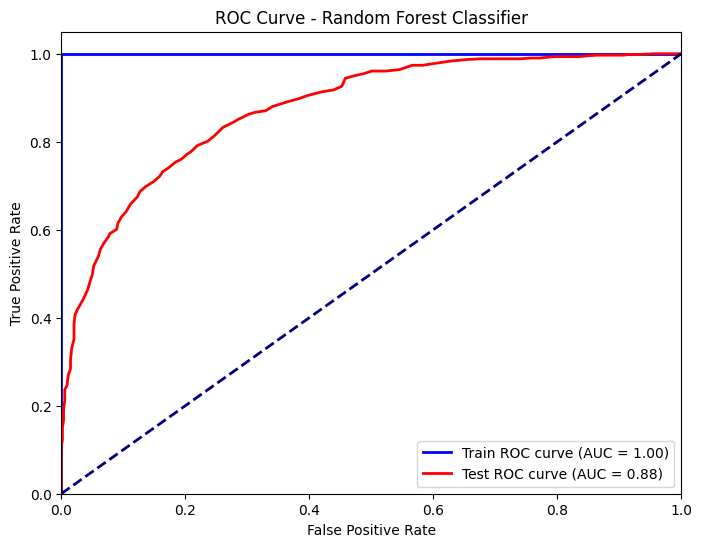

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = random_forest.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = random_forest.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve demonstrates exceptional discrimination ability for the model, with a training set AUC of 1.00 and a test set AUC of 0.88. While the model performs flawlessly on the training data, the slightly lower AUC on the test set still indicates strong discrimination ability and good generalization capability.

## **Most Important Features**
**This chart represents the importance of each feature from the 'Post' column and how much it affects the Labels**

In [27]:
'''
feature_importances = random_forest.feature_importances_

top_n = 25
top_features_indices = feature_importances.argsort()[-top_n:][::-1]

unwanted_terms = ["rt", "via", "acs", "[][]"] # What are these random influencers in dataset? They are simply termed as noise.
top_features = []
top_importances = []

for index in top_features_indices:
    feature_name = list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(index)]
    if feature_name not in unwanted_terms:
        top_features.append(feature_name)
        top_importances.append(feature_importances[index])

# Plot the top N most important features
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 Important Features for Random Forest Classifier')
plt.gca().invert_yaxis()  # It looks much better on y-axis
plt.show()
'''

'\nfeature_importances = random_forest.feature_importances_\n\ntop_n = 25\ntop_features_indices = feature_importances.argsort()[-top_n:][::-1]\n\nunwanted_terms = ["rt", "via", "acs", "[][]"] # What are these random influencers in dataset? They are simply termed as noise.\ntop_features = []\ntop_importances = []\n\nfor index in top_features_indices:\n    feature_name = list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(index)]\n    if feature_name not in unwanted_terms:\n        top_features.append(feature_name)\n        top_importances.append(feature_importances[index])\n\n# Plot the top N most important features\nplt.figure(figsize=(10, 8))\nplt.barh(top_features, top_importances, color=\'skyblue\')\nplt.xlabel(\'Importance\')\nplt.ylabel(\'Feature\')\nplt.title(\'Top 25 Important Features for Random Forest Classifier\')\nplt.gca().invert_yaxis()  # It looks much better on y-axis\nplt.show()\n'

The diagram demonstrates the top 25 important features for a Random Forest Classifier model. Here's a detailed analysis:

1. Feature Importances: The code calculates the feature importances of the Random Forest Classifier model and selects the top 25 most important features. This is a useful technique to understand which features in the dataset are the most influential for the model's predictions.
2. Unwanted Terms: The code defines a list of "unwanted terms" (["rt", "via", "acs"]). These are likely terms that are considered as noise or irrelevant for the classification task, and the code excludes them from the final list of top features.
3. Visualization: The code creates a horizontal bar plot to visualize the top 25 important features and their respective importances. This visual representation helps to easily identify the most significant features for the model.
4. Interpretation: Based on the diagram, the top 5 important features for the Random Forest Classifier are:
* `facewithtearsofjoyr`
* `pranabmukherjee`
* `navbharattimes`
* `covid`
* `live`

  These features seem to be related to the context of the dataset, which could be related to news, social media, or some other domain. The importance of these features suggests that they are highly predictive for the classification task performed by the Random Forest Classifier.

### **To test Random Forest**

In [ ]:
# I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = random_forest.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = random_forest.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Gradient Boosting***

---

Gradient Boosting is a powerful machine learning algorithm used for both regression and classification tasks. It's an ensemble learning technique where multiple weak learners, typically decision trees, are combined to create a strong predictive model. It works in the following steps:

1. Weak Learners: Builds a sequence of weak learners, typically decision trees, where each tree corrects the errors made by the previous one.

2. Gradient Descent: Optimizes the model's parameters by minimizing the loss function using gradient descent, focusing on reducing errors.

3. Boosting Process: Iteratively trains weak learners to fit the residuals of the ensemble of previous models, emphasizing areas where the model performs poorly.

4. Combining Predictions: Combines predictions from all weak learners to produce the final output. In regression tasks, predictions are averaged, while in classification tasks, a voting mechanism is used.



In [28]:
# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_tfidf, y_train)

GradientBoostingClassifier()

In [29]:
# Make predictions on the test set
y_pred = gb_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.78      0.58      0.67       537
     non-hostile       0.70      0.86      0.77       609

        accuracy                           0.73      1146
       macro avg       0.74      0.72      0.72      1146
    weighted avg       0.74      0.73      0.72      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.78, indicating 78% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.70, suggesting 70% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.58 recall for "needs_moderation," 58% of actual "needs_moderation" instances were identified. For "non-hostile," it's higher at 0.86, indicating 86% were identified.

* F1-score: The harmonic mean of precision and recall. "Needs_moderation" has an F1-score of 0.67, while "non-hostile" has 0.77, suggesting better overall performance for the latter.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.73, meaning 73% of instances were correctly classified. This indicates the model's moderate performance in distinguishing between the classes.

### **ROC Curve for Gradient Boosting**

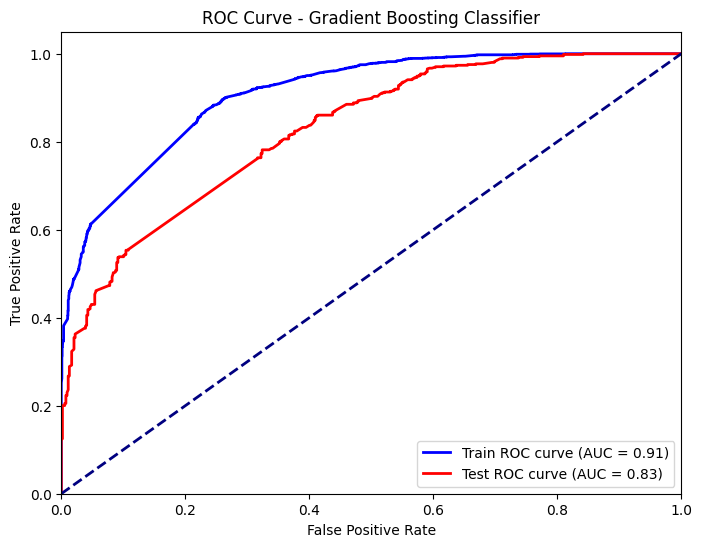

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = gb_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = gb_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve illustrates strong performance for the model, with a training set AUC of 0.91 and a test set AUC of 0.83. This indicates that the model exhibits effective discrimination between classes on both the training and test datasets, showcasing reasonable generalization capability.

To test Gradient Boosting

In [ ]:
# I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = gb_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = gb_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Logistic Regression***


---
Logistic regression is a statistical method used for binary classification tasks, where the outcome variable is categorical and has only two possible values (e.g., yes/no, true/false, 0/1). It predicts the probability of an observation belonging to one of the two classes based on one or more predictor variables.

Here's a brief overview of how logistic regression works:

1. Model Representation: The logistic regression model calculates the probability of the binary outcome using a logistic function. The logistic function maps any real-valued input to a value between 0 and 1.

2. Probability Calculation: Given a set of predictor variables, logistic regression calculates the log-odds (logarithm of the odds) of the event occurring.

3. Parameter Estimation: The model parameters (coefficients) are estimated using optimization techniques such as maximum likelihood estimation. These parameters are adjusted to minimize the difference between the predicted probabilities and the actual outcomes in the training data.

4. Decision Boundary: Logistic regression uses a decision boundary (typically at 0.5 probability) to classify observations into one of the two classes.

5. Prediction: After the model is trained, it can be used to predict the probability of an observation belonging to a particular class. If the predicted probability is above the decision threshold, the observation is classified as belonging to one class; otherwise, it's classified as belonging to the other class.



In [ ]:
# Train a Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logistic_regression.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Make predictions on the test set
y_pred = logistic_regression.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))


                  precision    recall  f1-score   support

needs_moderation       0.80      0.78      0.79       537
     non-hostile       0.81      0.83      0.82       609

        accuracy                           0.80      1146
       macro avg       0.80      0.80      0.80      1146
    weighted avg       0.80      0.80      0.80      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.80, indicating 80% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.81, suggesting 81% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.78 recall for "needs_moderation," 78% of actual "needs_moderation" instances were identified. For "non-hostile," it's higher at 0.83, indicating 83% were identified.

* F1-score: The harmonic mean of precision and recall. "Needs_moderation" has an F1-score of 0.79, while "non-hostile" has 0.82, suggesting better overall performance for the latter.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.80, meaning 80% of instances were correctly classified. This indicates the model's good performance in distinguishing between the classes.

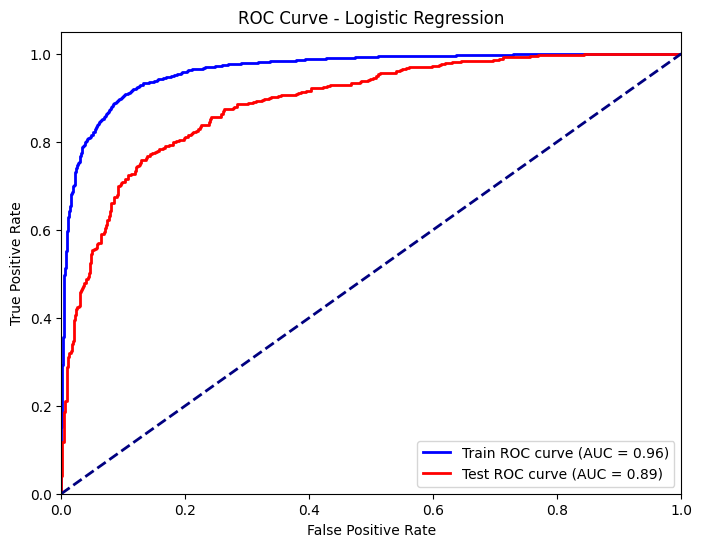

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = logistic_regression.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = logistic_regression.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


The ROC curve indicates robust performance for the model, with a training set AUC of 0.96 and a test set AUC of 0.89. This suggests that the model effectively discriminates between classes in both the training and test datasets, demonstrating good generalization ability.

To test Logistic Regression

In [ ]:
#I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = logistic_regression.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = logistic_regression.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Multi-layer Perceptron*** (This is the best)



---


A Multi-layer Perceptron (MLP) is a type of artificial neural network that consists of multiple layers of nodes (neurons), including an input layer, one or more hidden layers, and an output layer. MLPs are commonly used for supervised learning tasks, including classification and regression.

Here's how Multi-layer Perceptron (MLP) works:

1. Each neuron in the hidden layers applies a weighted sum of inputs followed by an activation function.
2. Weights and biases adjust during training to minimize the difference between predicted and actual outputs.
3. Activation functions introduce non-linearity, allowing the network to model complex relationships.
4. Backpropagation computes gradients of the loss function to update weights and biases.
5. Training iteratively adjusts parameters until the model performs well on the training data.
6. Once trained, the MLP can make predictions on new data by passing it through the network.


In [ ]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam', random_state=42)

# Train the classifier
mlp_classifier.fit(X_train_tfidf, y_train)


MLPClassifier(max_iter=500, random_state=42)

In [ ]:
# Make predictions on the test set
y_pred = mlp_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.78      0.77      0.77       537
     non-hostile       0.80      0.81      0.80       609

        accuracy                           0.79      1146
       macro avg       0.79      0.79      0.79      1146
    weighted avg       0.79      0.79      0.79      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.78, indicating 78% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.80, suggesting 80% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.77 recall for "needs_moderation," 77% of actual "needs_moderation" instances were identified. For "non-hostile," it's slightly higher at 0.81, indicating 81% were identified.

* F1-score: The harmonic mean of precision and recall. "Needs_moderation" has an F1-score of 0.77, while "non-hostile" has 0.80, suggesting better overall performance for the latter.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.79, meaning 79% of instances were correctly classified. This indicates the model's good performance in distinguishing between the classes.

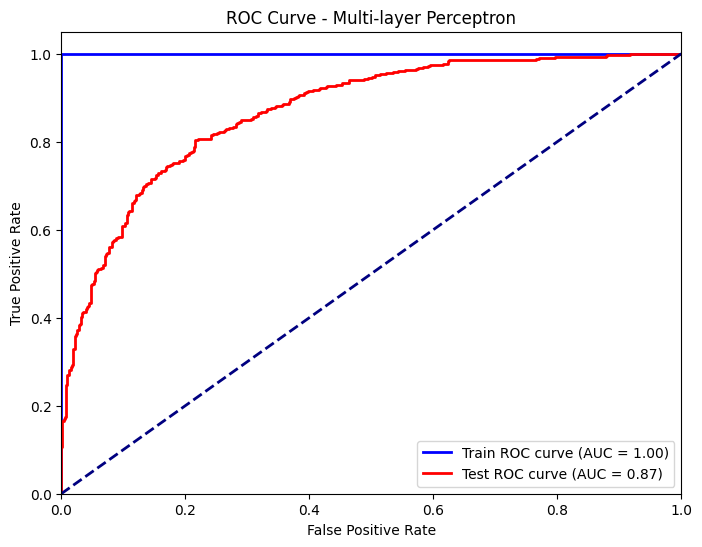

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = mlp_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = mlp_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-layer Perceptron')
plt.legend(loc='lower right')
plt.show()


The ROC curve illustrates excellent discrimination ability for the model, with a training set AUC of 1.00 and a test set AUC of 0.87. This indicates that the model achieves perfect separation between classes in the training data and performs very well on unseen test data, demonstrating strong generalization capability.

To test Multi-layer perceptron

In [ ]:
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()  # Lowercase the custom input
custom_input_tfidf = vectorizer.transform([custom_input])

# Predict label for the custom input
predicted_label = mlp_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()  # Lowercase the custom input\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\n# Predict label for the custom input\npredicted_label = mlp_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***XGBoost Classifier***

---

XGBoost (Extreme Gradient Boosting) is an ensemble learning method used for supervised learning tasks, particularly for classification and regression problems. The XGBoost Classifier is specifically tailored for classification tasks.
* It builds decision trees sequentially, correcting errors of previous trees.
* Gradient boosting optimizes a loss function by adding trees greedily.
* Regularization techniques control overfitting.
* Feature importance indicates the contribution of each feature.
* It's computationally efficient and supports parallel processing.
* Handles missing values and supports cross-validation.
* Early stopping prevents overfitting.
* Scalable for large datasets.

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode target labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Initialize XGBClassifier
xgb_classifier = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)

# Train the classifier
xgb_classifier.fit(X_train_tfidf, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions on the test set
y_pred_encoded = xgb_classifier.predict(X_test_tfidf)

# Decode predicted labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.78      0.55      0.64       537
     non-hostile       0.68      0.87      0.77       609

        accuracy                           0.72      1146
       macro avg       0.73      0.71      0.70      1146
    weighted avg       0.73      0.72      0.71      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.78, indicating 78% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.68, suggesting 68% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.55 recall for "needs_moderation," only 55% of actual "needs_moderation" instances were identified. For "non-hostile," it's higher at 0.87, indicating 87% were identified.

* F1-score: The harmonic mean of precision and recall. "Needs_moderation" has an F1-score of 0.64, while "non-hostile" has 0.77, suggesting better overall performance for the latter.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.72, meaning 72% of instances were correctly classified. This indicates the model's moderate performance in distinguishing between the classes.

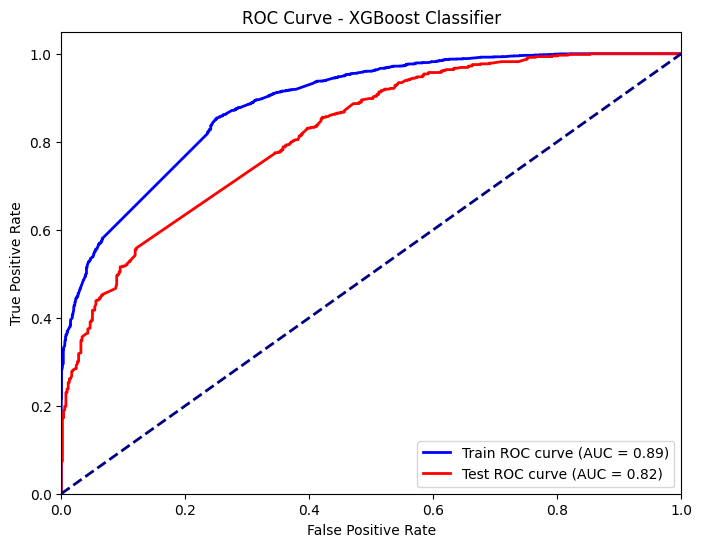

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = xgb_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = xgb_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve indicates decent discrimination ability for both the training and test sets. The training set AUC is 0.89, while the test set AUC is 0.82. Although there's a slight drop in performance from training to testing, the model still demonstrates good generalization capability, albeit with a moderate difference in performance between the two datasets.

To test XGBoost. Dont even test this its not good. üòû

In [ ]:
#I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

custom_input_pred_encoded = xgb_classifier.predict(custom_input_tfidf)
custom_input_pred = label_encoder.inverse_transform(custom_input_pred_encoded)[0]
print("Predicted label:", custom_input_pred)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\ncustom_input_pred_encoded = xgb_classifier.predict(custom_input_tfidf)\ncustom_input_pred = label_encoder.inverse_transform(custom_input_pred_encoded)[0]\nprint("Predicted label:", custom_input_pred)\n'

## ***Support Vector Machine***

---
Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. In classification, SVM aims to find the optimal hyperplane that best separates data points of different classes.

1. Data Preparation: Gather labeled training data.

2. Hyperplane Initialization: Start with an initial decision boundary.

3. Maximizing Margin: Identify the hyperplane that maximizes the margin between classes.

4. Support Vector Identification: Determine support vectors, closest to the decision boundary.

5. Kernel Selection: Choose a kernel function to map data into higher-dimensional space for non-linear separation.

6. Soft Margin Classification: Allow for some misclassifications with a regularization parameter (C).

7. Training: Optimize parameters to find the best hyperplane separating classes.

8. Prediction: Classify new data points based on their position relative to the decision boundary.


In [ ]:
# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', probability=True)  # You can try different kernels like 'rbf', 'poly', etc.

# Train the classifier
svm_classifier.fit(X_train_tfidf, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.80      0.82      0.81       537
     non-hostile       0.83      0.82      0.83       609

        accuracy                           0.82      1146
       macro avg       0.82      0.82      0.82      1146
    weighted avg       0.82      0.82      0.82      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.80, indicating 80% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.83, suggesting 83% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.82 recall for both "needs_moderation" and "non-hostile," it indicates that 82% of actual instances for both classes were identified.

* F1-score: The harmonic mean of precision and recall. Both classes have F1-scores of 0.81 and 0.83, respectively, indicating balanced performance between precision and recall.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.82, meaning 82% of instances were correctly classified. This indicates the model's strong performance in distinguishing between the classes.

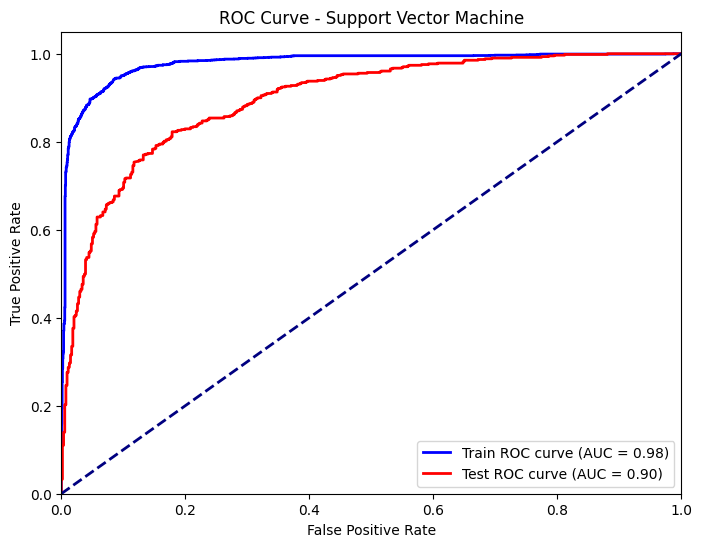

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = svm_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = svm_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machine')
plt.legend(loc='lower right')
plt.show()


The ROC curve demonstrates strong discrimination ability for both the training and test sets. The training set AUC is 0.98, while the test set AUC is 0.90. This indicates that the model maintains good generalization capability, with only a slight drop in performance from training to testing, suggesting effective learning and generalization.

To test Support Vector Machine

In [ ]:
#I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = svm_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = svm_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Decision Tree***

---
A Decision Tree is a supervised machine learning algorithm used for both classification and regression tasks. It works by partitioning the dataset into smaller subsets based on the values of input features, with the goal of creating a tree-like model of decisions.Here's how it works:

1. Splitting: Decision Trees recursively split data based on features to maximize information gain or minimize impurity.

2. Feature Selection: Choose the best feature to split the data at each node.

3. Leaf Nodes: Continue splitting until stopping criteria are met, forming leaf nodes with class labels or regression values.

4. Decision Making: Predictions are made by traversing the tree from the root to a leaf node.

5. Interpretability: Decision Trees are easily understood and visualized.

6. Handling Missing Values: Can handle missing data using surrogate splits or imputation.

7. Pruning: Nodes are pruned to prevent overfitting.

8. Ensemble Methods: Decision Trees can be combined for improved performance in Random Forests or Gradient Boosting Machines.


In [ ]:
# Initialize Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier
decision_tree_classifier.fit(X_train_tfidf, y_train)

DecisionTreeClassifier()

In [ ]:
# Make predictions on the test set
y_pred = decision_tree_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.70      0.71      0.70       537
     non-hostile       0.74      0.73      0.74       609

        accuracy                           0.72      1146
       macro avg       0.72      0.72      0.72      1146
    weighted avg       0.72      0.72      0.72      1146



**Classification Report:**

* Precision: Precision measures the accuracy of positive class predictions. For "needs_moderation," it's 0.70, indicating 70% of instances predicted as "needs_moderation" were correct. For "non-hostile," it's 0.74, suggesting 74% accuracy.

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.71 recall for "needs_moderation" and 0.73 for "non-hostile," it indicates that 71% and 73% of actual instances for each class were identified, respectively.

* F1-score: The harmonic mean of precision and recall. Both classes have F1-scores of 0.70 and 0.74, respectively, indicating balanced performance between precision and recall.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.72, meaning 72% of instances were correctly classified. This indicates the model's moderate performance in distinguishing between the classes.

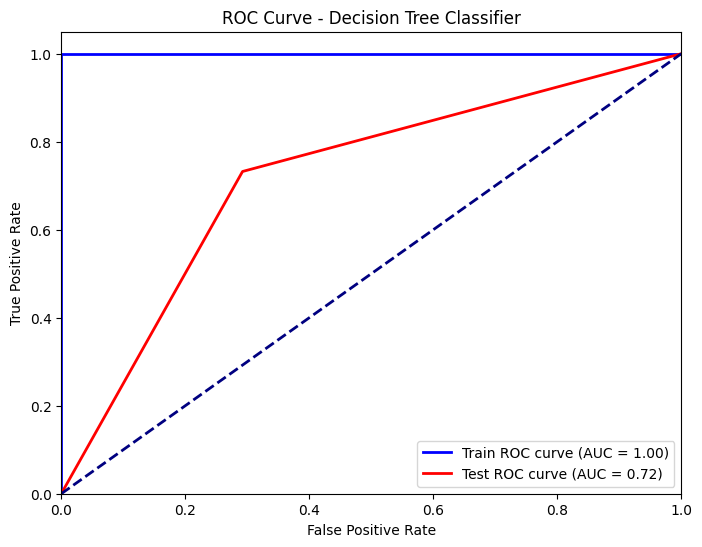

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = decision_tree_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = decision_tree_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve indicates perfect discrimination ability on the training set, with an AUC of 1.00. However, on the test set, the AUC is 0.72, suggesting a notable drop in discrimination ability. This difference implies potential overfitting of the model to the training data, leading to reduced performance on unseen data.

To test Decision Tree

In [ ]:
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = decision_tree_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = decision_tree_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***K-nearest neighbors***

---

K-Nearest Neighbors (KNN) is a simple and intuitive supervised machine learning algorithm used for classification and regression tasks. It belongs to the category of instance-based learning algorithms, where the model stores the entire training dataset and makes predictions based on the similarity of new data points to existing data points.

In KNN:

* "K" represents the number of nearest neighbors to consider when making predictions.
* To make a prediction for a new data point, the algorithm calculates the distance between that point and all other points in the training dataset.
* It then selects the "k" closest data points (neighbors) based on a chosen distance metric, such as Euclidean distance or Manhattan distance.
* For classification tasks, the algorithm assigns the most common class label among the k nearest neighbors to the new data point.
* For regression tasks, it calculates the average (or weighted average) of the target values of the k nearest neighbors to predict the target value for the new data point.


In [ ]:
# K-nearest neighbors
# Initialize KNN classifier
knn_classifier = KNeighborsClassifier()  # No need to specify the number of neighbors here

# Perform hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Adjust the range of neighbors as needed
    'weights': ['uniform', 'distance'],  # Weights assigned to neighbors (uniform or distance-based)
    'metric': ['euclidean', 'manhattan']  # Distance metric to measure the similarity between instances
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions on the test set using the best model
best_knn_classifier = grid_search.best_estimator_
y_pred = best_knn_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Best Score: 0.7640671355711858
                  precision    recall  f1-score   support

needs_moderation       0.66      0.93      0.78       537
     non-hostile       0.91      0.59      0.71       609

        accuracy                           0.75      1146
       macro avg       0.79      0.76      0.74      1146
    weighted avg       0.79      0.75      0.74      1146



**Classification Report:**

* Precision: The precision for "needs_moderation" is 0.66, indicating that 66% of instances predicted as "needs_moderation" were actually "needs_moderation." For "non-hostile," precision is higher at 0.91, suggesting 91% accuracy in identifying instances as "non-hostile."

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.93 recall for "needs_moderation" and 0.59 for "non-hostile," it indicates that 93% and 59% of actual instances for each class were identified, respectively.

* F1-score: The F1-score is the harmonic mean of precision and recall. For "needs_moderation," it's 0.78, and for "non-hostile," it's 0.71. These scores indicate overall good performance in correctly predicting each class.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.75, meaning 75% of instances were correctly classified. This indicates the model's moderate performance in distinguishing between the classes.

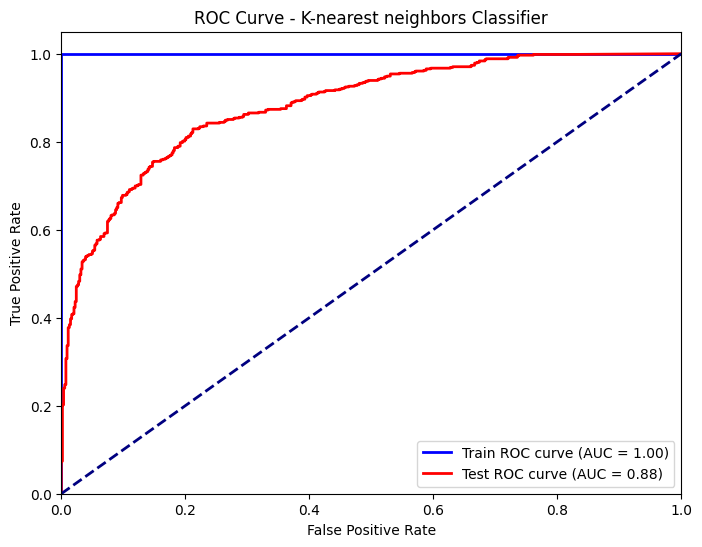

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = best_knn_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = best_knn_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-nearest neighbors Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve demonstrates exceptional discrimination ability for the model, with a training set AUC of 1.00 and a test set AUC of 0.88. While the model performs flawlessly on the training data, the slightly lower AUC on the test set still indicates strong discrimination ability and good generalization capability.

To test K-nearest Neighbors

In [ ]:
#I.p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = knn_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = knn_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Naive Bayes Classifier***

---
The Naive Bayes classifier is a simple probabilistic machine learning algorithm used for classification tasks. It is based on Bayes' theorem and makes the assumption of feature independence, which simplifies the computation and allows for efficient training and prediction.



Naive Bayes classifies data by calculating the probability of each class given the observed features and selecting the class with the highest probability. It assumes that features are independent, simplifying computations. This method is efficient, especially for text classification, but may not perform well if the independence assumption is violated.


In [ ]:
# Initialize Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate model performance
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

needs_moderation       0.83      0.80      0.82       537
     non-hostile       0.83      0.86      0.84       609

        accuracy                           0.83      1146
       macro avg       0.83      0.83      0.83      1146
    weighted avg       0.83      0.83      0.83      1146



**Classification Report:**

* Precision: Precision for "needs_moderation" is 0.83, indicating that 83% of instances predicted as "needs_moderation" were actually "needs_moderation." Similarly, for "non-hostile," precision is also 0.83, suggesting 83% accuracy in identifying instances as "non-hostile."

* Recall: Recall measures the ability to identify all relevant instances of a class. With 0.80 recall for "needs_moderation" and 0.86 for "non-hostile," it indicates that 80% and 86% of actual instances for each class were identified, respectively.

* F1-score: The F1-score is the harmonic mean of precision and recall. For "needs_moderation," it's 0.82, and for "non-hostile," it's 0.84. These scores indicate overall good performance in correctly predicting each class.

* Support: Refers to the number of occurrences of each class in the dataset. There are 537 instances of "needs_moderation" and 609 of "non-hostile."

**Accuracy:**
* Accuracy: The overall accuracy is 0.83, meaning 83% of instances were correctly classified. This indicates the model's strong performance in distinguishing between the classes.

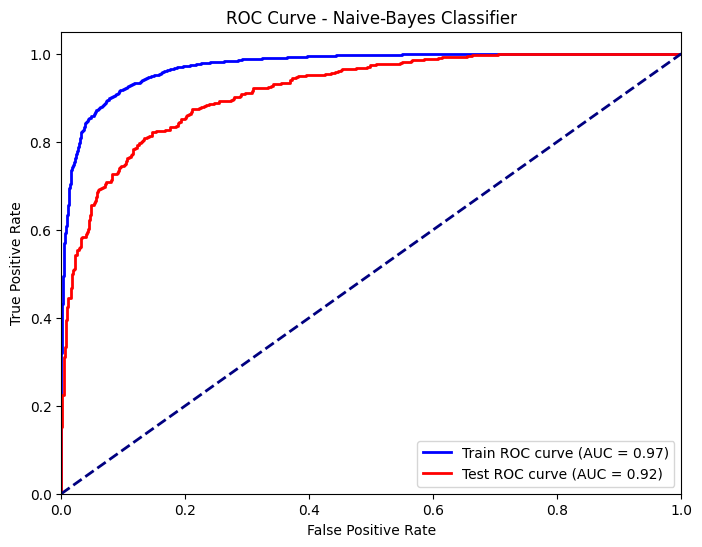

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
label_encoder = LabelEncoder()
y_train_binary = label_encoder.fit_transform(y_train)
y_test_binary = label_encoder.transform(y_test)

# Calculate the probabilities for the positive class
y_train_prob = nb_classifier.predict_proba(X_train_tfidf)[:, 1]
y_test_prob = nb_classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for both training and testing data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the ROC curve (AUC) for both training and testing data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive-Bayes Classifier')
plt.legend(loc='lower right')
plt.show()


The ROC curve illustrates strong discrimination ability for the model, with a training set AUC of 0.97 and a test set AUC of 0.92. This suggests robust performance on both the training and test datasets, indicating the model's capability to generalize well to unseen data.

To test Naive Bayes Classifiers

In [ ]:
#I/p
'''
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = nb_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)
'''

'\ncustom_input = input("Enter a sentence (in Hindi) to classify: ")\ncustom_input = custom_input.lower()\ncustom_input_tfidf = vectorizer.transform([custom_input])\n\npredicted_label = nb_classifier.predict(custom_input_tfidf)[0]\nprint("Predicted label:", predicted_label)\n'

## ***Comparison***

The comparison below shows that Multi-layer Perceptron Classifier works the best which has around 80% accuracy

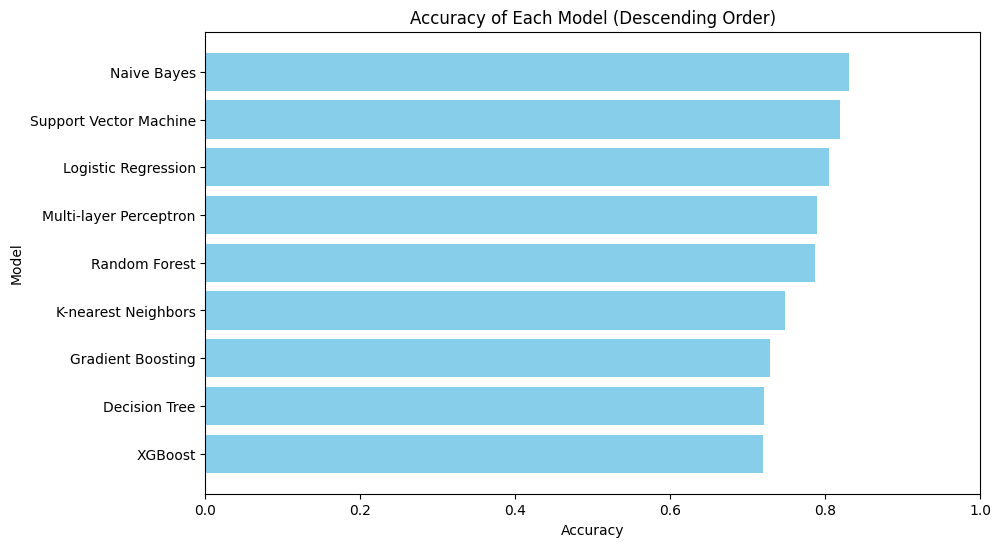

In [ ]:
import matplotlib.pyplot as plt

# Define model names and their respective accuracies
models = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Multi-layer Perceptron',
          'XGBoost', 'Support Vector Machine', 'Decision Tree', 'K-nearest Neighbors', 'Naive Bayes']
accuracies = [random_forest.score(X_test_tfidf, y_test),
              gb_classifier.score(X_test_tfidf, y_test),
              logistic_regression.score(X_test_tfidf, y_test),
              mlp_classifier.score(X_test_tfidf, y_test),
              0.72,
              svm_classifier.score(X_test_tfidf, y_test),
              decision_tree_classifier.score(X_test_tfidf, y_test),
              best_knn_classifier.score(X_test_tfidf, y_test),
              nb_classifier.score(X_test_tfidf, y_test)]

# Pair model names with accuracies and sort them by accuracy in descending order
sorted_models_accuracies = sorted(zip(models, accuracies), key=lambda x: x[1], reverse=True)

# Unpack sorted model names and accuracies
sorted_models, sorted_accuracies = zip(*sorted_models_accuracies)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.barh(sorted_models, sorted_accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy of Each Model (Descending Order)')
plt.xlim(0, 1)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest accuracy on top
plt.show()


This graph shows the accuracy of various machine learning models in descending order, with Naive Bayes having the highest accuracy and XGBoost having the lowest accuracy among the models presented.

The models are arranged vertically, and the accuracy values for each model are displayed horizontally, ranging from 0.0 to 1.0 (or 0% to 100%). The higher the accuracy value, the better the model's performance.

From the graph, we can see that Naive Bayes has the highest accuracy, followed by Support Vector Machine, Logistic Regression, Multi-layer Perceptron, Random Forest, K-nearest Neighbors, Gradient Boosting, Decision Tree, and XGBoost, in descending order of accuracy.


In [ ]:
# Define model names and their respective accuracies
models = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Multi-layer Perceptron',
          'XGBoost', 'Support Vector Machine', 'Decision Tree', 'K-nearest Neighbors', 'Naive Bayes']
accuracies = [random_forest.score(X_test_tfidf, y_test),
              gb_classifier.score(X_test_tfidf, y_test),
              logistic_regression.score(X_test_tfidf, y_test),
              mlp_classifier.score(X_test_tfidf, y_test),
              0.72,
              svm_classifier.score(X_test_tfidf, y_test),
              decision_tree_classifier.score(X_test_tfidf, y_test),
              best_knn_classifier.score(X_test_tfidf, y_test),
              nb_classifier.score(X_test_tfidf, y_test)]

# Pair model names with accuracies and sort them by accuracy in descending order
sorted_models_accuracies = sorted(zip(models, accuracies), key=lambda x: x[1], reverse=True)

# Unpack sorted model names and accuracies
sorted_models, sorted_accuracies = zip(*sorted_models_accuracies)

# Print the models and their accuracies in descending order
for model, accuracy in zip(sorted_models, sorted_accuracies):
    print(f"{model}: {accuracy}")


Naive Bayes: 0.8307155322862129
Support Vector Machine: 0.819371727748691
Logistic Regression: 0.8045375218150087
Multi-layer Perceptron: 0.7897033158813264
Random Forest: 0.7862129144851658
K-nearest Neighbors: 0.7478184991273996
Gradient Boosting: 0.7286212914485166
Decision Tree: 0.7207678883071553
XGBoost: 0.72


In [ ]:
# Print classification report for each model
print("Random Forest:")
print(classification_report(y_test, random_forest.predict(X_test_tfidf)))

print("Gradient Boosting:")
print(classification_report(y_test, gb_classifier.predict(X_test_tfidf)))

print("Logistic Regression:")
print(classification_report(y_test, logistic_regression.predict(X_test_tfidf)))

print("Multi-layer Perceptron:")
print(classification_report(y_test, mlp_classifier.predict(X_test_tfidf)))

#print("XGBoost:")
#print(classification_report(y_test, label_encoder.inverse_transform(xgb_classifier.predict(X_test_tfidf))))

print("Support Vector Machine:")
print(classification_report(y_test, svm_classifier.predict(X_test_tfidf)))

print("Decision Tree:")
print(classification_report(y_test, decision_tree_classifier.predict(X_test_tfidf)))

print("K-nearest Neighbors:")
print(classification_report(y_test, best_knn_classifier.predict(X_test_tfidf)))

print("Naive Bayes:")
print(classification_report(y_test, nb_classifier.predict(X_test_tfidf)))


Random Forest:
                  precision    recall  f1-score   support

needs_moderation       0.77      0.78      0.77       537
     non-hostile       0.80      0.79      0.80       609

        accuracy                           0.79      1146
       macro avg       0.79      0.79      0.79      1146
    weighted avg       0.79      0.79      0.79      1146

Gradient Boosting:
                  precision    recall  f1-score   support

needs_moderation       0.79      0.58      0.67       537
     non-hostile       0.70      0.86      0.77       609

        accuracy                           0.73      1146
       macro avg       0.74      0.72      0.72      1146
    weighted avg       0.74      0.73      0.72      1146

Logistic Regression:
                  precision    recall  f1-score   support

needs_moderation       0.80      0.78      0.79       537
     non-hostile       0.81      0.83      0.82       609

        accuracy                           0.80      1146
       ma

In [ ]:
import pandas as pd

# Create a DataFrame to store model names and their metrics
model_metrics = pd.DataFrame({
    'ML Model': models,
    'Accuracy': accuracies,
    'F1-score': [f1_score(y_test, random_forest.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, gb_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, logistic_regression.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, mlp_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, label_encoder.inverse_transform(xgb_classifier.predict(X_test_tfidf)), average='weighted'),
                 f1_score(y_test, svm_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, decision_tree_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, best_knn_classifier.predict(X_test_tfidf), average='weighted'),
                 f1_score(y_test, nb_classifier.predict(X_test_tfidf), average='weighted')],
    'Recall': [recall_score(y_test, random_forest.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, gb_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, logistic_regression.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, mlp_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, label_encoder.inverse_transform(xgb_classifier.predict(X_test_tfidf)), average='weighted'),
               recall_score(y_test, svm_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, decision_tree_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, best_knn_classifier.predict(X_test_tfidf), average='weighted'),
               recall_score(y_test, nb_classifier.predict(X_test_tfidf), average='weighted')],
    'Precision': [precision_score(y_test, random_forest.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, gb_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, logistic_regression.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, mlp_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, label_encoder.inverse_transform(xgb_classifier.predict(X_test_tfidf)), average='weighted'),
                  precision_score(y_test, svm_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, decision_tree_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, best_knn_classifier.predict(X_test_tfidf), average='weighted'),
                  precision_score(y_test, nb_classifier.predict(X_test_tfidf), average='weighted')]
})

# Sort the DataFrame by accuracy in descending order
sorted_model_metrics = model_metrics.sort_values(by='Accuracy', ascending=False)

# Display the sorted DataFrame
sorted_model_metrics

ML Model  Accuracy  F1-score    Recall  Precision
8             Naive Bayes  0.830716  0.830447  0.830716   0.830796
5  Support Vector Machine  0.819372  0.819450  0.819372   0.819629
2     Logistic Regression  0.804538  0.804387  0.804538   0.804413
3  Multi-layer Perceptron  0.789703  0.789641  0.789703   0.789610
0           Random Forest  0.786213  0.786305  0.786213   0.786495
7     K-nearest Neighbors  0.747818  0.741822  0.747818   0.793069
1       Gradient Boosting  0.728621  0.722193  0.728621   0.739287
6           Decision Tree  0.720768  0.720852  0.720768   0.720976
4                 XGBoost  0.720000  0.708762  0.717277   0.731297

# **Final Chosen Techniques**

## **Naive-Bayes Classifier**

In [ ]:
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = nb_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)

if predicted_label == 'needs_moderation':
    print("The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.")
elif predicted_label == 'non-hostile':
    print("The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.")
else:
    print("Unknown label predicted.")

Enter a sentence (in Hindi) to classify: ‡§∏‡•Å‡§∂‡§æ‡§Ç‡§§ ‡§®‡•á ‡§ú‡•ã ‡§¨‡§ø‡§ú‡§®‡•á‡§∏ ‡§°‡•Ä‡§≤ 9 ‡§ú‡•Ç‡§® ‡§ï‡•ã ‡§ï‡•Ä ‡§•‡•Ä, ‡§µ‡•ã ‡§°‡•Ä‡§≤ ‡§¶‡•Ä‡§™‡•á‡§∂ ‡§ï‡•ã ‡§∏‡•Å‡§∂‡§æ‡§Ç‡§§ ‡§ï‡•Ä ‡§π‡§§‡•ç‡§Ø‡§æ ‡§ï‡•á ‡§¶‡§ø‡§® ‡§π‡•Ä ‡§ï‡•ç‡§Ø‡•ã‡§Ç ‡§Ø‡§æ‡§¶ ‡§Ü‡§à? ‡§¶‡•á‡§ñ‡§ø‡§è '‡§™‡•Ç‡§õ‡§§‡§æ ‡§π‡•à ‡§≠‡§æ‡§∞‡§§' ‡§Ö‡§∞‡•ç‡§®‡§¨ ‡§ï‡•á ‡§∏‡§æ‡§• ‡§∞‡§ø‡§™‡§¨‡•ç‡§≤‡§ø‡§ï ‡§≠‡§æ‡§∞‡§§ ‡§™‡§∞ #live :  https://t.co/g945hvzm0z https://t.co/kfh7xf1idm
Predicted label: non-hostile
The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.


In [ ]:
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = svm_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)

if predicted_label == 'needs_moderation':
    print("The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.")
elif predicted_label == 'non-hostile':
    print("The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.")
else:
    print("Unknown label predicted.")


Enter a sentence (in Hindi) to classify: ‡§∏‡•Å‡§∂‡§æ‡§Ç‡§§ ‡§®‡•á ‡§ú‡•ã ‡§¨‡§ø‡§ú‡§®‡•á‡§∏ ‡§°‡•Ä‡§≤ 9 ‡§ú‡•Ç‡§® ‡§ï‡•ã ‡§ï‡•Ä ‡§•‡•Ä, ‡§µ‡•ã ‡§°‡•Ä‡§≤ ‡§¶‡•Ä‡§™‡•á‡§∂ ‡§ï‡•ã ‡§∏‡•Å‡§∂‡§æ‡§Ç‡§§ ‡§ï‡•Ä ‡§π‡§§‡•ç‡§Ø‡§æ ‡§ï‡•á ‡§¶‡§ø‡§® ‡§π‡•Ä ‡§ï‡•ç‡§Ø‡•ã‡§Ç ‡§Ø‡§æ‡§¶ ‡§Ü‡§à? ‡§¶‡•á‡§ñ‡§ø‡§è '‡§™‡•Ç‡§õ‡§§‡§æ ‡§π‡•à ‡§≠‡§æ‡§∞‡§§' ‡§Ö‡§∞‡•ç‡§®‡§¨ ‡§ï‡•á ‡§∏‡§æ‡§• ‡§∞‡§ø‡§™‡§¨‡•ç‡§≤‡§ø‡§ï ‡§≠‡§æ‡§∞‡§§ ‡§™‡§∞ #live :  https://t.co/g945hvzm0z https://t.co/kfh7xf1idm
Predicted label: non-hostile
The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.


## **Logistic Regression**

In [ ]:
import pandas as pd

# Load the input CSV file
input_data = pd.read_csv('constraint_Hindi_Train - Sheet1.csv')

# Preprocess the input data (e.g., lowercase)
input_data['Post'] = input_data['Post'].str.lower()

# Vectorize the input sentences
input_tfidf = vectorizer.transform(input_data['Post'])

# Predict labels for the input sentences
predicted_labels = logistic_regression.predict(input_tfidf)

# Create a new DataFrame with Unique ID, Post, and Predicted Labels
output_data = pd.DataFrame({
    'Unique ID': input_data['Unique ID'],
    'Post': input_data['Post'],
    'Predicted Label': predicted_labels
})

# Write the output DataFrame to a new CSV file
output_data.to_csv('/content/predicted_data_log.csv', index=False)

### Final Result with highest accuracy will be obtained in this.

In [ ]:
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()
custom_input_tfidf = vectorizer.transform([custom_input])

predicted_label = logistic_regression.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)

if predicted_label == 'needs_moderation':
    print("The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.")
elif predicted_label == 'non-hostile':
    print("The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.")
else:
    print("Unknown label predicted.")

Enter a sentence (in Hindi) to classify: ‡§Ø‡•Ç‡§™‡•Ä: ‡§¨‡§≤‡§∞‡§æ‡§Æ‡§™‡•Å‡§∞ ‡§Æ‡•á‡§Ç ‡§ñ‡§æ‡§®‡§æ ‡§¨‡§®‡§æ‡§§‡•á ‡§∏‡§Æ‡§Ø ‡§∏‡§ø‡§≤‡•á‡§Ç‡§°‡§∞ ‡§Æ‡•á‡§Ç ‡§ß‡§Æ‡§æ‡§ï‡§æ, ‡§¨‡§ö‡•ç‡§ö‡•á ‡§ï‡•Ä ‡§Æ‡•å‡§§, ‡§¶‡•ã ‡§ò‡§æ‡§Ø‡§≤  https://t.co/6ageczi66w
Predicted label: needs_moderation
The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.


### For classification with neural networks technique.

In [ ]:
import pandas as pd

# Load the input CSV file
input_data = pd.read_csv('constraint_Hindi_Train - Sheet1.csv')

# Preprocess the input data (e.g., lowercase)
input_data['Post'] = input_data['Post'].str.lower()

# Vectorize the input sentences
input_tfidf = vectorizer.transform(input_data['Post'])

# Predict labels for the input sentences
predicted_labels = mlp_classifier.predict(input_tfidf)

# Create a new DataFrame with Unique ID, Post, and Predicted Labels
output_data = pd.DataFrame({
    'Unique ID': input_data['Unique ID'],
    'Post': input_data['Post'],
    'Predicted Label': predicted_labels
})

# Write the output DataFrame to a new CSV file
output_data.to_csv('/content/predicted_data.csv', index=False)

## Multi-layer Perceptron

In [ ]:
custom_input = input("Enter a sentence (in Hindi) to classify: ")
custom_input = custom_input.lower()  # Lowercase the custom input
custom_input_tfidf = vectorizer.transform([custom_input])

# Predict label for the custom input
predicted_label = mlp_classifier.predict(custom_input_tfidf)[0]
print("Predicted label:", predicted_label)

if predicted_label == 'needs_moderation':
    print("The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.")
elif predicted_label == 'non-hostile':
    print("The model predicted 'non-hostile' indicating that the input appears to be benign and does not raise concerns about hostility or offensive content.")
else:
    print("Unknown label predicted.")

Enter a sentence (in Hindi) to classify: ‡§Ø‡•Ç‡§™‡•Ä: ‡§¨‡§≤‡§∞‡§æ‡§Æ‡§™‡•Å‡§∞ ‡§Æ‡•á‡§Ç ‡§ñ‡§æ‡§®‡§æ ‡§¨‡§®‡§æ‡§§‡•á ‡§∏‡§Æ‡§Ø ‡§∏‡§ø‡§≤‡•á‡§Ç‡§°‡§∞ ‡§Æ‡•á‡§Ç ‡§ß‡§Æ‡§æ‡§ï‡§æ, ‡§¨‡§ö‡•ç‡§ö‡•á ‡§ï‡•Ä ‡§Æ‡•å‡§§, ‡§¶‡•ã ‡§ò‡§æ‡§Ø‡§≤  https://t.co/6ageczi66w
Predicted label: needs_moderation
The model predicted 'needs_moderation' because the input may contain content that could potentially violate community guidelines or require further scrutiny.
